# Imports
The block directly below is responsible for switching what directory the data folders are accessed from. The purpose of this is to automatically switch where the data is stored/accessed depending on if the machine running the block is a local Windows machine, or Google Colab. If it is running in Colab, then Google Drive will be mounted and the workspace directory set respectively.

In [1]:
import os, platform

local = platform.system() == 'Windows'

if local:
    print('Running Locally')
    workspace_dir = './'
else:
    !pip install qqdm

    from google.colab import drive
    drive.mount('/content/drive/')

    workspace_dir = '/content/drive/MyDrive/School/2022_RIT/Masters/Workspace/'
    print('Running in Google Colab')

Running Locally


In [2]:
import random, math

from qqdm.notebook import qqdm as qqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

import torch
from torch import nn
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, Dataset)
from torch.optim import Adam

from scipy.stats import mstats

## Model
This is the base VAE model that was used for all created models.

In [3]:
class IDS_VAE(nn.Module):
    def __init__(self, latent_dim, KL_weight):
        super(IDS_VAE, self).__init__()

        self.latent_dim = latent_dim
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()

        self.channel_dims = [1, 32, 64]

        #====================[Encoder]====================
        self.encoder = nn.Sequential(
            nn.Conv2d(                                                                #in: N*1*8*8, out: N*dim[1]*4*4
                in_channels=self.channel_dims[0], out_channels=self.channel_dims[1],
                kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(self.channel_dims[1]),                                     #in and out: N*dim[1]*4*4
            nn.LeakyReLU(),                                                           #in and out: N*dim[1]*4*4
            nn.Conv2d(                                                                #in: N*dim[1]*4*4, out: N*dim[2]*2*2
                in_channels=self.channel_dims[1], out_channels=self.channel_dims[2],
                kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(self.channel_dims[2]),                                     #in and out: N*dim[2]*2*2
            nn.LeakyReLU()                                                            #in and out: N*dim[2]*2*2
        )

        #====================[Reparametrize]====================
        self.mu_layer  = nn.Linear(self.channel_dims[2]*2*2, self.latent_dim)         #in: N*1*(dim[2]*4)*1, out: N*1*latent_dim*1
        self.var_layer = nn.Linear(self.channel_dims[2]*2*2, self.latent_dim)         #in: N*1*(dim[2]*4)*1, out: N*1*latent_dim*1

        #====================[Decode]====================
        self.decode_linear_input = nn.Linear(                                         #in: N*1*latent_dim*1, out: N*1*(dim[2]*4)*1
            in_features=self.latent_dim, out_features=self.channel_dims[2]*2*2
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(                                                       #in: N*dim[2]*2*2, out: N*dim[1]*4*4
                in_channels=self.channel_dims[2], out_channels=self.channel_dims[1],
                kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(self.channel_dims[1]),                        #in and out: N*dim[1]*4*4
            nn.LeakyReLU(),                                                             #in and out: N*dim[1]*4*4
            nn.ConvTranspose2d(                                                       #in: N*dim[1]*4*4, out: N*dim[1]*8*8
                in_channels=self.channel_dims[1], out_channels=self.channel_dims[1],
                kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(self.channel_dims[1]),                        #in and out: N*dim[1]*8*8
            nn.LeakyReLU(),                                                           #in and out: N*dim[1]*8*8
            nn.Conv2d(                                                                #in: N*dim[1]*8*8, out: N*1*8*8
                in_channels=self.channel_dims[1], out_channels=self.channel_dims[0],
                kernel_size=3, padding=1
            ),
            ##nn.Tanh()                                                                 #in and out: N*1*8*8
            nn.Sigmoid()
        )

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        return result

    def reparameterize(self, x):
        mu = self.mu_layer(x)
        var = self.var_layer(x)

        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return (eps * std) + mu, mu, var

    def decode(self, x):
        result = self.decode_linear_input(x)
        result = result.view(-1, self.channel_dims[2], 2, 2)
        result = self.decoder(result)
        return result

    def forward(self, x):
        encoded_output = self.encode(x)
        reparameterized_output, mu, var = self.reparameterize(encoded_output)
        decoded_output = self.decode(reparameterized_output)
        return encoded_output, reparameterized_output, mu, var, decoded_output

    def loss(self, output, input, mu, var):
        mse_loss = self.criterion(output, input)

        KL_loss = torch.mean(-0.5 * torch.sum(1 + var - mu**2 - var.exp(), dim=1), dim=0)

        loss = mse_loss + self.KL_weight * KL_loss

        return loss, mse_loss, KL_loss

## Training Loop

In [1]:
def train_models(group_dict: dict, group_key: str, learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, dataset_dir):
    """
    Parameters:
        group_dict: dictionary where each key points to a list of similar model specific datset
            filenames (DoS, web, benign, ...)
        group_key: the key of the group (from group_dict) you want to train models on
        learning_rate: learning rate you want to use for the models
        latent_dim: the linear size of the latent dimension to use for the VAE models
        KL_weight: the weight of the KL Divergence in the calculated loss
        epochs: the number of epochs to train for
        batch_size: the batch size for training
        train_split: the portion of the samples to be used for training
        workspace_dir: the base directory where the data is stored
        dataset_dir: the sub directory of where the files specified by group_dict and group_key are stored.
    """
    for class_file in group_dict[group_key]:
        model = IDS_VAE(latent_dim, KL_weight).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        losses_train = []
        losses_test = []

        print(f'Reading file {workspace_dir + dataset_dir + class_file}')
        data = IDS_Dataset(workspace_dir + dataset_dir + class_file)
        
        train_mask = np.random.rand(len(data)) < train_split
        train_data = data[train_mask]
        test_data = data[~train_mask]
        print(f'Training samples: {len(train_data)}, Testing samples: {len(test_data)}')

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for i in qqdm(range(100)):
                model.train()
                data = next(iter(train_loader))
                x = data.view(-1, 1, 8, 8).cuda()
                encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
                loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
                losses_train.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #Eval
                model.eval()
                epoch_loss = []
                for data in test_loader:
                    x = data.view(-1, 1, 8, 8).cuda()
                    encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
                    loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
                    epoch_loss.append(loss.item())
                
                losses_test.append(np.mean(epoch_loss))
                
            
        plt.figure(dpi=150)
        plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
        plt.legend([f'Train (n={len(train_data)})', f'Test (n={len(test_data)})'])
        plt.title(class_file)

        model_filename = workspace_dir + 'models/' + class_file[:-4] + '.pt'
        torch.save(model, model_filename)
        print(f'Model saved to {model_filename}')

In [5]:
#This is the order and list of all the columns that will be used for all models.

final_cols = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
    ]

## Dataset

In [6]:
class IDS_Dataset(Dataset):
    """
    Custom Tensorflow Dataset class for loading the pre-processed dataset files, and
    removing the unused columns.
    """
    def __init__(this, filename):
        this.data = pd.read_csv(filename)

        for col in this.data.columns:
            if col not in final_cols:
                this.data = this.data.drop([col], axis=1)
        for i in range(len(final_cols)):
            if final_cols[i] != this.data.columns[i]:
                print('Column order differences!')
                print('Loaded:', this.data.columns)
                print('Desired:', final_cols)
                break
        this.data = torch.tensor(this.data.values, dtype=torch.float32)
    
    def __len__(this):
        return this.data.size(0)
    
    def __getitem__(this, idx):
        row = this.data[idx]
        return row

## Combining datasets

In [7]:
def combine_datasets(filenames: str, output_filename: str, max_samples_per = 10000):
    """
    Function designed to take multiple IDS dataset files and combine them into a single
    file. Setup to only use up to a certain number of samples per file.
    Parameters:
        filenames: array of filenames of datasets to combine
        output_filename: output filename
        max_samples_per: maximum number of samples to take from each dataset
    """
    data_files = {}
    min_samples = max_samples_per # min samples will limit the final dataset to being only 40k samples
    for dataset_file in filenames:
        df = pd.read_csv(dataset_file)
        for col in df.columns:
            if col not in final_cols:
                df = df.drop([col], axis=1)
        data_files[dataset_file] = df
        if len(df.index) < min_samples:
            min_samples = len(df.index)
    
    df_arr = []
    for key in data_files:
        df_arr.append(data_files[key].sample(n=min_samples))
    
    df = pd.concat(df_arr)

    
    df.to_csv(output_filename, index=False)
    print(f'Combined into new dataset ({output_filename}) with {len(df.index)} samples')



def combine_datasets_unbalanced(filenames: str, output_filename: str):
    """
    Function designed to take multiple IDS dataset files and combine them into a single
    file. Setup to only use up to combine every sample from each file into the final
    dataset.
    Parameters:
        filenames: array of filenames of datasets to combine
        output_filename: output filename
    """
    data_files = {}
    for dataset_file in filenames:
        df = pd.read_csv(dataset_file)
        for col in df.columns:
            if col not in final_cols:
                df = df.drop([col], axis=1)
        data_files[dataset_file] = df
    
    df_arr = []
    for key in data_files:
        df_arr.append(data_files[key])
    
    df = pd.concat(df_arr)

    
    df.to_csv(output_filename, index=False)
    print(f'Combined into new dataset ({output_filename}) with {len(df.index)} samples')

## Files
This is a list of all the files used. If any file errors occur, refer back to this list and edit names as neccessary.

In [8]:
CIC_2017_dir = 'CIC-IDS-2017/class_split/'

CIC_2017_files = [
    'daMonday-WorkingHours-BENIGN.csv',
    'dbTuesday-WorkingHours-BENIGN.csv',
    'dbTuesday-WorkingHours-FTP-Patator.csv',
    'dbTuesday-WorkingHours-SSH-Patator.csv',
    'dcWednesday-workingHours-BENIGN.csv',
    'dcWednesday-workingHours-DoS GoldenEye.csv',
    'dcWednesday-workingHours-DoS Hulk.csv',
    'dcWednesday-workingHours-DoS Slowhttptest.csv',
    'dcWednesday-workingHours-DoS slowloris.csv',
    'dcWednesday-workingHours-Heartbleed.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.csv',
    'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.csv',
    'deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.csv',
    'deThursday-WorkingHours-Afternoon-Infilteration-Infiltration.csv',
    'dfFriday-WorkingHours-Morning-BENIGN.csv',
    'dfFriday-WorkingHours-Morning-Bot.csv',
    'dgFriday-WorkingHours-Afternoon-DDos-BENIGN.csv',
    'dgFriday-WorkingHours-Afternoon-DDos-DDoS.csv',
    'dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.csv',
    'dgFriday-WorkingHours-Afternoon-PortScan-PortScan.csv'
]

CIC_2017_groups = {
    'benign' : [
        'daMonday-WorkingHours-BENIGN.csv',
        'dbTuesday-WorkingHours-BENIGN.csv',
        'dcWednesday-workingHours-BENIGN.csv',
        'ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.csv',
        'deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.csv',
        'dfFriday-WorkingHours-Morning-BENIGN.csv',
        'dgFriday-WorkingHours-Afternoon-DDos-BENIGN.csv',
        'dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.csv'
    ],
    'DoS' : [
        'dcWednesday-workingHours-DoS GoldenEye.csv',
        'dcWednesday-workingHours-DoS Hulk.csv',
        'dcWednesday-workingHours-DoS Slowhttptest.csv',
        'dcWednesday-workingHours-DoS slowloris.csv',
    ],
    'web' : [
        'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.csv',
        'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.csv',
        'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.csv'
    ]
}

CIC_2018_dir = 'CIC-IDS-2018/class_split/'

CIC_2018_files = [
    'd02-14-2018-Benign.csv',
    'd02-14-2018-FTP-BruteForce.csv',
    'd02-14-2018-SSH-Bruteforce.csv',
    'd02-15-2018-Benign.csv',
    'd02-15-2018-DoS attacks-GoldenEye.csv',
    'd02-15-2018-DoS attacks-Slowloris.csv',
    'd02-16-2018-Benign.csv',
    'd02-16-2018-DoS attacks-Hulk.csv',
    'd02-16-2018-DoS attacks-SlowHTTPTest.csv',
    'd02-21-2018-Benign.csv',
    'd02-21-2018-DDOS attack-HOIC.csv',
    'd02-21-2018-DDOS attack-LOIC-UDP.csv',
    'd02-22-2018-Benign.csv',
    'd02-22-2018-Brute Force -Web.csv',
    'd02-22-2018-Brute Force -XSS.csv',
    'd02-22-2018-SQL Injection.csv',
    'd02-23-2018-Benign.csv',
    'd02-23-2018-Brute Force -Web.csv',
    'd02-23-2018-Brute Force -XSS.csv',
    'd02-23-2018-SQL Injection.csv',
    'd02-28-2018-Benign.csv',
    'd02-28-2018-Infilteration.csv',
    'd03-01-2018-Benign.csv',
    'd03-01-2018-Infilteration.csv',
    'd03-02-2018-Benign.csv',
    'd03-02-2018-Bot.csv',
]

CIC_2018_groups = {
    'benign' : [
        'd02-14-2018-Benign.csv',
        'd02-15-2018-Benign.csv',
        'd02-16-2018-Benign.csv',
        'd02-21-2018-Benign.csv',
        'd02-22-2018-Benign.csv',
        'd02-23-2018-Benign.csv',
        'd02-28-2018-Benign.csv',
        'd03-01-2018-Benign.csv',
        'd03-02-2018-Benign.csv'
    ],
    'DoS' : [
        'd02-15-2018-DoS attacks-GoldenEye.csv',
        'd02-15-2018-DoS attacks-Slowloris.csv',
        'd02-16-2018-DoS attacks-Hulk.csv',
        'd02-16-2018-DoS attacks-SlowHTTPTest.csv',
    ],
    'web' : [
        'd02-22-2018-Brute Force -Web.csv',
        'd02-22-2018-Brute Force -XSS.csv',
        'd02-22-2018-SQL Injection.csv',
        'd02-23-2018-Brute Force -Web.csv',
        'd02-23-2018-Brute Force -XSS.csv',
        'd02-23-2018-SQL Injection.csv',
    ]
}

USB_dir = 'USB-IDS/class_split/'

USB_IDS_files = [
    'Hulk-Evasive-BENIGN.csv',
    'Hulk-Evasive-Hulk-Evasive.csv',
    'Hulk-NoDefense-BENIGN.csv',
    'Hulk-NoDefense-Hulk-NoDefense.csv',
    'Hulk-Reqtimeout-BENIGN.csv',
    'Hulk-Reqtimeout-Hulk-Reqtimeout.csv',
    'Hulk-Security2-BENIGN.csv',
    'Hulk-Security2-Hulk-Security2.csv',
    'REGULAR-BENIGN.csv',
    'Slowhttptest-Evasive-BENIGN.csv',
    'Slowhttptest-Evasive-Slowhttptest-Evasive.csv',
    'Slowhttptest-NoDefense-BENIGN.csv',
    'Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv',
    'Slowhttptest-Reqtimeout-BENIGN.csv',
    'Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv',
    'Slowhttptest-Security2-BENIGN.csv',
    'Slowhttptest-Security2-Slowhttptest-Security2.csv',
    'Slowloris-Evasive-BENIGN.csv',
    'Slowloris-Evasive-Slowloris-Evasive.csv',
    'Slowloris-NoDefense-BENIGN.csv',
    'Slowloris-NoDefense-Slowloris-NoDefense.csv',
    'Slowloris-Reqtimeout-BENIGN.csv',
    'Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv',
    'Slowloris-Security2-BENIGN.csv',
    'Slowloris-Security2-Slowloris-Security2.csv',
    'TCPFlood-Evasive-BENIGN.csv',
    'TCPFlood-Evasive-TCPFlood-Evasive.csv',
    'TCPFlood-NoDefense-BENIGN.csv',
    'TCPFlood-NoDefense-TCPFlood-NoDefense.csv',
    'TCPFlood-Reqtimeout-BENIGN.csv',
    'TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv',
    'TCPFlood-Security2-BENIGN.csv',
    'TCPFlood-Security2-TCPFlood-Security2.csv',
]

USB_IDS_groups = {
    'hulk' : [
        'Hulk-Evasive-Hulk-Evasive.csv',
        'Hulk-NoDefense-Hulk-NoDefense.csv',
        'Hulk-Reqtimeout-Hulk-Reqtimeout.csv',
        'Hulk-Security2-Hulk-Security2.csv'
    ],
    'slowhttptest' : [
        'Slowhttptest-Evasive-Slowhttptest-Evasive.csv',
        'Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv',
        'Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv',
        'Slowhttptest-Security2-Slowhttptest-Security2.csv'
    ],
    'slowloris' : [
        'Slowloris-Evasive-Slowloris-Evasive.csv',
        'Slowloris-NoDefense-Slowloris-NoDefense.csv',
        'Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv',
        'Slowloris-Security2-Slowloris-Security2.csv'
    ],
    'TCPflood' : [
        'TCPFlood-Evasive-TCPFlood-Evasive.csv',
        'TCPFlood-NoDefense-TCPFlood-NoDefense.csv',
        'TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv',
        'TCPFlood-Security2-TCPFlood-Security2.csv'
    ],
    'benign' : [
        'REGULAR-BENIGN.csv'
    ]
}

## Cross Testing

In [9]:
def cross_test_models(experiment_dict: dict, class_dir: str):
    for model_filename in experiment_dict['models']:
        print(model_filename)
        model = torch.load(workspace_dir + 'models/' + model_filename).cuda()
        model.eval()

        experiment_dict['results'][model_filename] = {}
        for dataset_filename in experiment_dict['datasets']:
            print(dataset_filename)
            data = IDS_Dataset(workspace_dir + class_dir + dataset_filename)
            index_sample = list(range(len(data)))
            index_sample = random.sample(index_sample, min(len(data), 100000))
            data = data[index_sample, :]
            data_loader = torch.utils.data.DataLoader(data, batch_size=1)
            losses = np.empty(len(data))
            i = 0
            for e in qqdm(data_loader):
                x = e.view(-1, 1, 8, 8).cuda()
                encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
                loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
                losses[i] = loss.item()
                i += 1
            experiment_dict['results'][model_filename][dataset_filename] = losses
        
    experiment_dict['results_mean'] = {}
    for model in experiment_dict['results']:
        print(model)
        experiment_dict['results_mean'][model] = {}
        for dataset in experiment_dict['results'][model]:
            print(f'\t{dataset}')
            experiment_dict['results_mean'][model][dataset] = np.mean(experiment_dict['results'][model][dataset])

In [10]:
def plot_cross_test(results, label, x_labels, y_labels, dpi=150, scale=None):
    fig, ax = plt.subplots(1,1)
    fig.dpi = dpi
    img = None
    if scale == None:
        img = ax.imshow(results, interpolation='none')
    else:
        img = ax.imshow(results, interpolation='none', vmin=scale[0], vmax=scale[1])
    ax.xaxis.tick_top()
    ax.set_xticks(list(range(len(results))))
    ax.set_xticklabels(x_labels ,rotation=90)
    ax.set_yticks(list(range(len(results))))
    ax.set_yticklabels(y_labels)
    ax.set_title(label)
    ax.set_xlabel('Models')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Data Tested')
    # ax.xaxis.set_label_position('top')
    fig.colorbar(img)
    fig.savefig(workspace_dir + 'plots/' + label + '.png', bbox_inches='tight', dpi=dpi)
    print('plot saved to', workspace_dir + 'plots/' + label + '.png')

# CIC-IDS 2018

## Model Training

In [11]:
learning_rate = 1e-3
epochs = 1
latent_dim = 5
KL_weight = 0.05
train_split = 0.95
batch_size=128

### Benign
(CIC-IDS 2018)

Reading file ./CIC-IDS-2018/class_split/d02-14-2018-Benign.csv
Training samples: 634035, Testing samples: 33591


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:48<00:00:00  2.05it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-14-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-15-2018-Benign.csv
Training samples: 946254, Testing samples: 49823


  Iters     Elapsed Time      Speed                                             
 100/100  00:01:10<00:00:00  1.41it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-15-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-16-2018-Benign.csv
Training samples: 424535, Testing samples: 22237


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:33<00:00:00  2.95it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-16-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-21-2018-Benign.csv
Training samples: 342828, Testing samples: 18005


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:28<00:00:00  3.55it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-21-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-22-2018-Benign.csv
Training samples: 995823, Testing samples: 52390


  Iters     Elapsed Time      Speed                                             
 100/100  00:01:14<00:00:00  1.34it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-22-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-23-2018-Benign.csv
Training samples: 995569, Testing samples: 52440


  Iters     Elapsed Time      Speed                                             
 100/100  00:01:14<00:00:00  1.34it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-23-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d02-28-2018-Benign.csv
Training samples: 516499, Testing samples: 27701


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:40<00:00:00  2.48it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-28-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d03-01-2018-Benign.csv
Training samples: 226067, Testing samples: 11970


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:19<00:00:00  5.09it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d03-01-2018-Benign.pt
Reading file ./CIC-IDS-2018/class_split/d03-02-2018-Benign.csv
Training samples: 724123, Testing samples: 38261


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:54<00:00:00  1.84it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d03-02-2018-Benign.pt


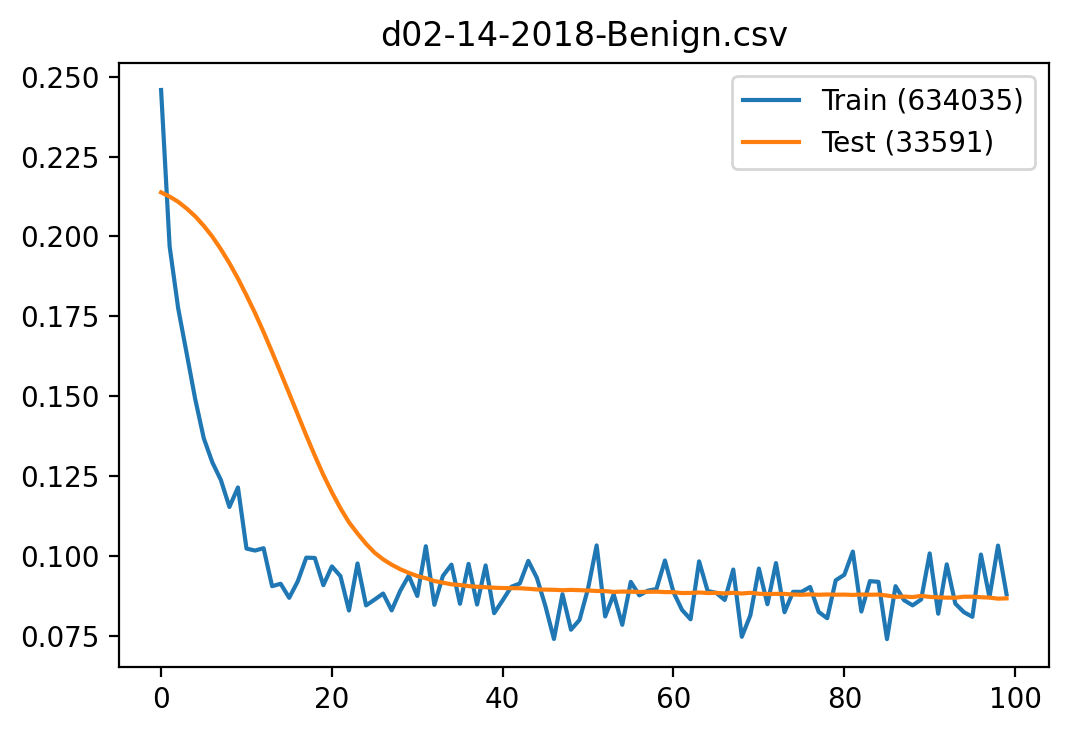

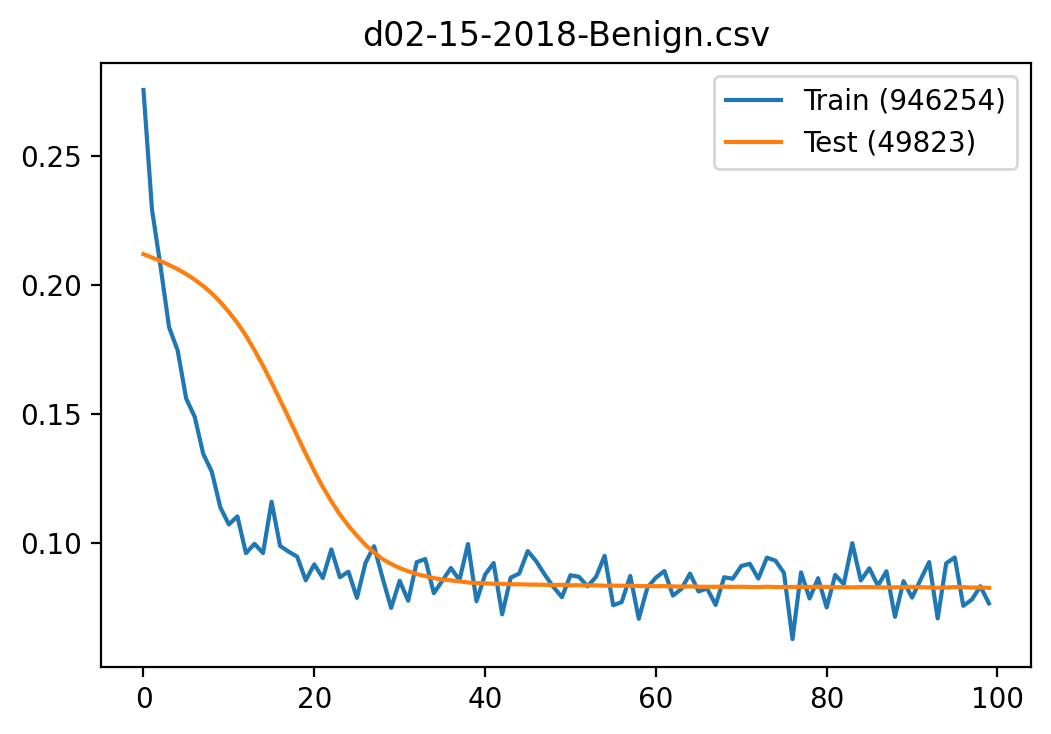

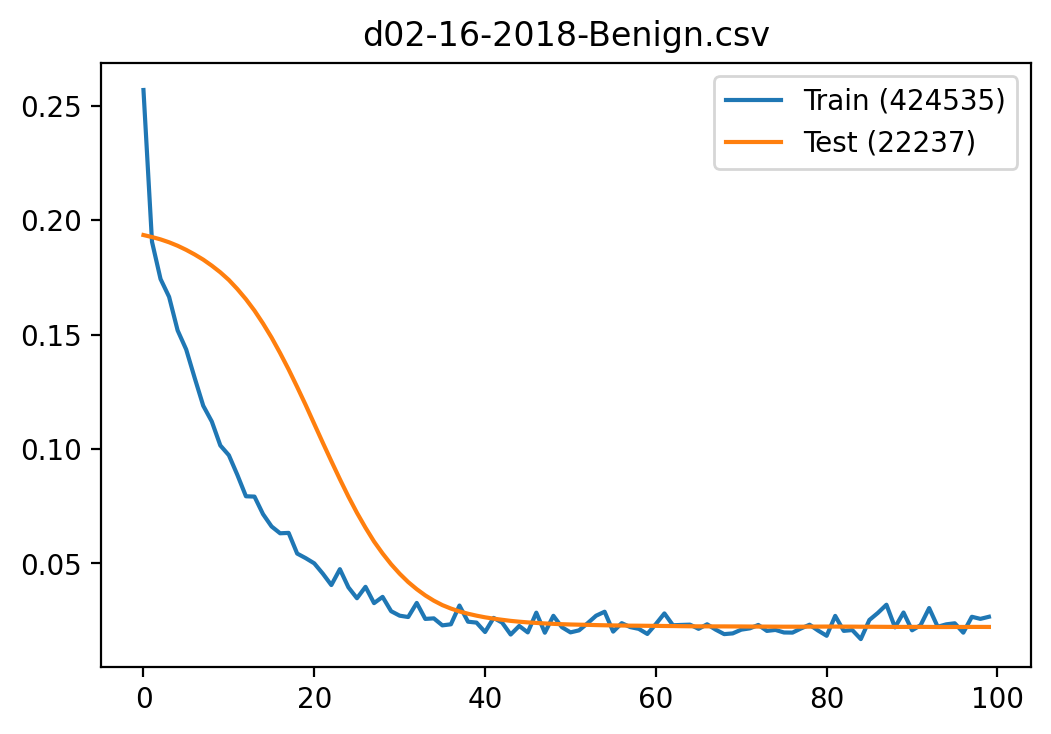

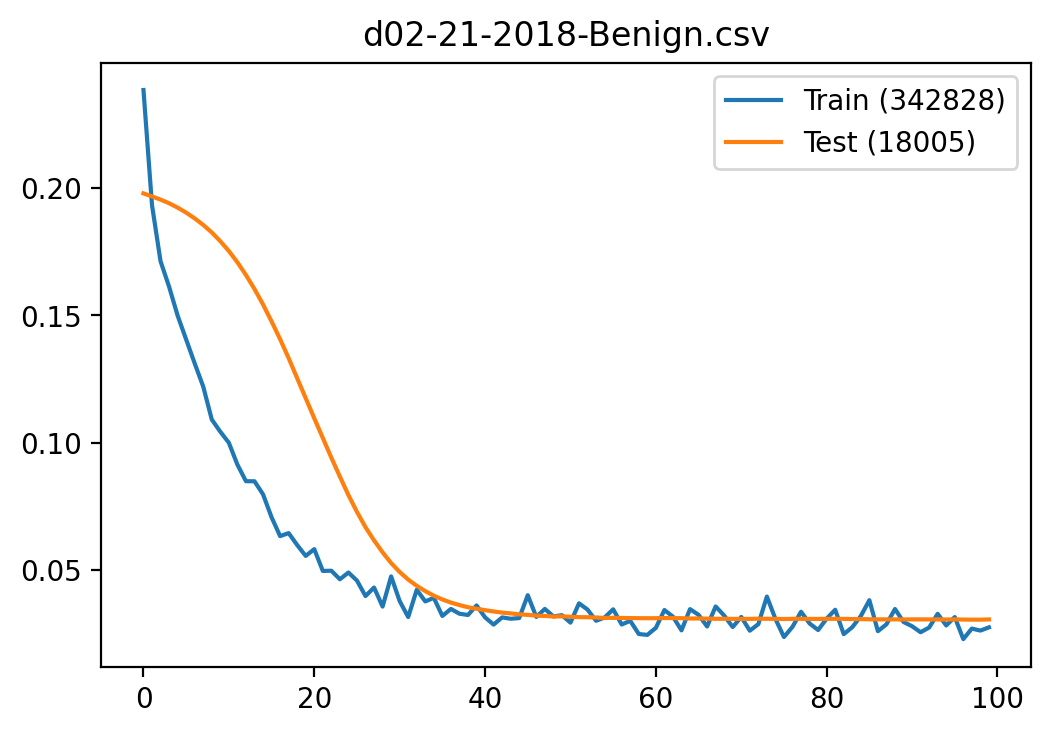

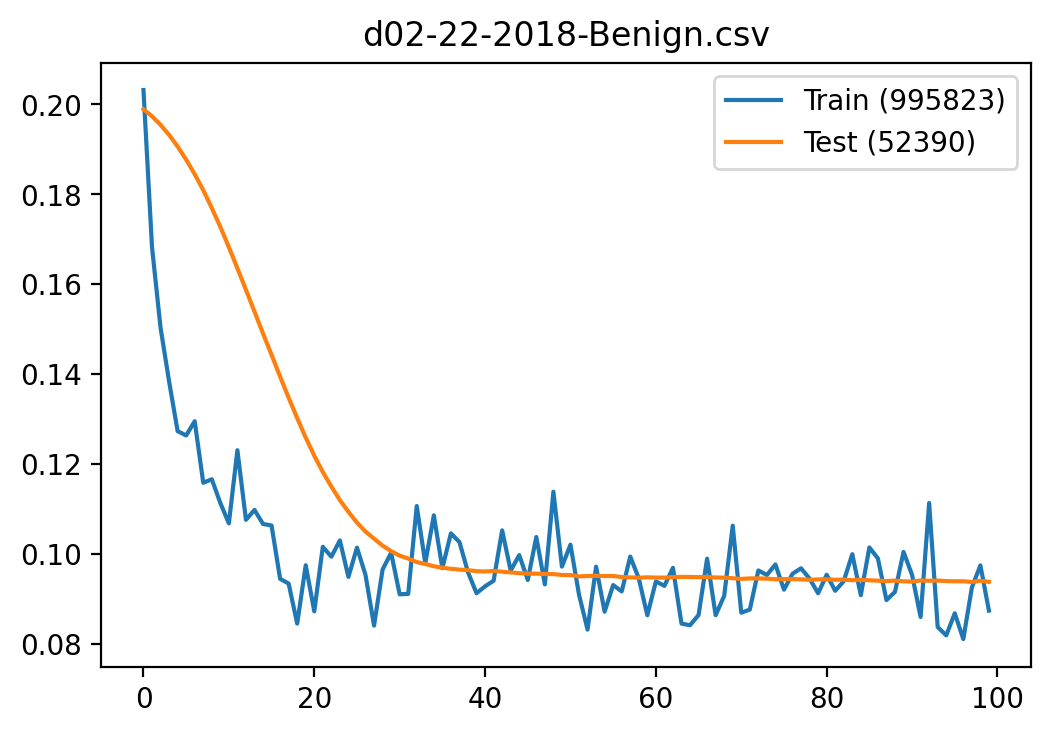

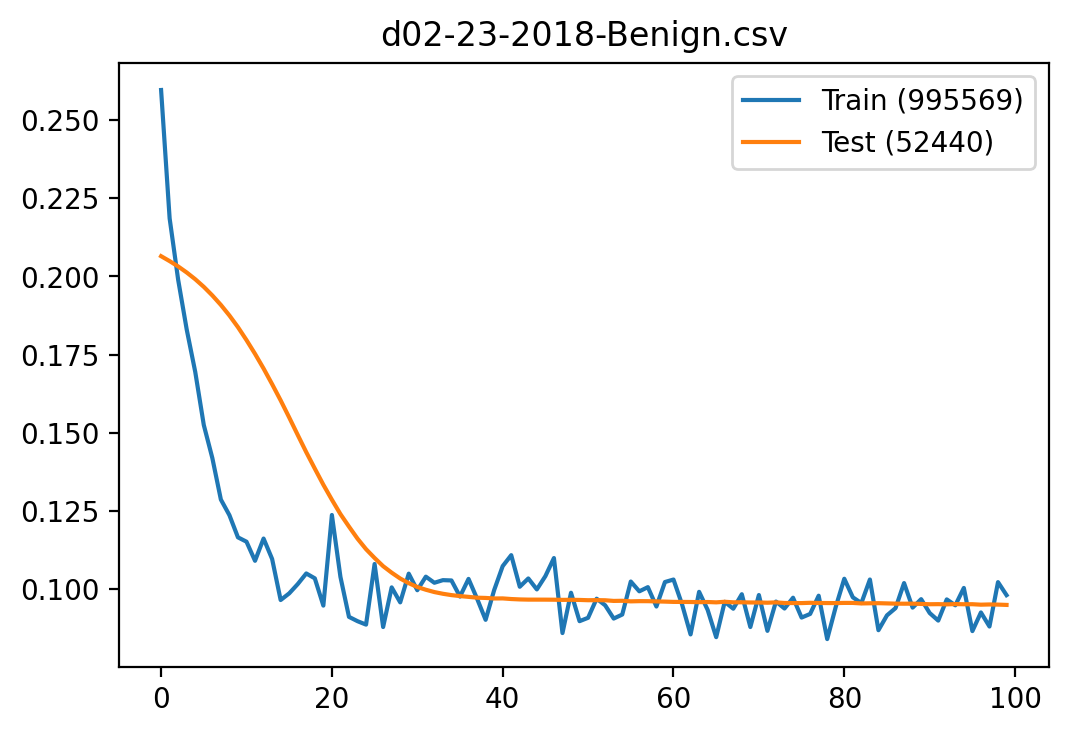

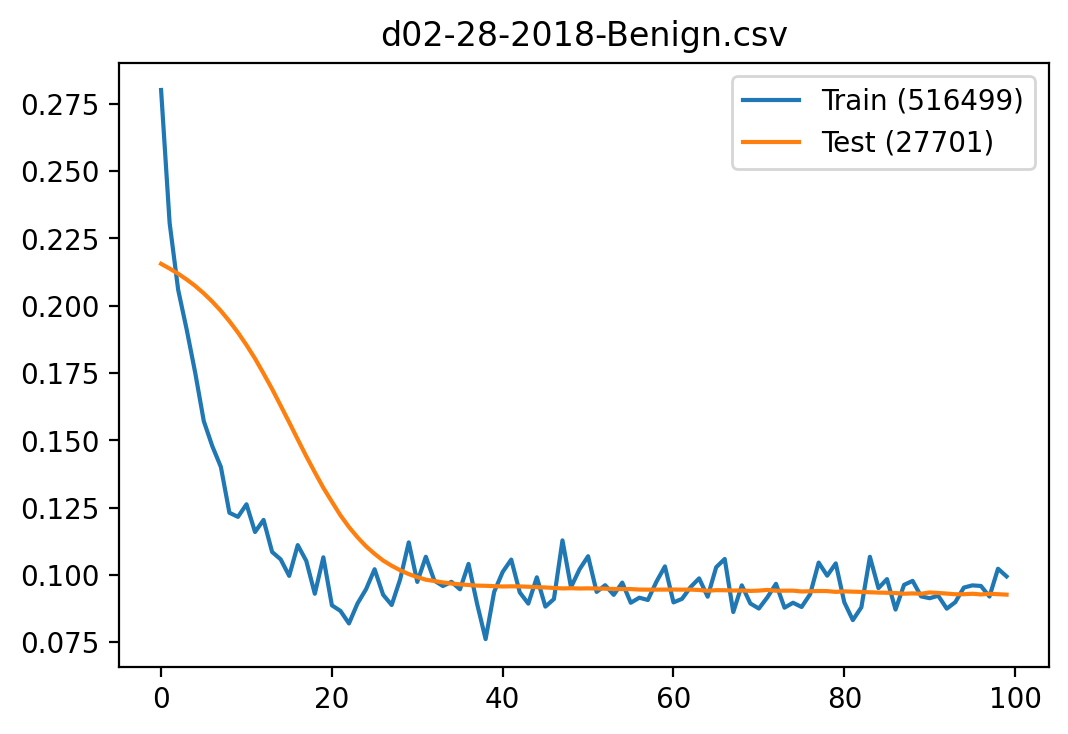

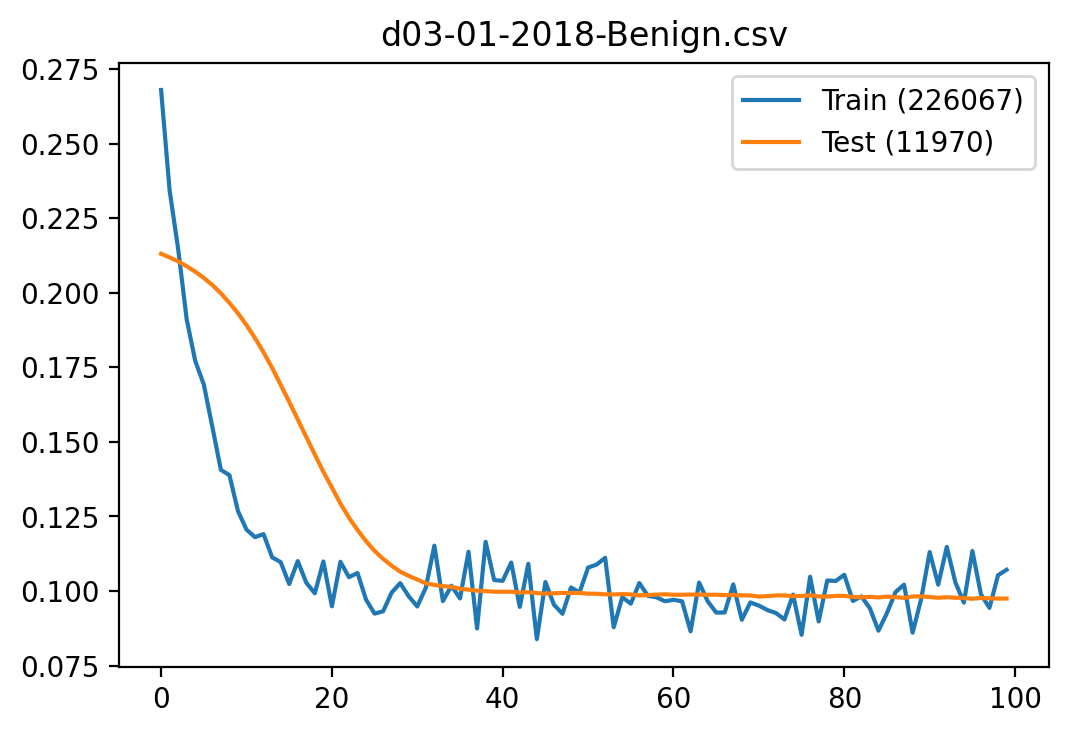

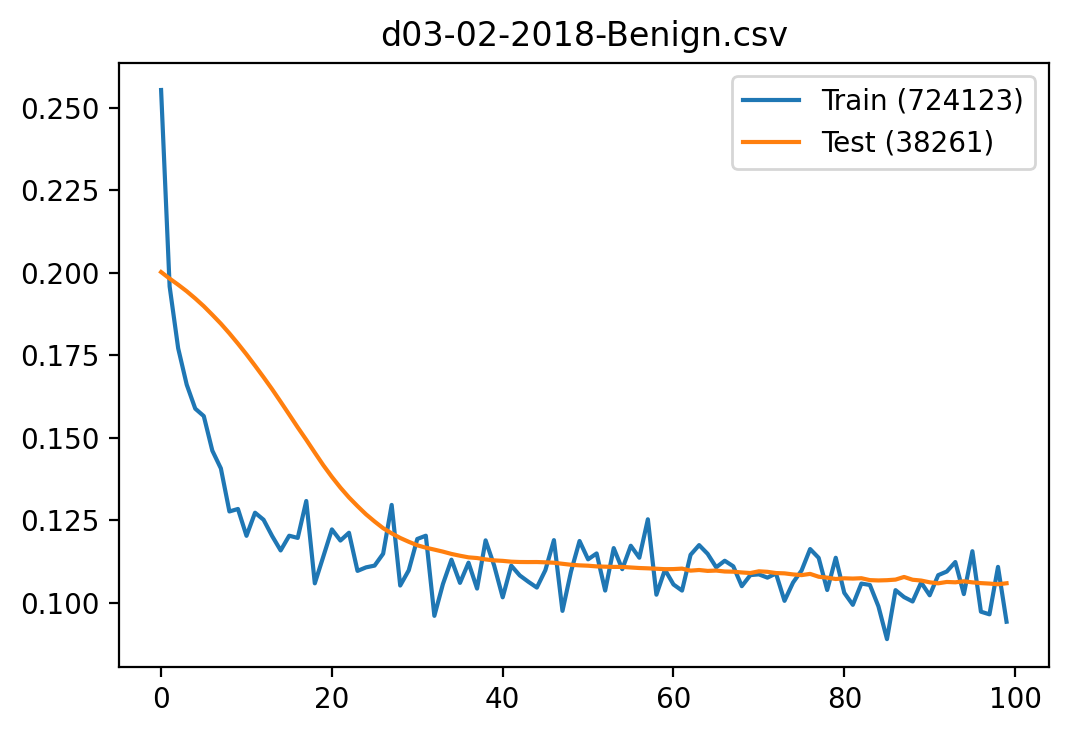

In [ ]:
train_models(CIC_2018_groups, 'benign', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, CIC_2018_dir)

### DoS
(CIC-IDS 2018)

Reading file ./CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-GoldenEye.csv
Training samples: 33140, Testing samples: 8368


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:13<00:00:00  7.26it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-15-2018-DoS attacks-GoldenEye.pt
Reading file ./CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv
Training samples: 8794, Testing samples: 2196


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:03<00:00:00  27.07it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-15-2018-DoS attacks-Slowloris.pt
Reading file ./CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
Training samples: 369687, Testing samples: 92225


  Iters     Elapsed Time      Speed                                             
 100/100  00:02:06<00:00:00  0.79it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-16-2018-DoS attacks-Hulk.pt
Reading file ./CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv
Training samples: 111707, Testing samples: 28183


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:39<00:00:00  2.52it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-16-2018-DoS attacks-SlowHTTPTest.pt


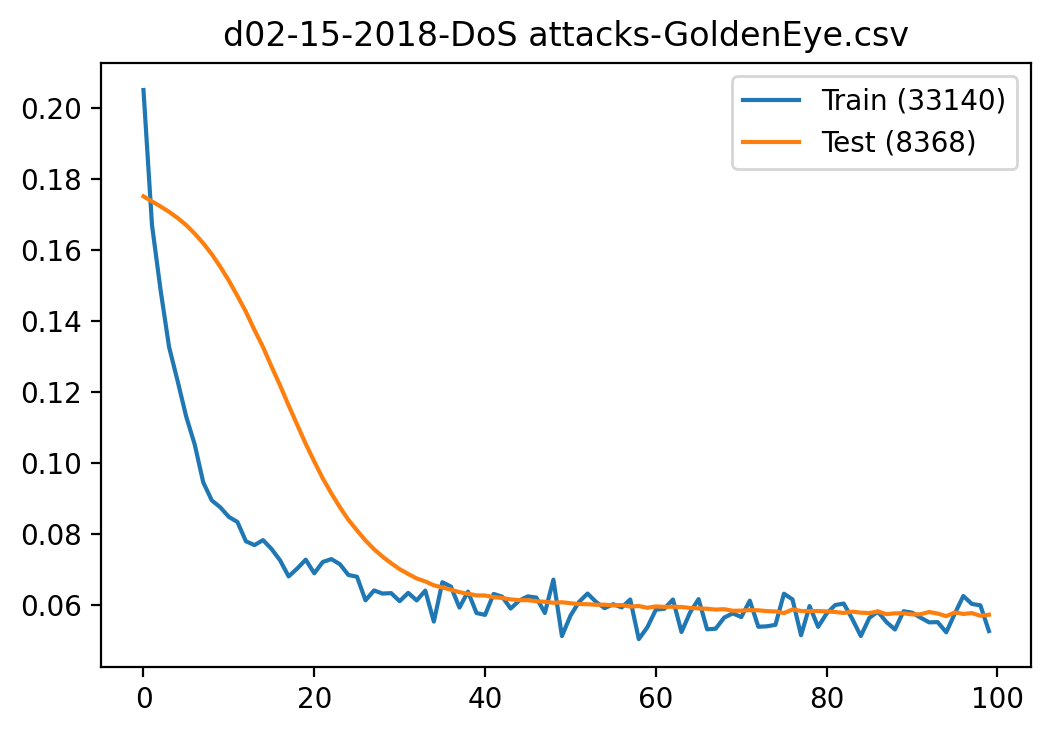

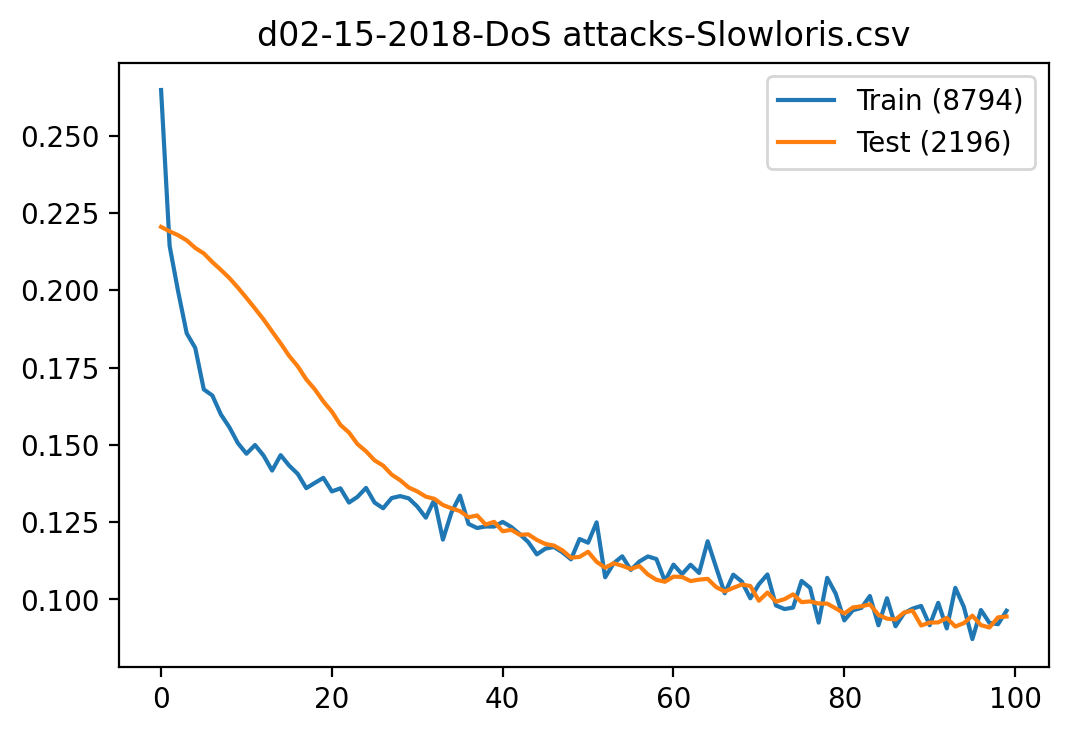

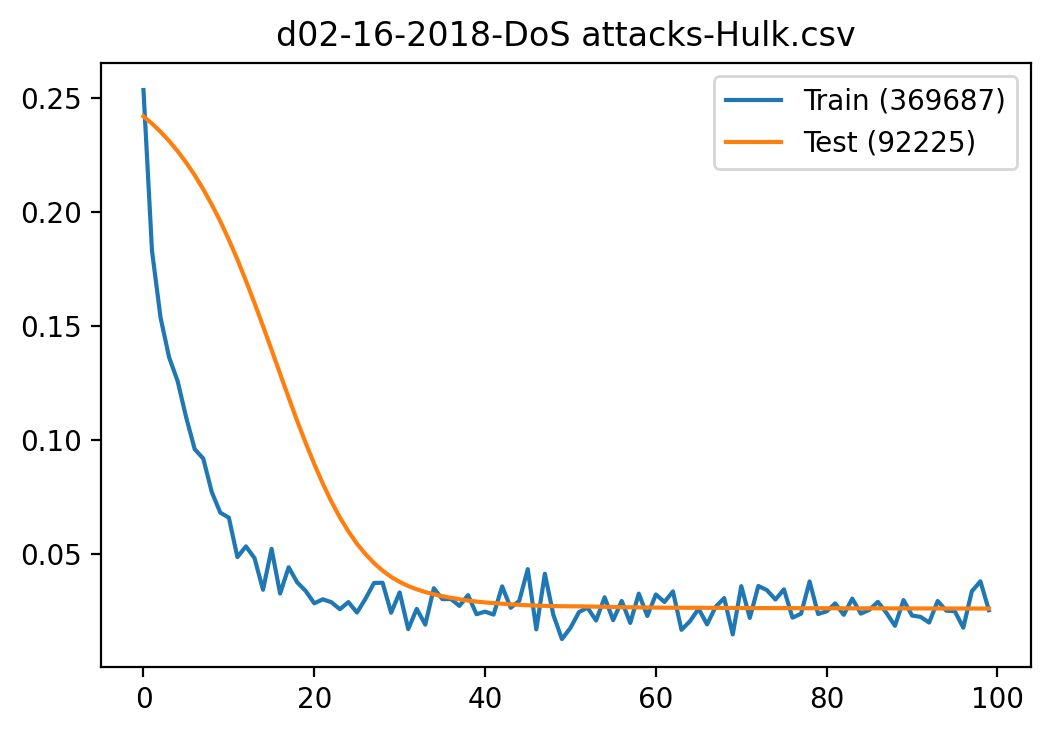

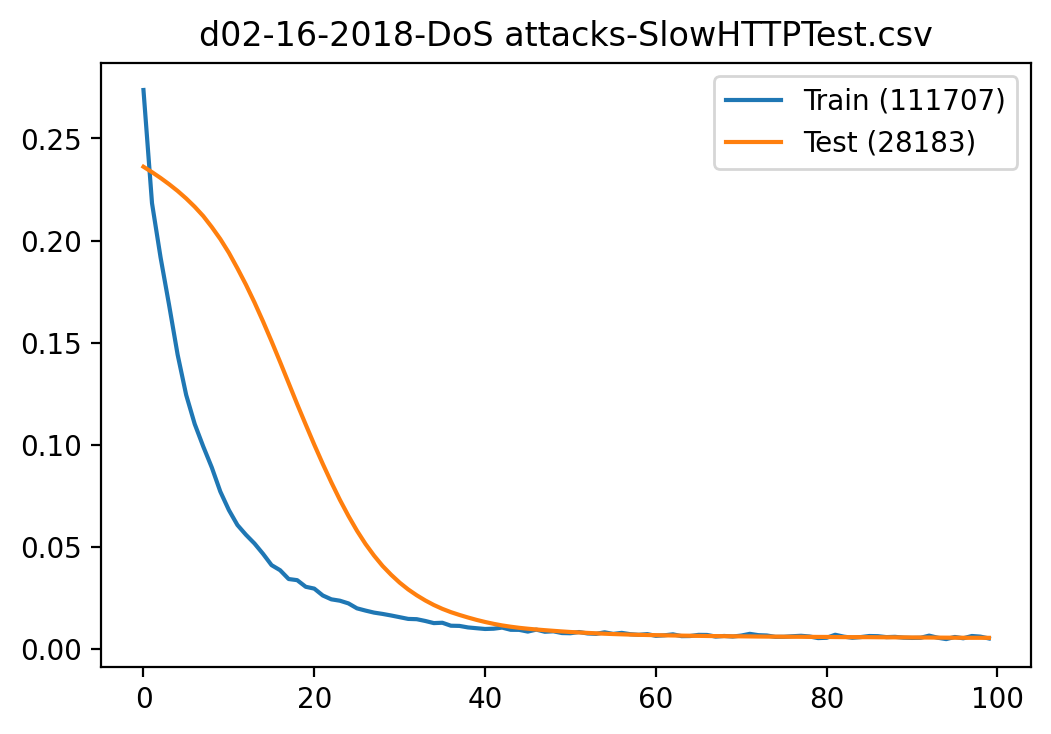

In [ ]:
train_models(CIC_2018_groups, 'DoS', learning_rate, latent_dim, KL_weight, epochs, batch_size, 0.8, workspace_dir, CIC_2018_dir)

### Web-Based
(CIC-IDS 2018)

Reading file ./CIC-IDS-2018/class_split/d02-22-2018-Brute Force -Web.csv
Training samples: 241, Testing samples: 8


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  101.99it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-22-2018-Brute Force -Web.pt
Reading file ./CIC-IDS-2018/class_split/d02-22-2018-Brute Force -XSS.csv
Training samples: 75, Testing samples: 4


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  121.29it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-22-2018-Brute Force -XSS.pt
Reading file ./CIC-IDS-2018/class_split/d02-22-2018-SQL Injection.csv
Training samples: 32, Testing samples: 2


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  130.55it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-22-2018-SQL Injection.pt
Reading file ./CIC-IDS-2018/class_split/d02-23-2018-Brute Force -Web.csv
Training samples: 347, Testing samples: 15


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  118.20it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-23-2018-Brute Force -Web.pt
Reading file ./CIC-IDS-2018/class_split/d02-23-2018-Brute Force -XSS.csv
Training samples: 146, Testing samples: 5


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  117.30it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-23-2018-Brute Force -XSS.pt
Reading file ./CIC-IDS-2018/class_split/d02-23-2018-SQL Injection.csv
Training samples: 50, Testing samples: 3


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  123.92it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/d02-23-2018-SQL Injection.pt


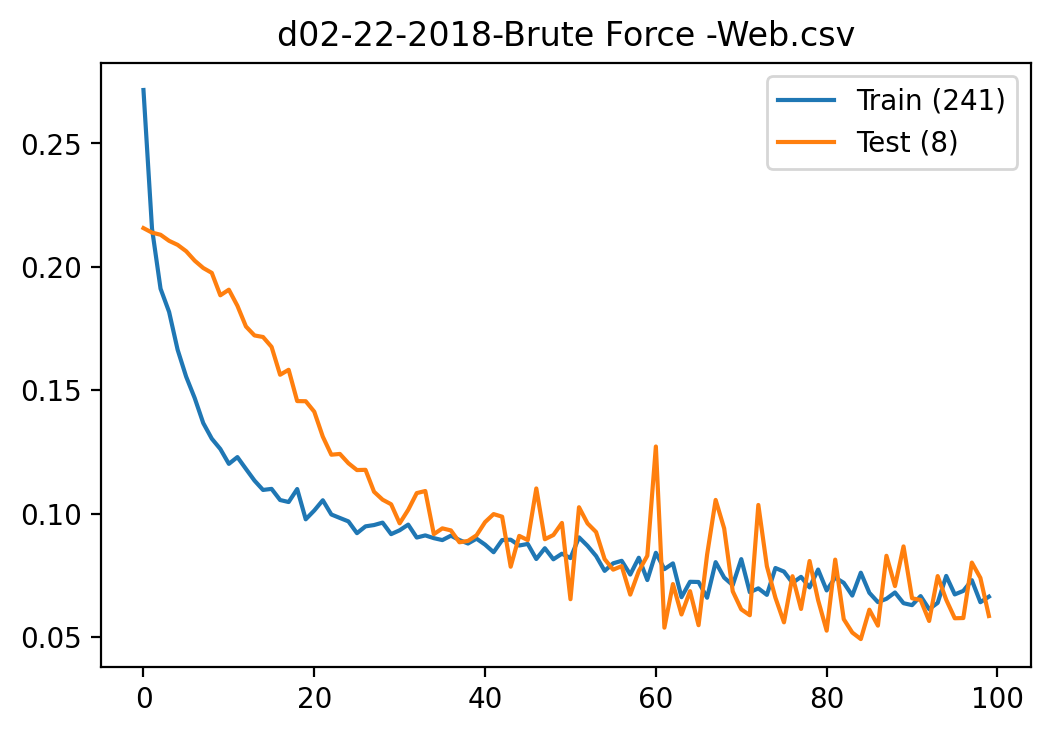

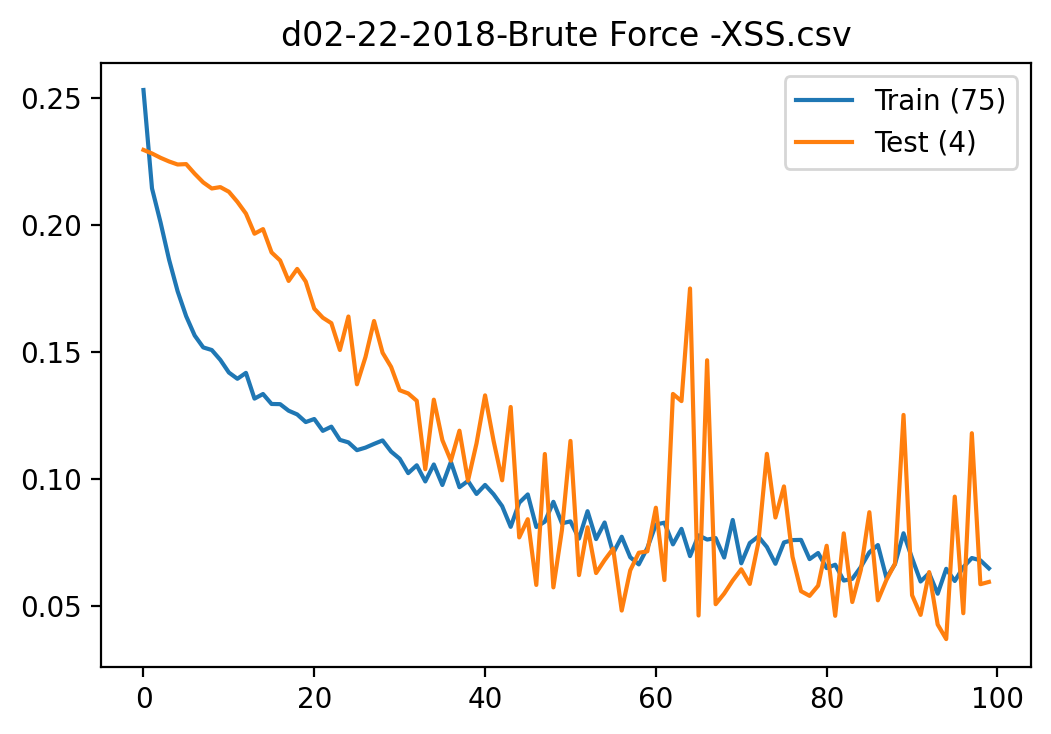

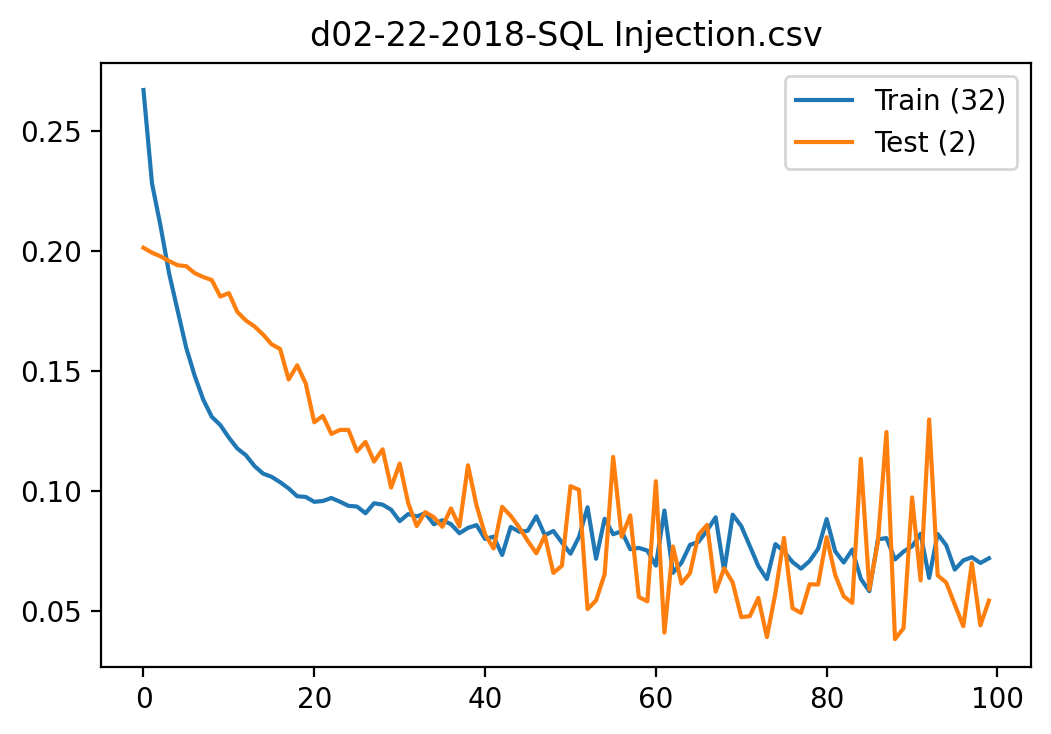

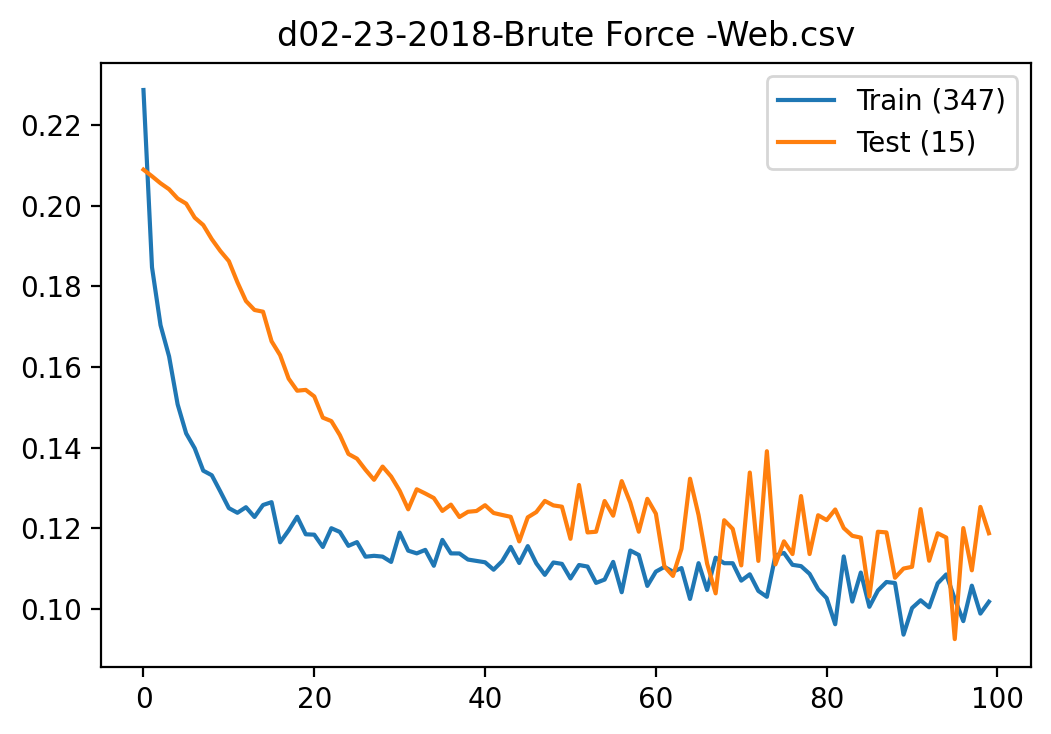

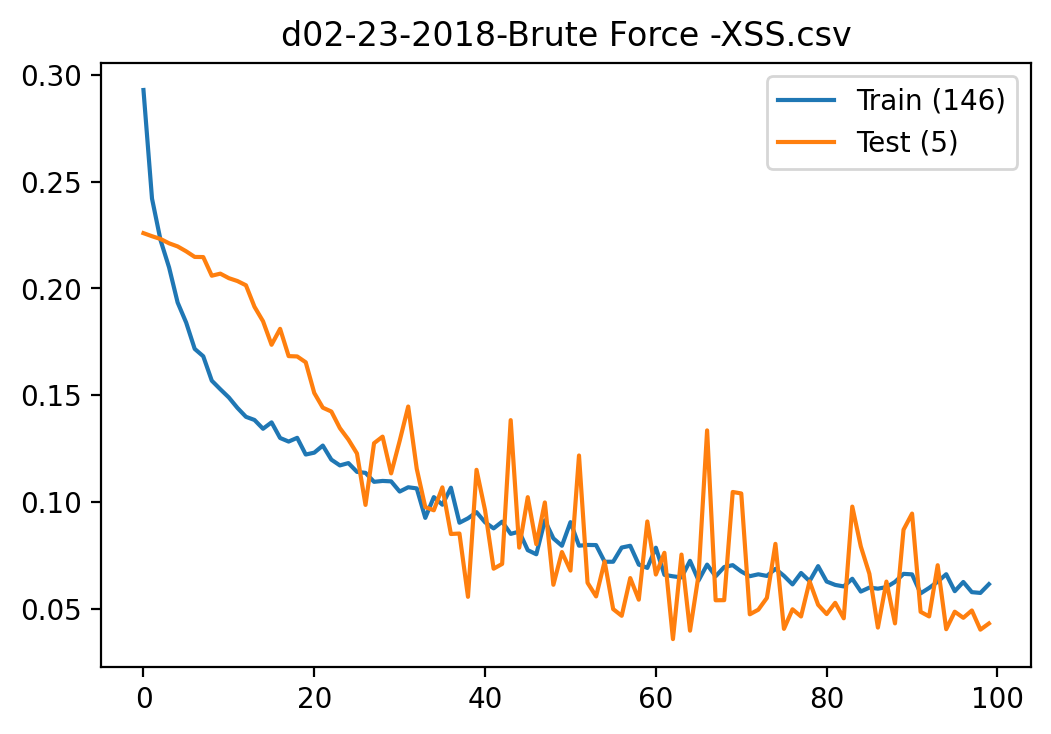

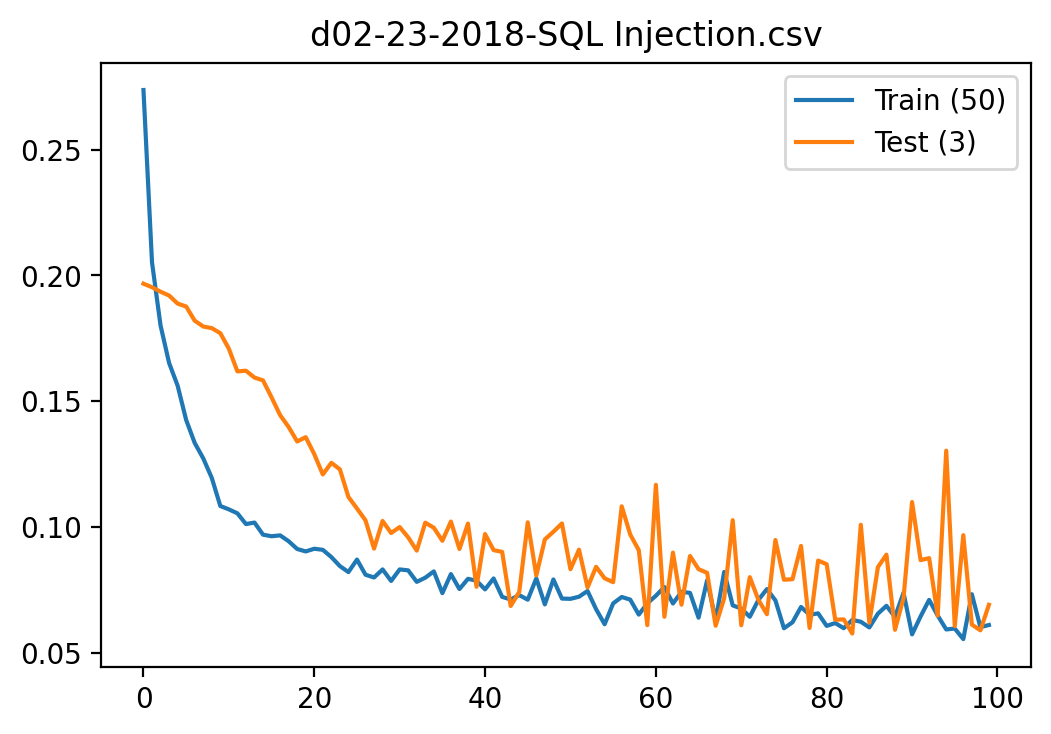

In [ ]:
train_models(CIC_2018_groups, 'web', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, CIC_2018_dir)

# CIC-IDS 2017

## Model Training

In [ ]:
learning_rate = 1e-3
epochs = 1
latent_dim = 5
KL_weight = 0.05
train_split = 0.9
batch_size=128

### Benign
(CIC-IDS 2017)

Reading file ./CIC-IDS-2017/class_split/daMonday-WorkingHours-BENIGN.csv
Training samples: 503429, Testing samples: 26489


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:38<00:00:00  2.57it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/daMonday-WorkingHours-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/dbTuesday-WorkingHours-BENIGN.csv
Training samples: 410542, Testing samples: 21532


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:32<00:00:00  3.06it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dbTuesday-WorkingHours-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/dcWednesday-workingHours-BENIGN.csv
Training samples: 417931, Testing samples: 22100


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:33<00:00:00  2.97it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dcWednesday-workingHours-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.csv
Training samples: 159656, Testing samples: 8530


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:14<00:00:00  7.10it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.csv
Training samples: 273995, Testing samples: 14571


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:23<00:00:00  4.27it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/dfFriday-WorkingHours-Morning-BENIGN.csv
Training samples: 179651, Testing samples: 9416


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:15<00:00:00  6.37it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dfFriday-WorkingHours-Morning-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/dgFriday-WorkingHours-Afternoon-DDos-BENIGN.csv
Training samples: 92869, Testing samples: 4849


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:08<00:00:00  11.94it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dgFriday-WorkingHours-Afternoon-DDos-BENIGN.pt
Reading file ./CIC-IDS-2017/class_split/dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.csv
Training samples: 121154, Testing samples: 6383


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:10<00:00:00  9.31it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.pt


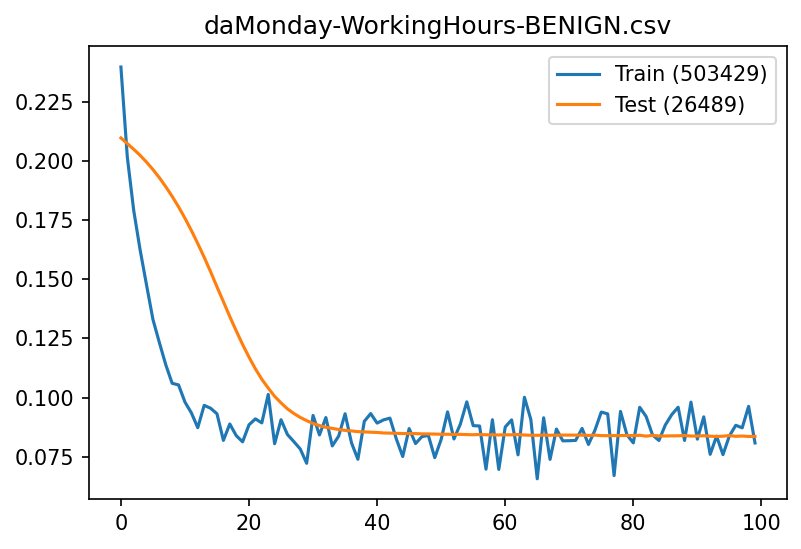

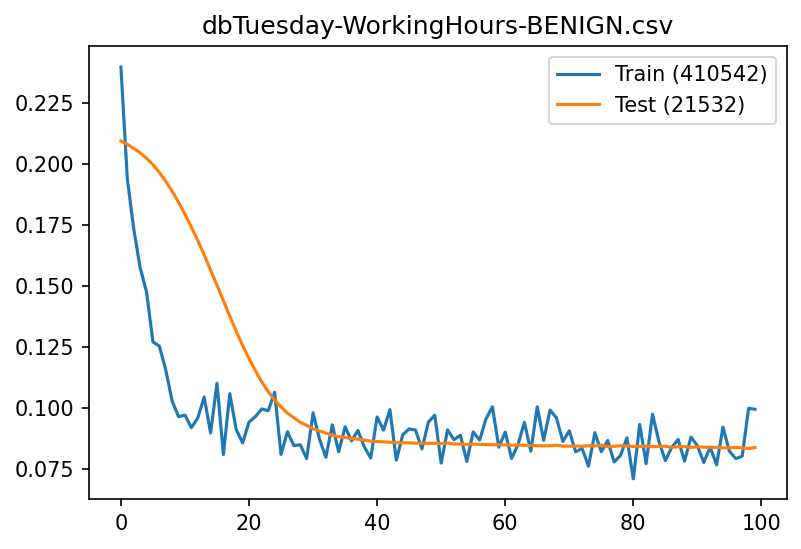

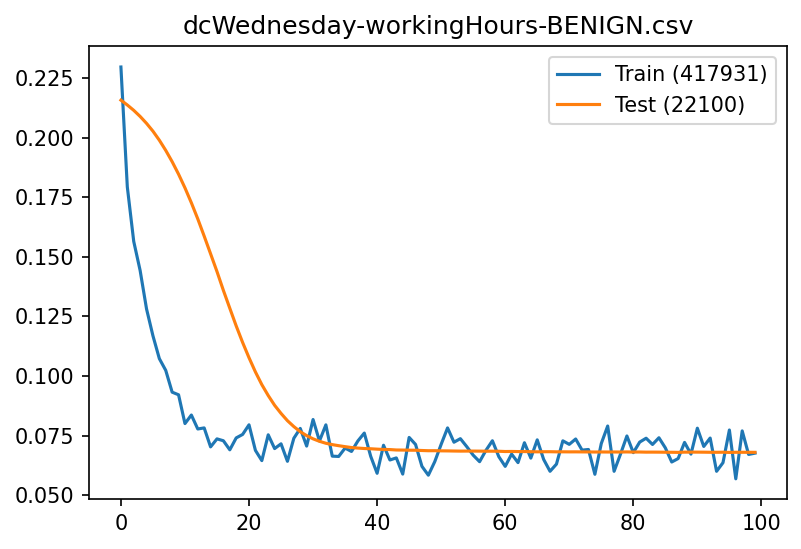

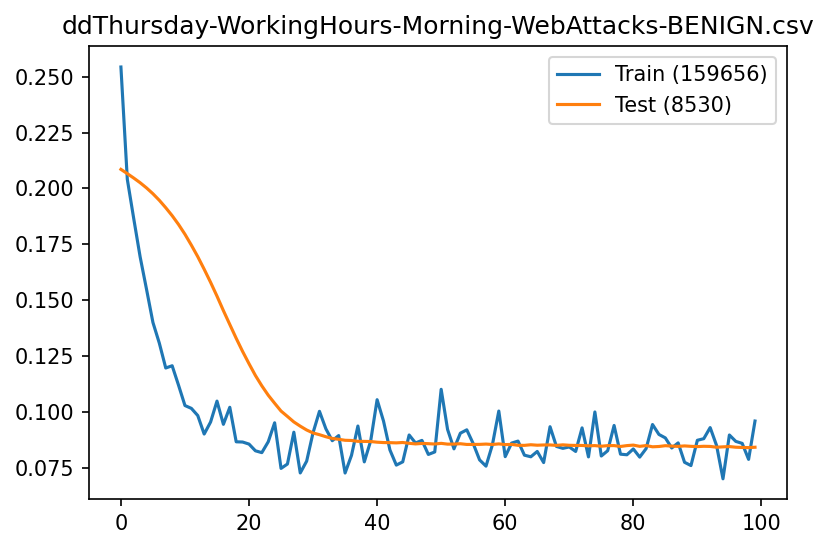

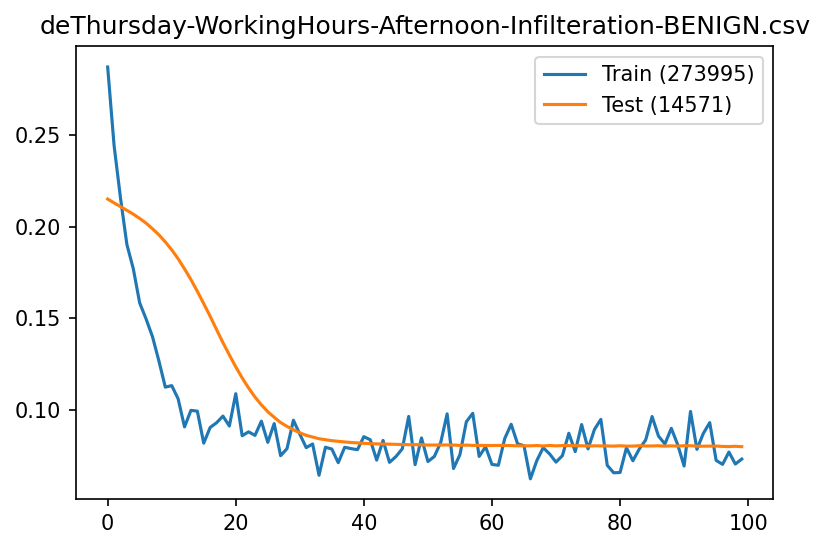

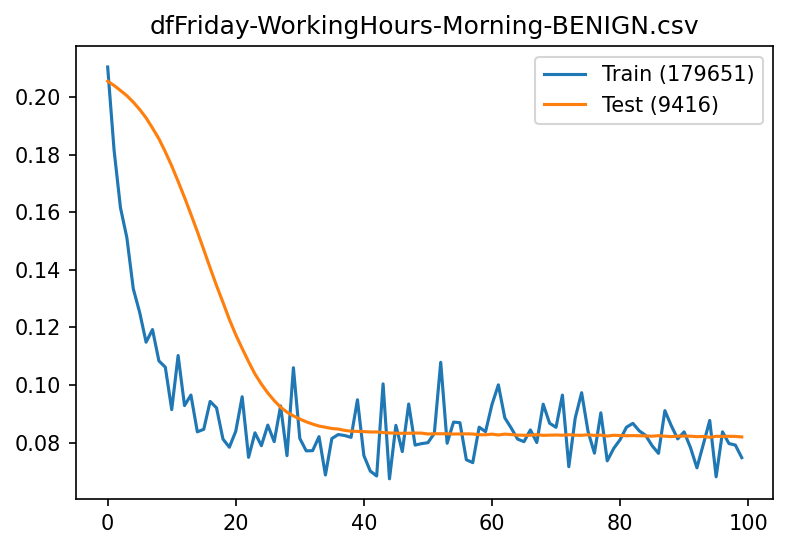

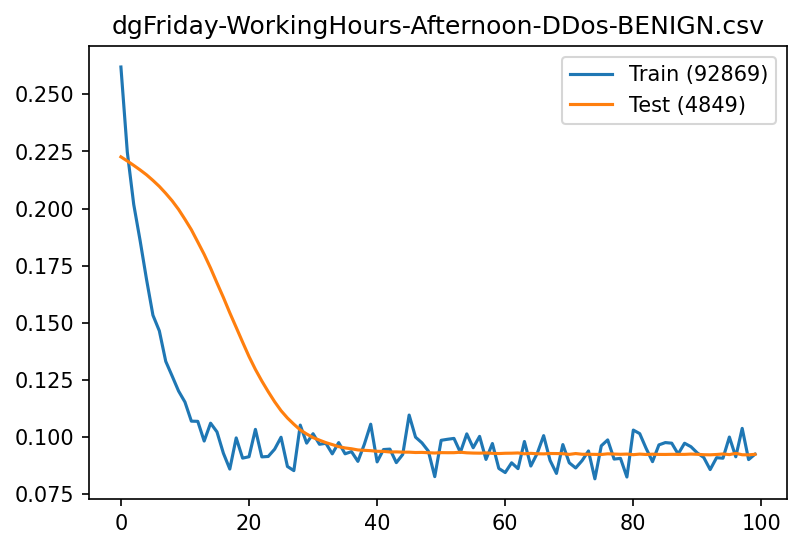

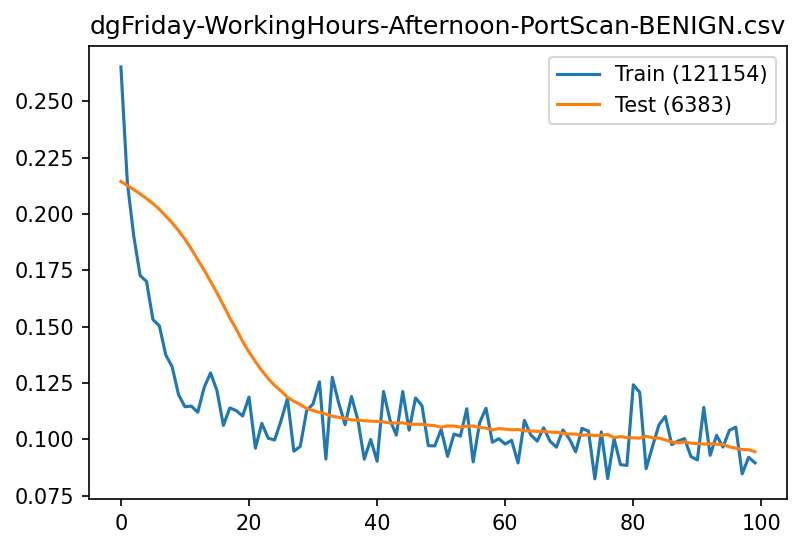

In [ ]:
train_models(CIC_2017_groups, 'benign', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, CIC_2017_dir)

### DoS
(CIC-IDS 2017)

Reading file ./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS GoldenEye.csv
Training samples: 9761, Testing samples: 532


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  63.73it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dcWednesday-workingHours-DoS GoldenEye.pt
Reading file ./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
Training samples: 219567, Testing samples: 11506


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:18<00:00:00  5.41it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dcWednesday-workingHours-DoS Hulk.pt
Reading file ./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv
Training samples: 5217, Testing samples: 282


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  81.04it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dcWednesday-workingHours-DoS Slowhttptest.pt
Reading file ./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv
Training samples: 5507, Testing samples: 289


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  84.71it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/dcWednesday-workingHours-DoS slowloris.pt


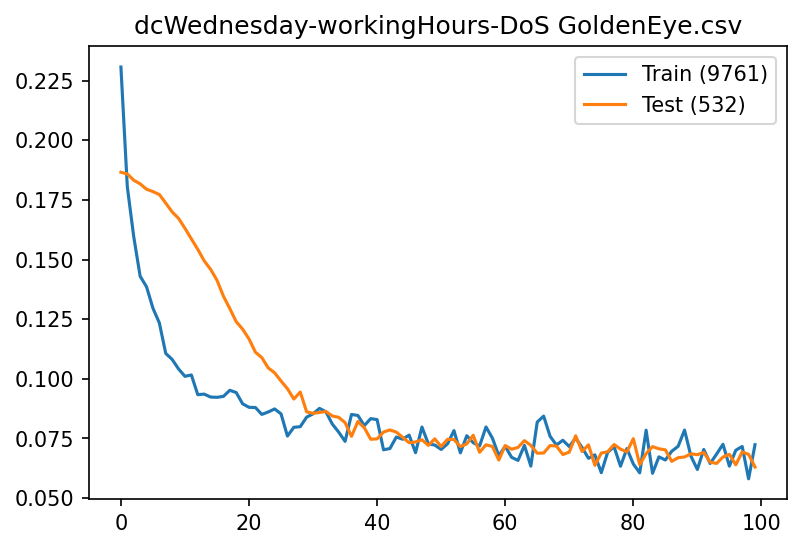

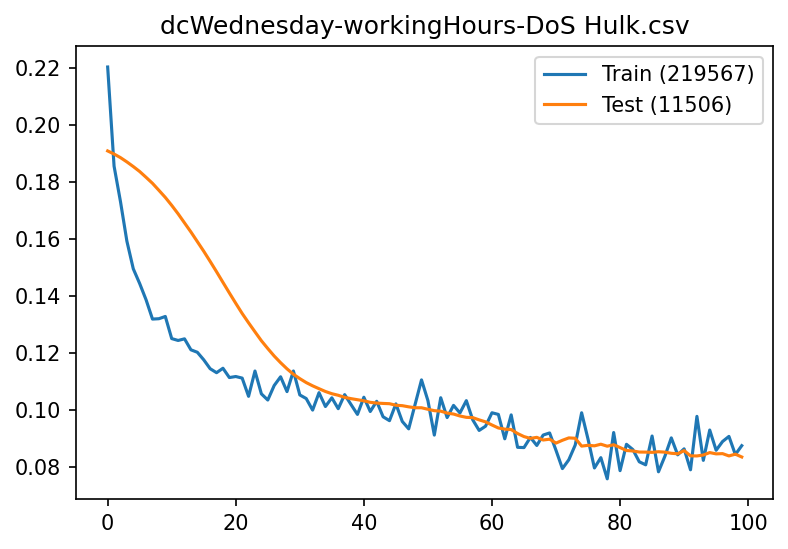

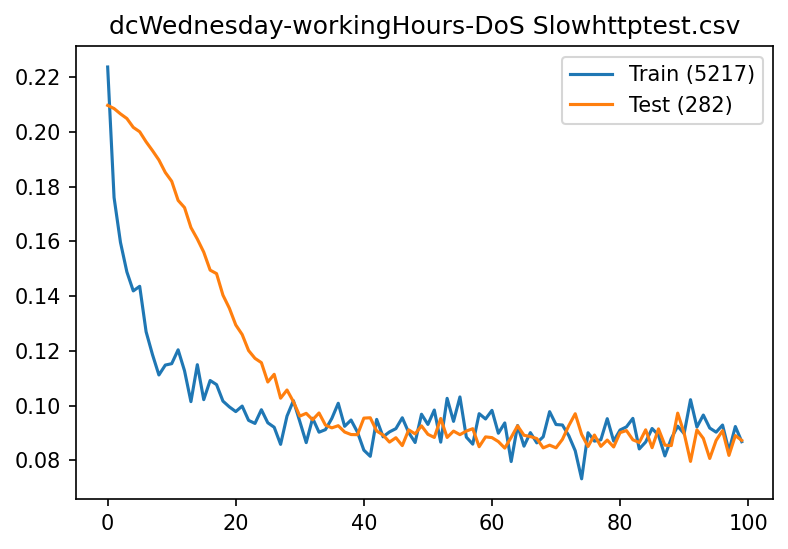

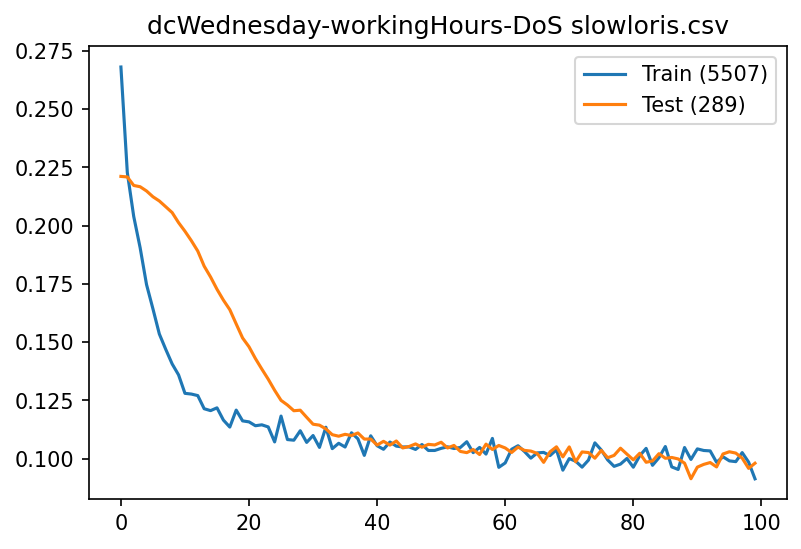

In [ ]:
train_models(CIC_2017_groups, 'DoS', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, CIC_2017_dir)

### Web-Based
(CIC-IDS 2017)

Reading file ./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.csv
Training samples: 1190, Testing samples: 317


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  75.79it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.pt
Reading file ./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.csv
Training samples: 14, Testing samples: 7


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  127.71it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.pt
Reading file ./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.csv
Training samples: 511, Testing samples: 141


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  98.23it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.pt


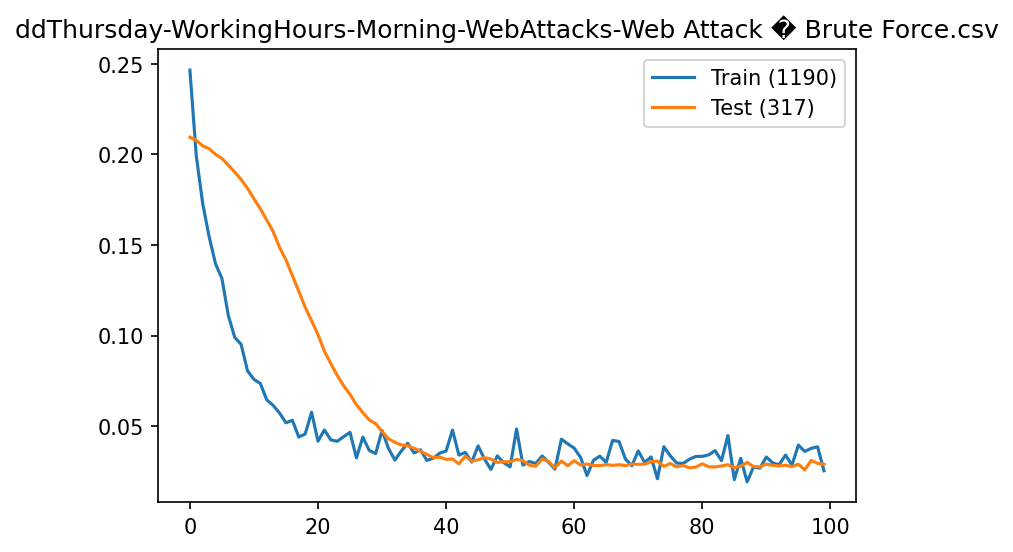

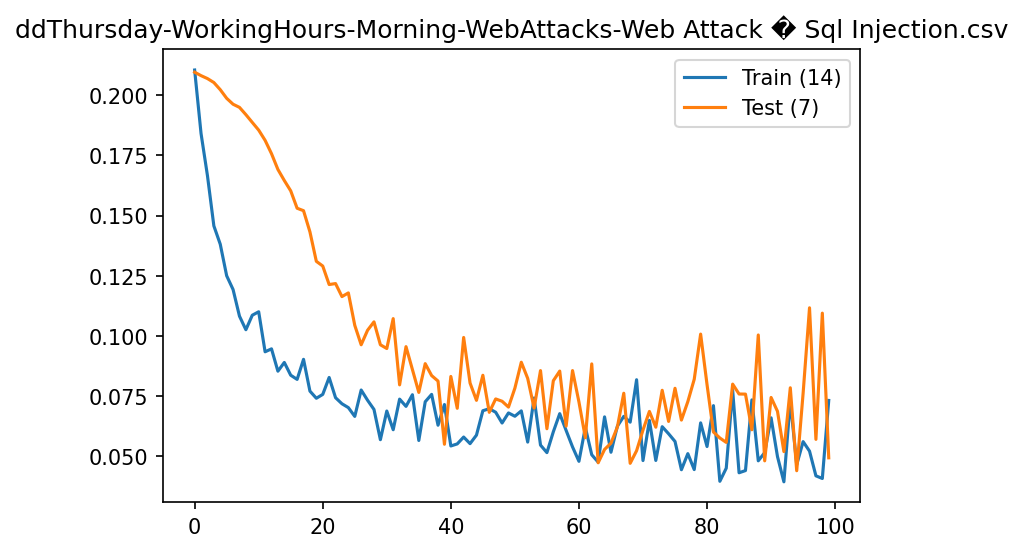

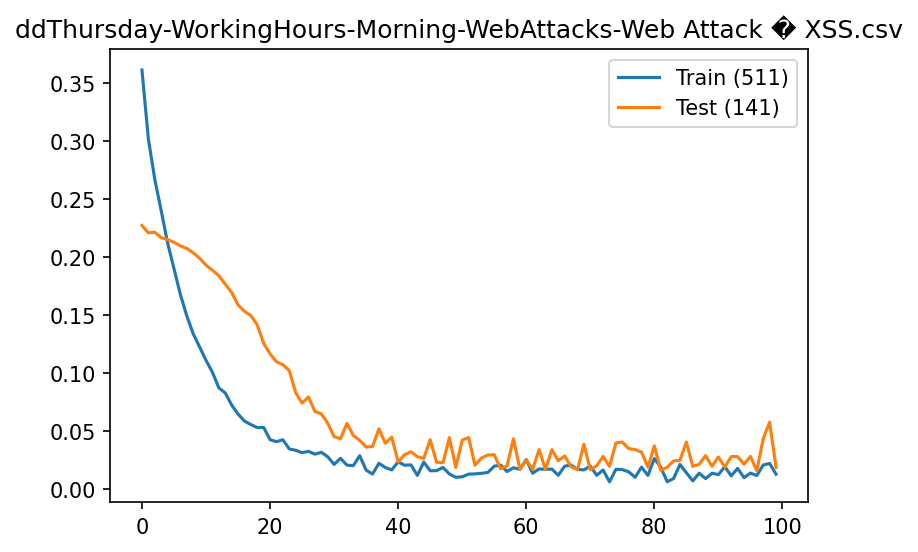

In [ ]:
train_models(CIC_2017_groups, 'web', learning_rate, latent_dim, KL_weight, epochs, batch_size, 0.8, workspace_dir, CIC_2017_dir)

# USB-IDS

## Model Training

In [ ]:
learning_rate = 1e-3
epochs = 1
latent_dim = 5
KL_weight = 0.05
train_split = 0.9
batch_size=128

### Benign
(USB-IDS)

Reading file ./USB-IDS/class_split/REGULAR-BENIGN.csv
Training samples: 290898, Testing samples: 15023


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:23<00:00:00  4.22it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/REGULAR-BENIGN.pt


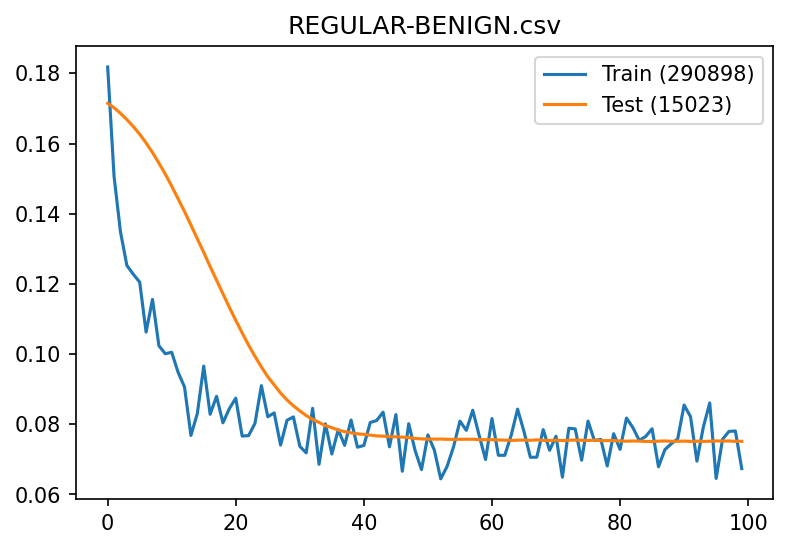

In [ ]:
train_models(USB_IDS_groups, 'benign', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, USB_dir)

### Hulk
(USB-IDS)

Reading file ./USB-IDS/class_split/Hulk-Evasive-Hulk-Evasive.csv
Training samples: 719072, Testing samples: 37915


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:53<00:00:00  1.85it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Hulk-Evasive-Hulk-Evasive.pt
Reading file ./USB-IDS/class_split/Hulk-NoDefense-Hulk-NoDefense.csv
Training samples: 808574, Testing samples: 42558


  Iters     Elapsed Time      Speed                                             
 100/100  00:01:00<00:00:00  1.65it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Hulk-NoDefense-Hulk-NoDefense.pt
Reading file ./USB-IDS/class_split/Hulk-Reqtimeout-Hulk-Reqtimeout.csv
Training samples: 813297, Testing samples: 42334


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:59<00:00:00  1.67it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Hulk-Reqtimeout-Hulk-Reqtimeout.pt
Reading file ./USB-IDS/class_split/Hulk-Security2-Hulk-Security2.csv
Training samples: 772792, Testing samples: 40256


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:57<00:00:00  1.75it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Hulk-Security2-Hulk-Security2.pt


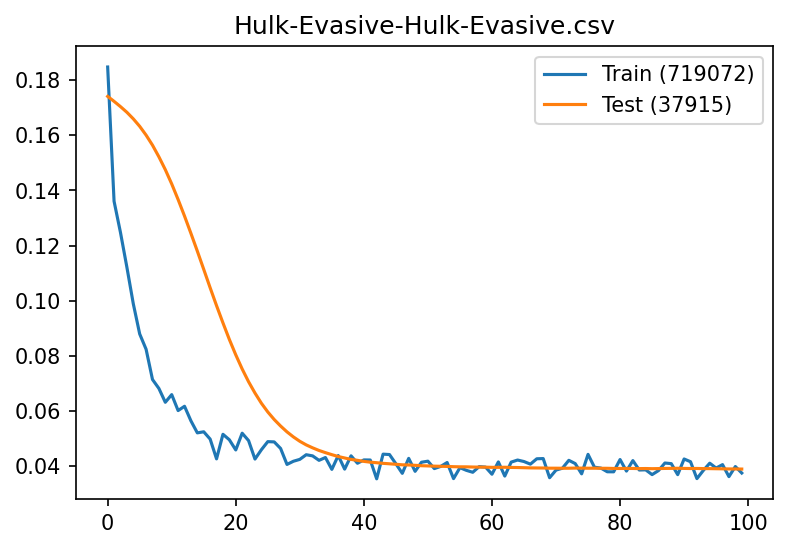

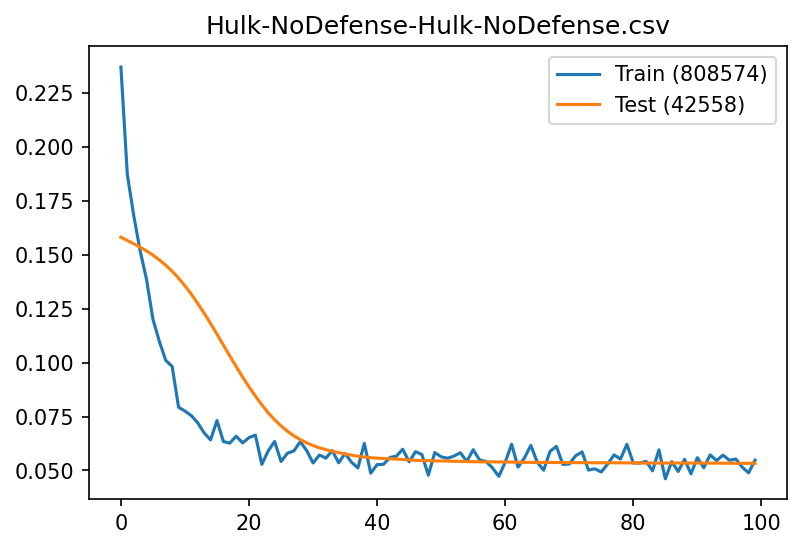

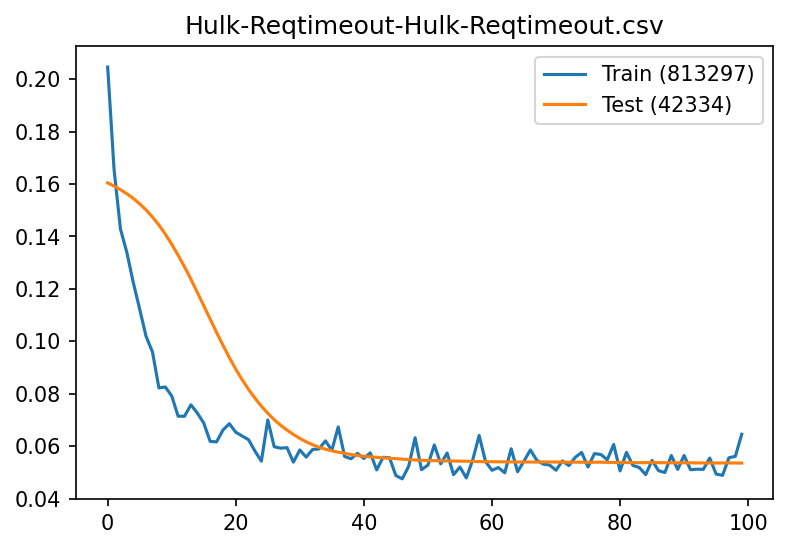

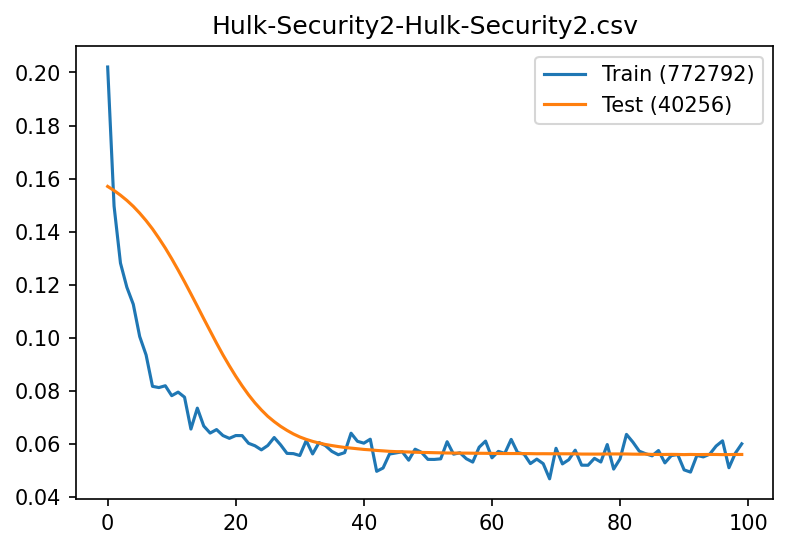

In [ ]:
train_models(USB_IDS_groups, 'hulk', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, USB_dir)

### SlowHTTPtest
(USB-IDS)

Reading file ./USB-IDS/class_split/Slowhttptest-Evasive-Slowhttptest-Evasive.csv
Training samples: 6351, Testing samples: 341


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  80.00it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowhttptest-Evasive-Slowhttptest-Evasive.pt
Reading file ./USB-IDS/class_split/Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv
Training samples: 6336, Testing samples: 356


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  81.60it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowhttptest-NoDefense-Slowhttptest-NoDefense.pt
Reading file ./USB-IDS/class_split/Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv
Training samples: 5468, Testing samples: 287


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  83.68it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.pt
Reading file ./USB-IDS/class_split/Slowhttptest-Security2-Slowhttptest-Security2.csv
Training samples: 6324, Testing samples: 364


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  84.53it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowhttptest-Security2-Slowhttptest-Security2.pt


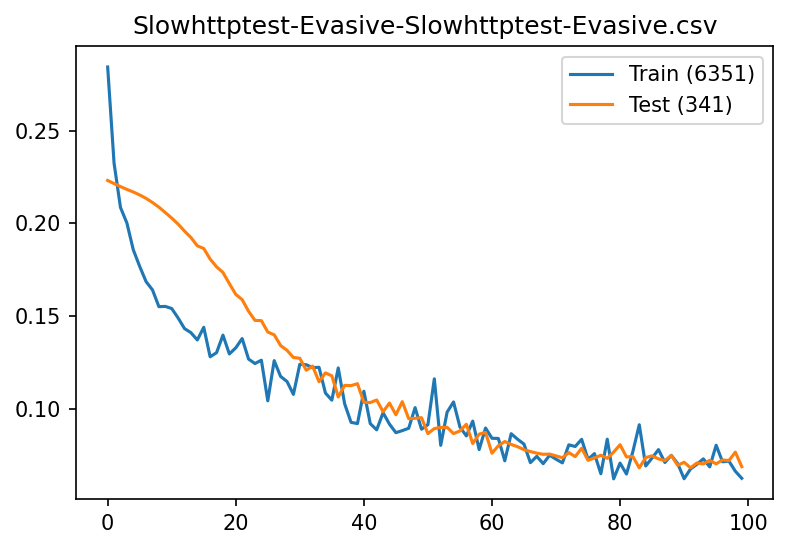

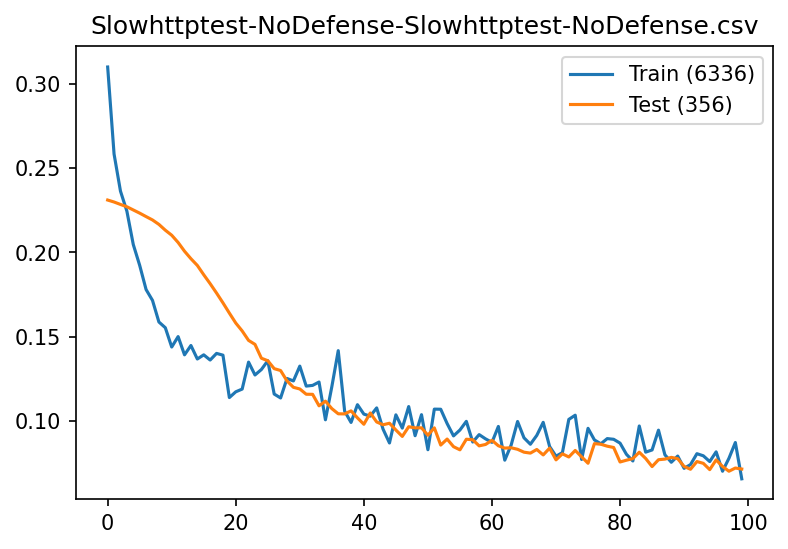

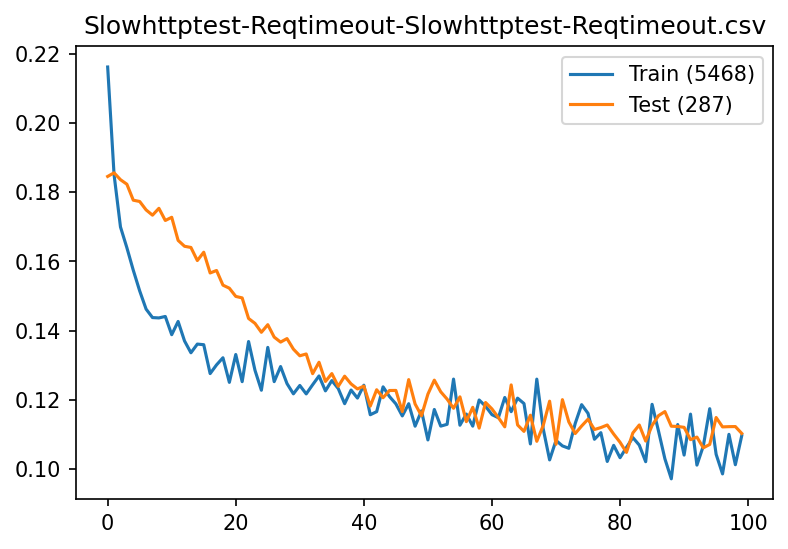

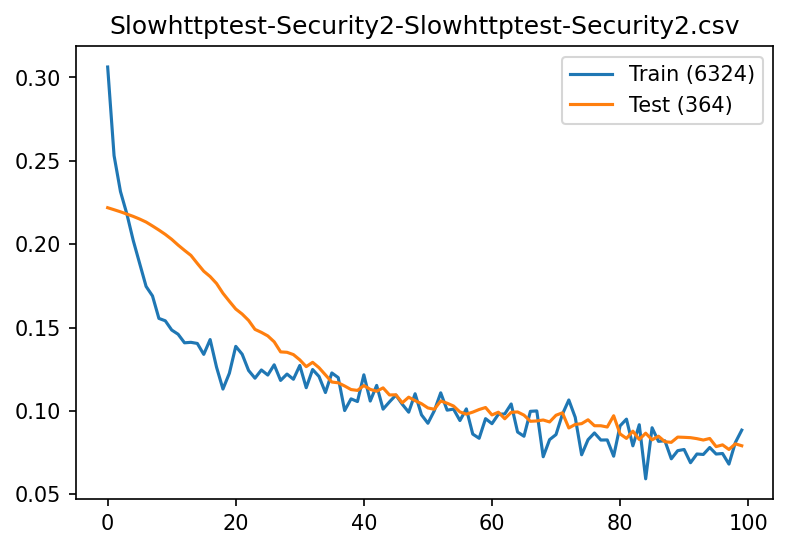

In [ ]:
train_models(USB_IDS_groups, 'slowhttptest', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, USB_dir)

### Slowloris
(USB-IDS)

Reading file ./USB-IDS/class_split/Slowloris-Evasive-Slowloris-Evasive.csv
Training samples: 1711, Testing samples: 71


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  100.25it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowloris-Evasive-Slowloris-Evasive.pt
Reading file ./USB-IDS/class_split/Slowloris-NoDefense-Slowloris-NoDefense.csv
Training samples: 1680, Testing samples: 103


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  112.87it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowloris-NoDefense-Slowloris-NoDefense.pt
Reading file ./USB-IDS/class_split/Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv
Training samples: 6469, Testing samples: 313


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  82.34it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowloris-Reqtimeout-Slowloris-Reqtimeout.pt
Reading file ./USB-IDS/class_split/Slowloris-Security2-Slowloris-Security2.csv
Training samples: 1698, Testing samples: 84


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  115.21it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowloris-Security2-Slowloris-Security2.pt


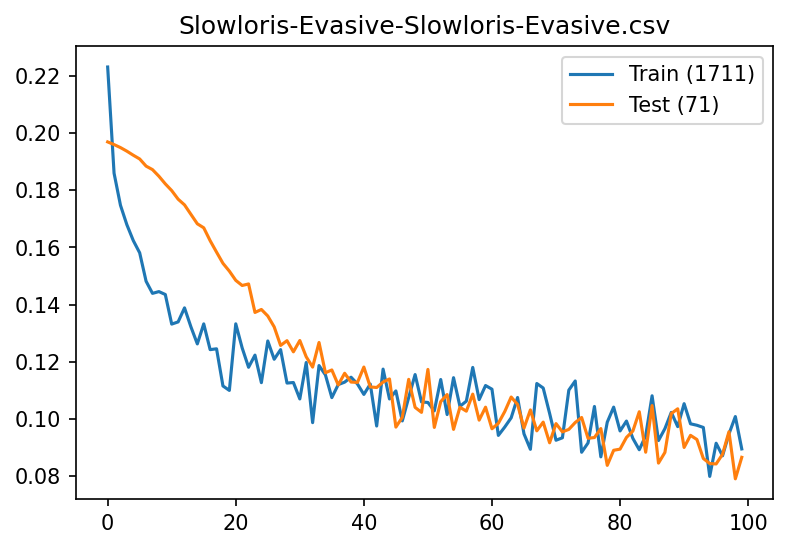

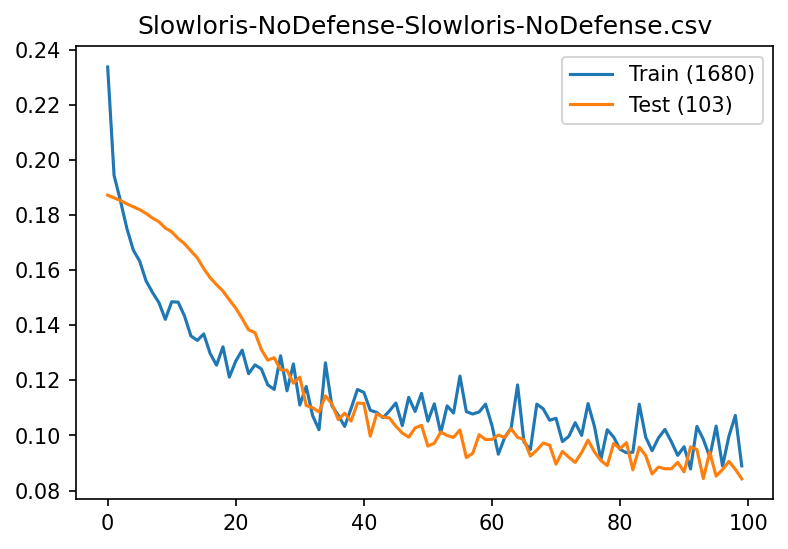

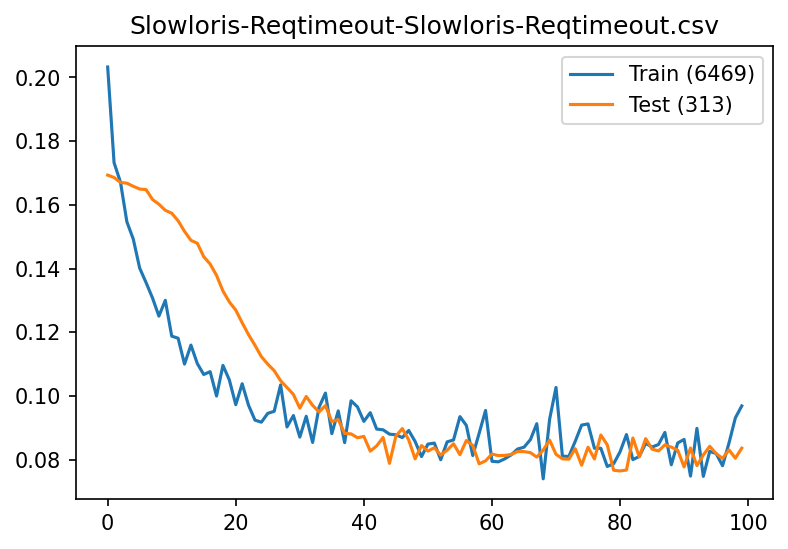

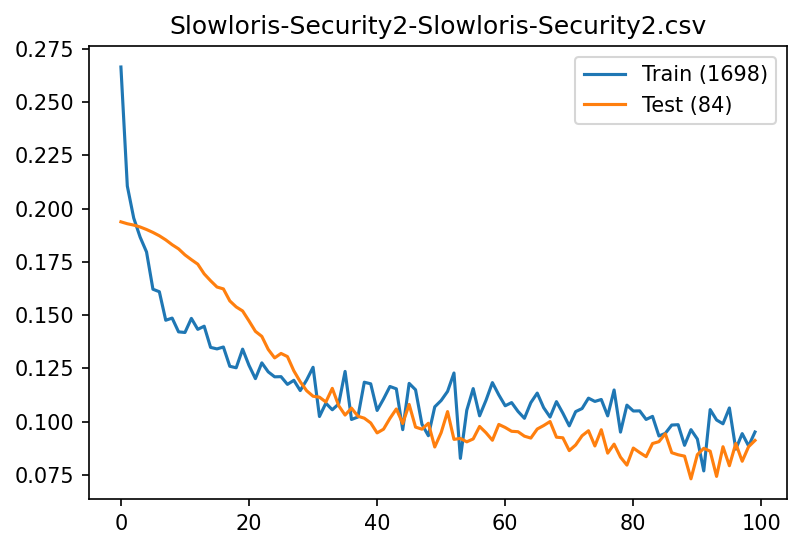

In [ ]:
train_models(USB_IDS_groups, 'slowloris', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, USB_dir)

### TCPFlood
(USB-IDS)

Reading file ./USB-IDS/class_split/TCPFlood-Evasive-TCPFlood-Evasive.csv
Training samples: 287579, Testing samples: 14994


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:23<00:00:00  4.20it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/TCPFlood-Evasive-TCPFlood-Evasive.pt
Reading file ./USB-IDS/class_split/TCPFlood-NoDefense-TCPFlood-NoDefense.csv
Training samples: 277166, Testing samples: 14555


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:23<00:00:00  4.20it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/TCPFlood-NoDefense-TCPFlood-NoDefense.pt
Reading file ./USB-IDS/class_split/TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv
Training samples: 287268, Testing samples: 15419


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:25<00:00:00  3.97it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.pt
Reading file ./USB-IDS/class_split/TCPFlood-Security2-TCPFlood-Security2.csv
Training samples: 282271, Testing samples: 14673


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:23<00:00:00  4.24it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/TCPFlood-Security2-TCPFlood-Security2.pt


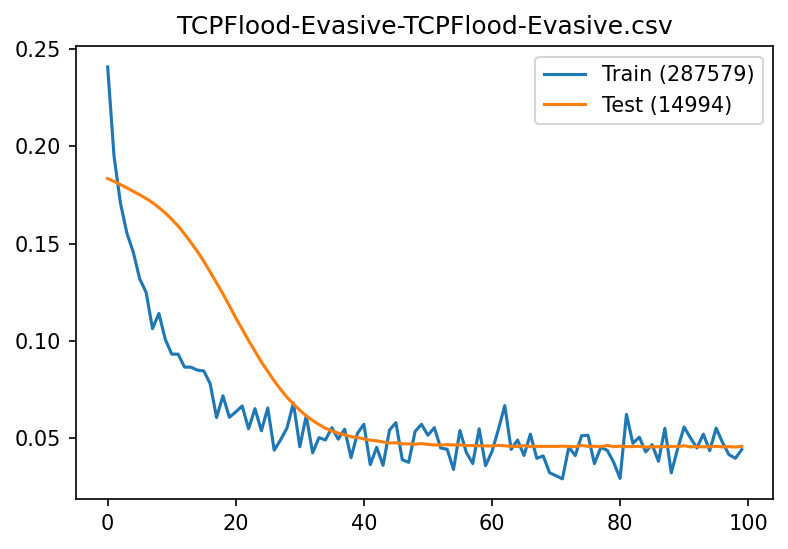

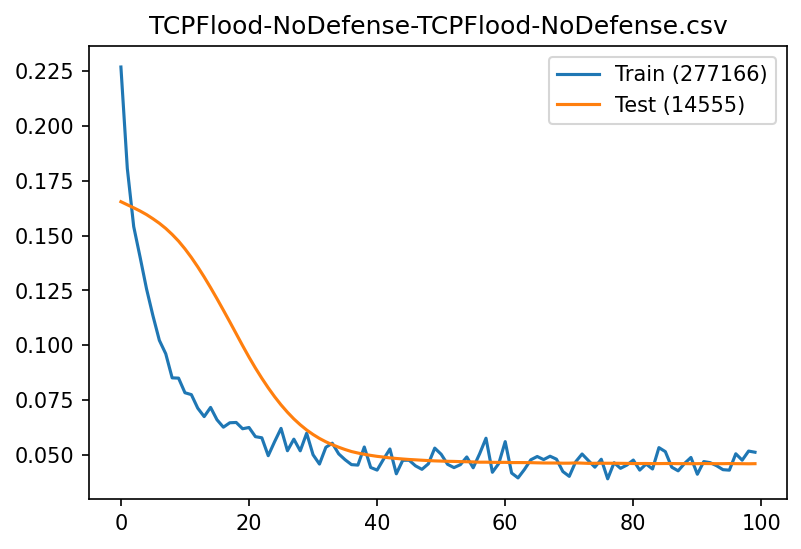

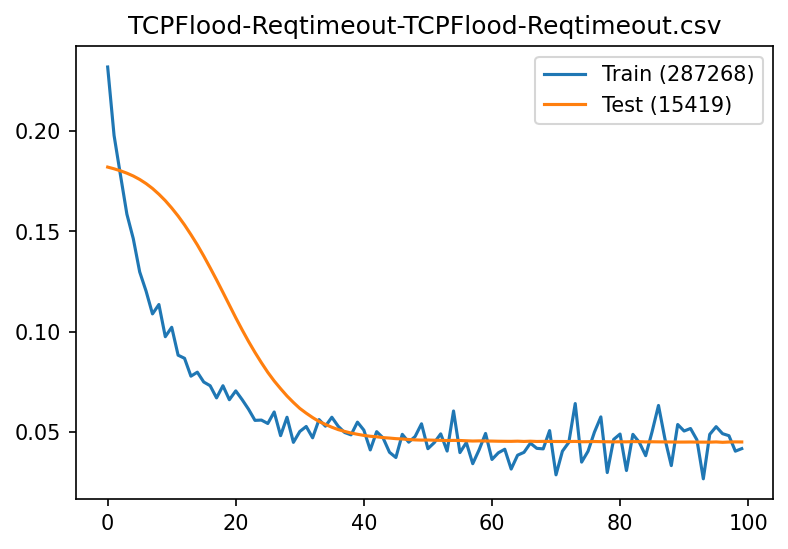

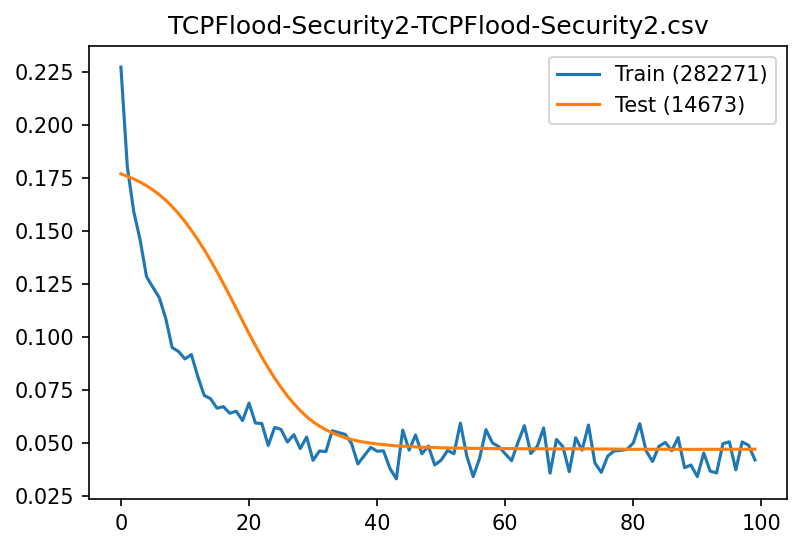

In [ ]:
train_models(USB_IDS_groups, 'TCPflood', learning_rate, latent_dim, KL_weight, epochs, batch_size, train_split, workspace_dir, USB_dir)

# Composite Datasets

## Datasets

### USB-IDS

In [10]:
USB_hulk_to_combine = [
    'USB-IDS\class_split\Hulk-Evasive-Hulk-Evasive.csv', 
    'USB-IDS\class_split\Hulk-NoDefense-Hulk-NoDefense.csv', 
    'USB-IDS\class_split\Hulk-Reqtimeout-Hulk-Reqtimeout.csv',
    'USB-IDS\class_split\Hulk-Security2-Hulk-Security2.csv'
]

USB_slowhttptest_to_combine = [
    'USB-IDS\class_split\Slowhttptest-Evasive-Slowhttptest-Evasive.csv',
    'USB-IDS\class_split\Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv',
    'USB-IDS\class_split\Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv',
    'USB-IDS\class_split\Slowhttptest-Security2-Slowhttptest-Security2.csv'
]

USB_slowloris_to_combine = [
    'USB-IDS\class_split\Slowloris-Evasive-Slowloris-Evasive.csv',
    'USB-IDS\class_split\Slowloris-NoDefense-Slowloris-NoDefense.csv',
    'USB-IDS\class_split\Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv',
    'USB-IDS\class_split\Slowloris-Security2-Slowloris-Security2.csv'
]

USB_tcpflood_to_combine = [
    'USB-IDS\class_split\TCPFlood-Evasive-TCPFlood-Evasive.csv',
    'USB-IDS\class_split\TCPFlood-NoDefense-TCPFlood-NoDefense.csv',
    'USB-IDS\class_split\TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv',
    'USB-IDS\class_split\TCPFlood-Security2-TCPFlood-Security2.csv'
]

USB_DoS_to_combine = [
    'USB-IDS/class_split/Hulk-Evasive-Hulk-Evasive.csv',
    'USB-IDS/class_split/Hulk-NoDefense-Hulk-NoDefense.csv',
    'USB-IDS/class_split/Hulk-Reqtimeout-Hulk-Reqtimeout.csv',
    'USB-IDS/class_split/Hulk-Security2-Hulk-Security2.csv',
    'USB-IDS/class_split/Slowhttptest-Evasive-Slowhttptest-Evasive.csv',
    'USB-IDS/class_split/Slowhttptest-NoDefense-Slowhttptest-NoDefense.csv',
    'USB-IDS/class_split/Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.csv',
    'USB-IDS/class_split/Slowhttptest-Security2-Slowhttptest-Security2.csv',
    'USB-IDS/class_split/Slowloris-Evasive-Slowloris-Evasive.csv',
    'USB-IDS/class_split/Slowloris-NoDefense-Slowloris-NoDefense.csv',
    'USB-IDS/class_split/Slowloris-Reqtimeout-Slowloris-Reqtimeout.csv',
    'USB-IDS/class_split/Slowloris-Security2-Slowloris-Security2.csv',
    'USB-IDS/class_split/TCPFlood-Evasive-TCPFlood-Evasive.csv',
    'USB-IDS/class_split/TCPFlood-NoDefense-TCPFlood-NoDefense.csv',
    'USB-IDS/class_split/TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.csv',
    'USB-IDS/class_split/TCPFlood-Security2-TCPFlood-Security2.csv'
]

In [11]:
combine_datasets(USB_hulk_to_combine, 'composite_datasets/USB_IDS_Hulk.csv')
combine_datasets(USB_slowhttptest_to_combine, 'composite_datasets/USB_IDS_slowhttptest.csv')
combine_datasets(USB_slowloris_to_combine, 'composite_datasets/USB_IDS_slowloris.csv')
combine_datasets(USB_tcpflood_to_combine, 'composite_datasets/USB_IDS_tcpflood.csv')
combine_datasets(USB_DoS_to_combine, 'composite_datasets/USB_IDS_DoS.csv', max_samples_per=2000)

Combined into new dataset (composite_datasets/USB_IDS_Hulk.csv) with 40000 samples
Combined into new dataset (composite_datasets/USB_IDS_slowhttptest.csv) with 23020 samples
Combined into new dataset (composite_datasets/USB_IDS_slowloris.csv) with 7128 samples
Combined into new dataset (composite_datasets/USB_IDS_tcpflood.csv) with 40000 samples
Combined into new dataset (composite_datasets/USB_IDS_DoS.csv) with 28512 samples


### CIC-IDS 2018

In [14]:
# CIC_2018_benign_to_combine = [
#     './CIC-IDS-2018/class_split/d02-14-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-15-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-16-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-21-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-22-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-23-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d02-28-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d03-01-2018-Benign.csv',
#     './CIC-IDS-2018/class_split/d03-02-2018-Benign.csv'
# ]

CIC_2018_benign_to_combine = []
for filename in CIC_2018_groups['benign']:
    CIC_2018_benign_to_combine.append(workspace_dir + CIC_2018_dir + filename)
print('2018 benign:')
print(CIC_2018_benign_to_combine)

CIC_2018_DoS_to_combine = []
for filename in CIC_2018_groups['DoS']:
    CIC_2018_DoS_to_combine.append(workspace_dir + CIC_2018_dir + filename)
print('\n2018 DoS:')
print(CIC_2018_DoS_to_combine)

CIC_2018_Web_to_combine = []
for filename in CIC_2018_groups['web']:
    CIC_2018_Web_to_combine.append(workspace_dir + CIC_2018_dir + filename)
print('\n2018 Web:')
print(CIC_2018_Web_to_combine)


2018 benign:
['./CIC-IDS-2018/class_split/d02-14-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-15-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-16-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-21-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-22-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-23-2018-Benign.csv', './CIC-IDS-2018/class_split/d02-28-2018-Benign.csv', './CIC-IDS-2018/class_split/d03-01-2018-Benign.csv', './CIC-IDS-2018/class_split/d03-02-2018-Benign.csv']

2018 DoS:
['./CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-GoldenEye.csv', './CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv', './CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv', './CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv']

2018 Web:
['./CIC-IDS-2018/class_split/d02-22-2018-Brute Force -Web.csv', './CIC-IDS-2018/class_split/d02-22-2018-Brute Force -XSS.csv', './CIC-IDS-2018/class_split/d02-22-2018-SQL Injection.csv', './CIC-IDS-2018/class_split/d

In [15]:
combine_datasets(CIC_2018_benign_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2018_benign.csv')
combine_datasets(CIC_2018_DoS_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2018_DoS.csv')
combine_datasets_unbalanced(CIC_2018_Web_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2018_web.csv')
#204 samples -> 928

Combined into new dataset (./composite_datasets/CIC-IDS-2018_benign.csv) with 90000 samples
Combined into new dataset (./composite_datasets/CIC-IDS-2018_DoS.csv) with 40000 samples
Combined into new dataset (./composite_datasets/CIC-IDS-2018_web.csv) with 928 samples


### CIC-IDS 2017

In [16]:
CIC_2017_benign_to_combine = []
for filename in CIC_2017_groups['benign']:
    CIC_2017_benign_to_combine.append(workspace_dir + CIC_2017_dir + filename)
print('2017 benign:')
print(CIC_2017_benign_to_combine)

CIC_2017_DoS_to_combine = []
for filename in CIC_2017_groups['DoS']:
    CIC_2017_DoS_to_combine.append(workspace_dir + CIC_2017_dir + filename)
print('\n2017 DoS:')
print(CIC_2017_DoS_to_combine)

CIC_2017_Web_to_combine = []
for filename in CIC_2017_groups['web']:
    CIC_2017_Web_to_combine.append(workspace_dir + CIC_2017_dir + filename)
print('\n2018 Web:')
print(CIC_2017_Web_to_combine)

2017 benign:
['./CIC-IDS-2017/class_split/daMonday-WorkingHours-BENIGN.csv', './CIC-IDS-2017/class_split/dbTuesday-WorkingHours-BENIGN.csv', './CIC-IDS-2017/class_split/dcWednesday-workingHours-BENIGN.csv', './CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.csv', './CIC-IDS-2017/class_split/deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.csv', './CIC-IDS-2017/class_split/dfFriday-WorkingHours-Morning-BENIGN.csv', './CIC-IDS-2017/class_split/dgFriday-WorkingHours-Afternoon-DDos-BENIGN.csv', './CIC-IDS-2017/class_split/dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.csv']

2017 DoS:
['./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS GoldenEye.csv', './CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv', './CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv', './CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv']

2018 Web:
['./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web 

In [17]:
combine_datasets(CIC_2017_benign_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2017_benign.csv')
combine_datasets(CIC_2017_DoS_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2017_DoS.csv')
combine_datasets_unbalanced(CIC_2017_Web_to_combine, workspace_dir + 'composite_datasets/CIC-IDS-2017_web.csv')
#63 samples -> 2180

Combined into new dataset (./composite_datasets/CIC-IDS-2017_benign.csv) with 80000 samples
Combined into new dataset (./composite_datasets/CIC-IDS-2017_DoS.csv) with 21996 samples
Combined into new dataset (./composite_datasets/CIC-IDS-2017_web.csv) with 2180 samples


## Cross dataset

### DoS

In [ ]:
Hulk_to_combine = [
    workspace_dir + CIC_2017_dir + 'dcWednesday-workingHours-DoS Hulk.csv',
    workspace_dir + CIC_2018_dir + 'd02-16-2018-DoS attacks-Hulk.csv',
    workspace_dir + 'composite_datasets/USB_IDS_Hulk.csv'
]
print('Hulk:')
print(Hulk_to_combine)

Slowloris_to_combine = [
    workspace_dir + CIC_2017_dir + 'dcWednesday-workingHours-DoS slowloris.csv',
    workspace_dir + CIC_2018_dir + 'd02-15-2018-DoS attacks-Slowloris.csv',
    workspace_dir + 'composite_datasets/USB_IDS_slowloris.csv'
]
print('\nslowloris:')
print(Slowloris_to_combine)

SlowHTTPtest_to_combine = [
    workspace_dir + CIC_2017_dir + 'dcWednesday-workingHours-DoS Slowhttptest.csv',
    workspace_dir + CIC_2018_dir + 'd02-16-2018-DoS attacks-SlowHTTPTest.csv',
    workspace_dir + 'composite_datasets/USB_IDS_slowhttptest.csv'
]
print('\nSlowHTTPtest:')
print(SlowHTTPtest_to_combine)

Hulk:
['./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv', './CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv', './composite_datasets/USB_IDS_Hulk.csv']

slowloris:
['./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv', './CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv', './composite_datasets/USB_IDS_slowloris.csv']

SlowHTTPtest:
['./CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv', './CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv', './composite_datasets/USB_IDS_slowhttptest.csv']


In [ ]:
combine_datasets(Hulk_to_combine, workspace_dir + 'composite_datasets/Hulk_composite.csv')
combine_datasets(Slowloris_to_combine, workspace_dir + 'composite_datasets/Slowloris_composite.csv')
combine_datasets(SlowHTTPtest_to_combine, workspace_dir + 'composite_datasets/SlowHTTPTest_composite.csv')

Combined into new dataset (./composite_datasets/Hulk_composite.csv) with 30000 samples
Combined into new dataset (./composite_datasets/Slowloris_composite.csv) with 17388 samples
Combined into new dataset (./composite_datasets/SlowHTTPTest_composite.csv) with 16497 samples


### Web Based

In [12]:
Web_to_combine = [
    workspace_dir + CIC_2017_dir + CIC_2017_groups['web'][0],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][0],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][3],
]
print('Web:')
print(Web_to_combine)

SQL_to_combine = [
    workspace_dir + CIC_2017_dir + CIC_2017_groups['web'][1],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][2],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][5]
]
print('\nSQL:')
print(SQL_to_combine)

XSS_to_combine = [
    workspace_dir + CIC_2017_dir + CIC_2017_groups['web'][2],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][1],
    workspace_dir + CIC_2018_dir + CIC_2018_groups['web'][4]
]
print('\nXSS:')
print(XSS_to_combine)

Web:
['./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.csv', './CIC-IDS-2018/class_split/d02-22-2018-Brute Force -Web.csv', './CIC-IDS-2018/class_split/d02-23-2018-Brute Force -Web.csv']

SQL:
['./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.csv', './CIC-IDS-2018/class_split/d02-22-2018-SQL Injection.csv', './CIC-IDS-2018/class_split/d02-23-2018-SQL Injection.csv']

XSS:
['./CIC-IDS-2017/class_split/ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.csv', './CIC-IDS-2018/class_split/d02-22-2018-Brute Force -XSS.csv', './CIC-IDS-2018/class_split/d02-23-2018-Brute Force -XSS.csv']


In [13]:
combine_datasets_unbalanced(Web_to_combine, workspace_dir + 'composite_datasets/Web_composite.csv')
combine_datasets_unbalanced(SQL_to_combine, workspace_dir + 'composite_datasets/SQL_composite.csv')
combine_datasets_unbalanced(XSS_to_combine, workspace_dir + 'composite_datasets/XSS_composite.csv')

Combined into new dataset (./composite_datasets/Web_composite.csv) with 2118 samples
Combined into new dataset (./composite_datasets/SQL_composite.csv) with 108 samples
Combined into new dataset (./composite_datasets/XSS_composite.csv) with 882 samples


## Training Composites

In [14]:
learning_rate = 1e-3
epochs = 1
latent_dim = 5
KL_weight = 0.05
train_split = 0.95
batch_size=128

In [ ]:
# This is just to basically move and rename the USB IDS benign class to composite
# datasets because the other data it will be compared to are composite datasets.
combine_datasets_unbalanced(['USB-IDS\class_split\REGULAR-BENIGN.csv'], 'composite_datasets/USB_IDS_benign.csv')

In [41]:
cross_models = {
    'benign-dataset' : [
        'CIC-IDS-2017_benign.csv',
        'CIC-IDS-2018_benign.csv',
        'USB_IDS_benign.csv'
    ],
    'USB-Comp' : [
        'USB_IDS_Hulk.csv',
        'USB_IDS_slowhttptest.csv',
        'USB_IDS_slowloris.csv',
        'USB_IDS_tcpflood.csv'
    ],
    'DoS-Comp-class' : [
        'Hulk_composite.csv',
        'SlowHTTPTest_composite.csv',
        'Slowloris_composite.csv'
    ],
    'DoS_comp_dataset' : [
        'CIC-IDS-2017_DoS.csv',
        'CIC-IDS-2018_DoS.csv',
        'USB_IDS_DoS.csv'
    ],
    'Web_class' : [
        'Web_composite.csv',
        'XSS_composite.csv',
        'SQL_composite.csv'
    ],
    'Web_dataset' : [
        'CIC-IDS-2017_web.csv',
        'CIC-IDS-2018_web.csv'
    ]
}
composite_dir = 'composite_datasets/'

Combined into new dataset (composite_datasets/USB_IDS_benign.csv) with 305921 samples
Reading file ./composite_datasets/CIC-IDS-2017_benign.csv
Training samples: 75970, Testing samples: 4030


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:08<00:00:00  12.32it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2017_benign.pt
Reading file ./composite_datasets/CIC-IDS-2018_benign.csv
Training samples: 85375, Testing samples: 4625


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:09<00:00:00  10.59it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2018_benign.pt
Reading file ./composite_datasets/USB_IDS_benign.csv
Training samples: 290778, Testing samples: 15143


  Iters     Elapsed Time      Speed                                             
 100/100  00:00:26<00:00:00  3.71it/s                                           

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_benign.pt


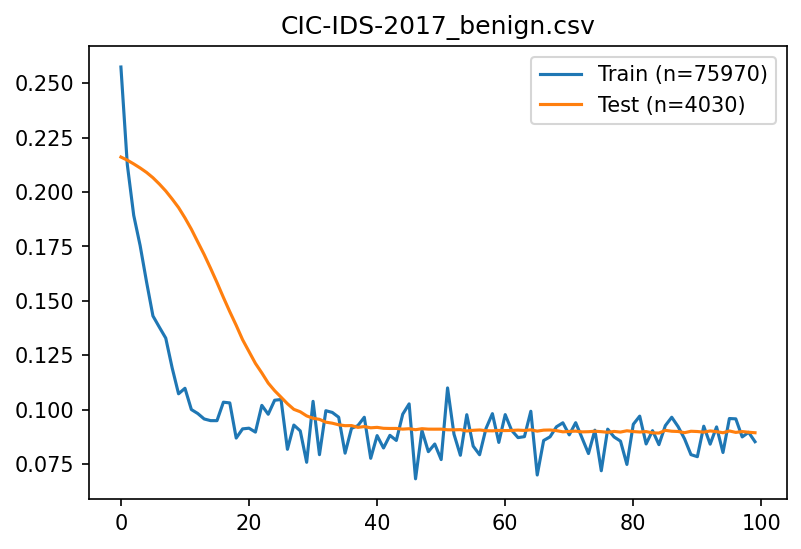

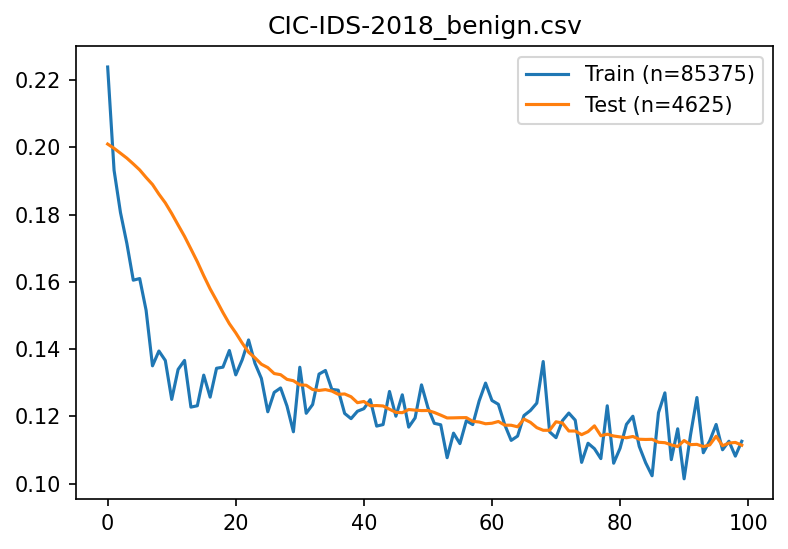

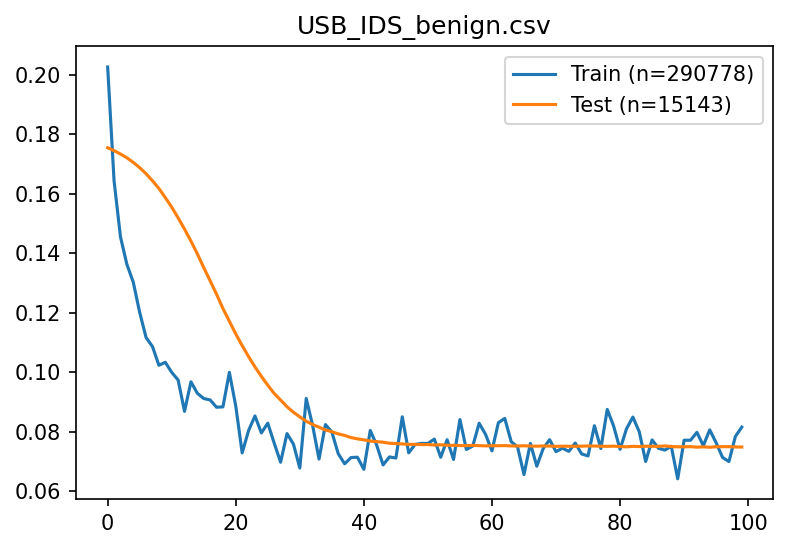

In [26]:
train_models(
    cross_models, 'benign-dataset', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, train_split, 
    workspace_dir, composite_dir
)

Reading file ./composite_datasets/USB_IDS_Hulk.csv
Training samples: 38100, Testing samples: 1900


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:04<00:00:00  23.25it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_Hulk.pt
Reading file ./composite_datasets/USB_IDS_slowhttptest.csv
Training samples: 21885, Testing samples: 1135


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  39.52it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_slowhttptest.pt
Reading file ./composite_datasets/USB_IDS_slowloris.csv
Training samples: 6745, Testing samples: 383


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  71.48it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_slowloris.pt
Reading file ./composite_datasets/USB_IDS_tcpflood.csv
Training samples: 37884, Testing samples: 2116


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:04<00:00:00  21.22it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_tcpflood.pt


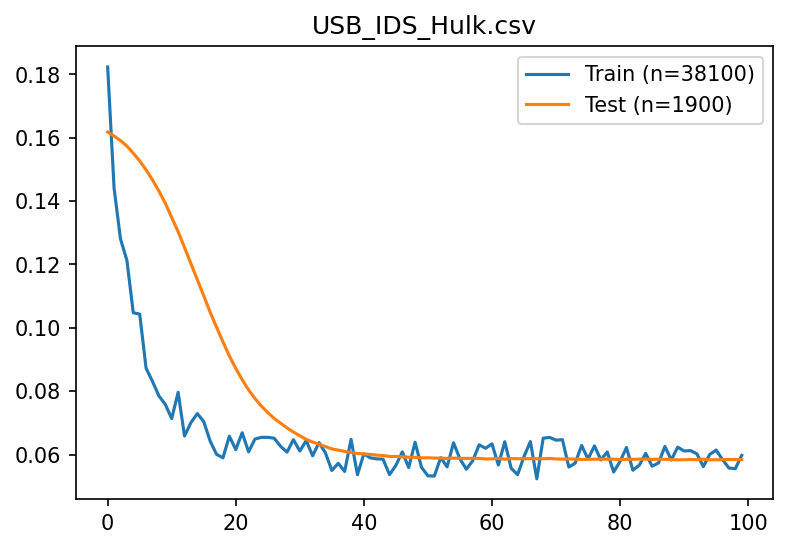

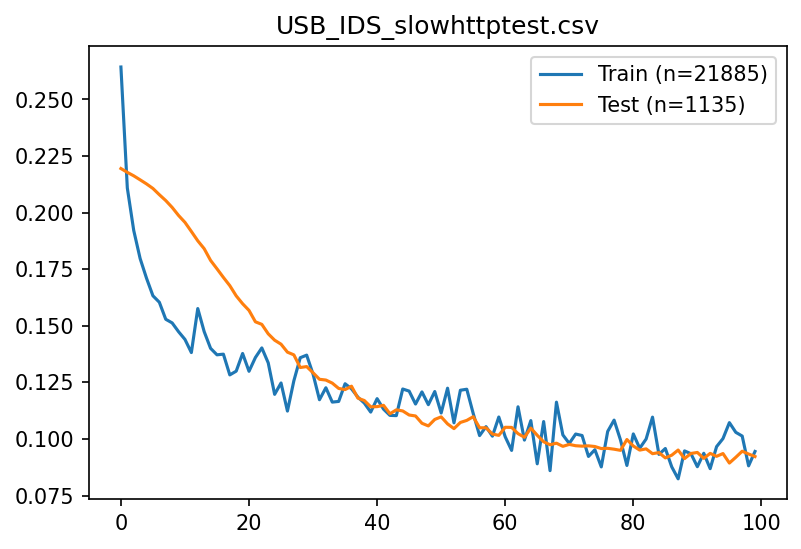

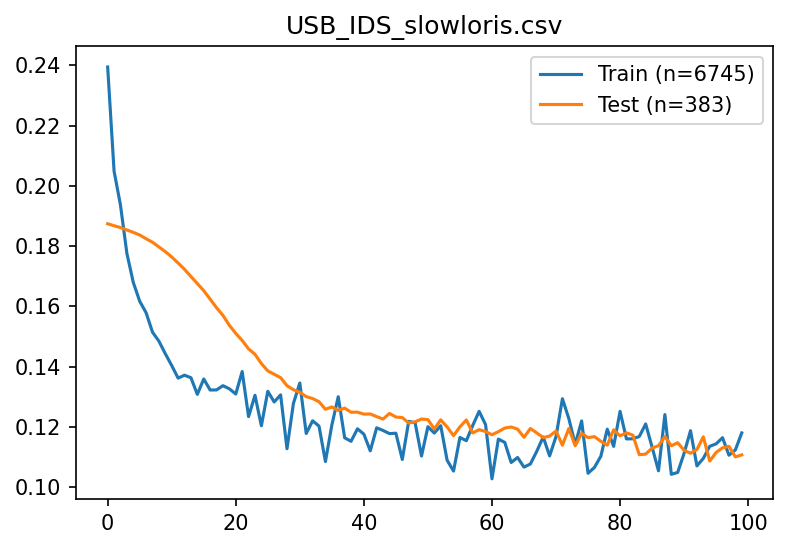

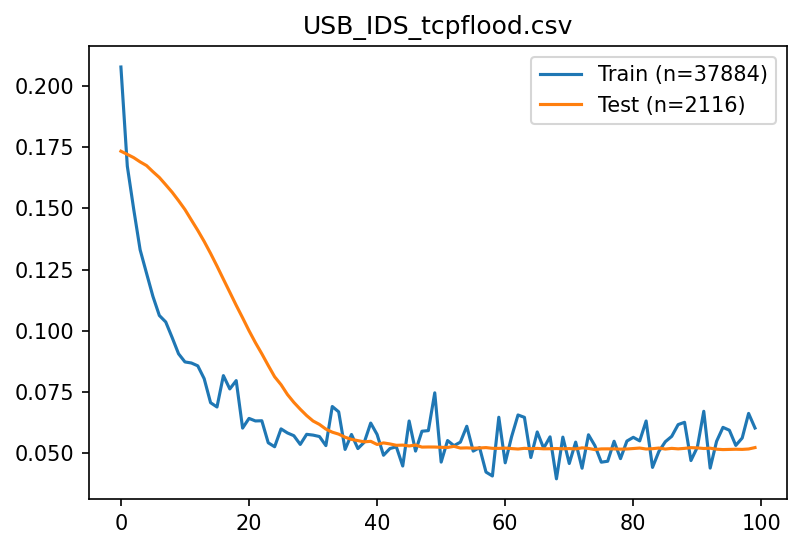

In [30]:
train_models(
    cross_models, 'USB-Comp', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, train_split, 
    workspace_dir, composite_dir
)

Reading file ./composite_datasets/Hulk_composite.csv
Training samples: 28536, Testing samples: 1464


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:03<00:00:00  32.38it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Hulk_composite.pt
Reading file ./composite_datasets/SlowHTTPTest_composite.csv
Training samples: 15646, Testing samples: 851


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  47.16it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/SlowHTTPTest_composite.pt
Reading file ./composite_datasets/Slowloris_composite.csv
Training samples: 16478, Testing samples: 910


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  43.94it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Slowloris_composite.pt


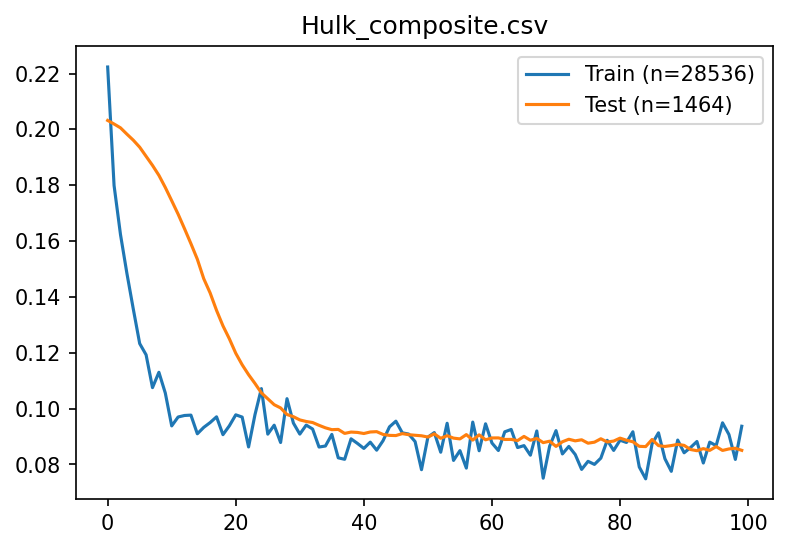

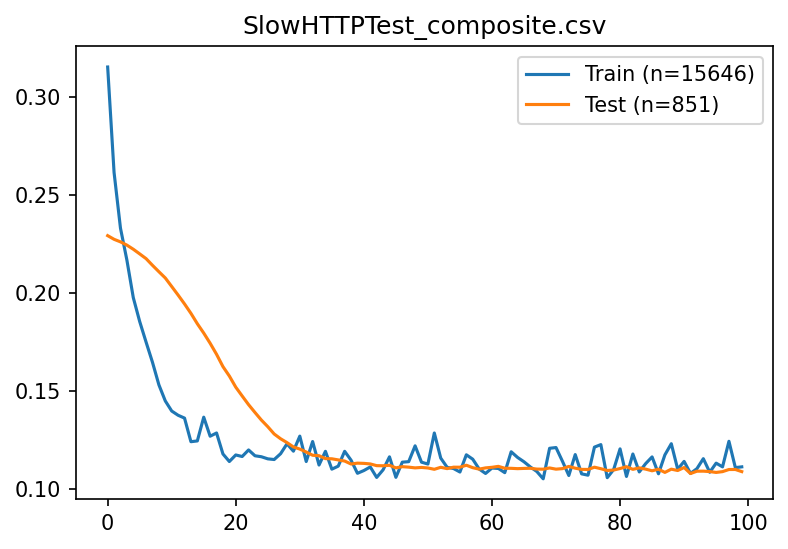

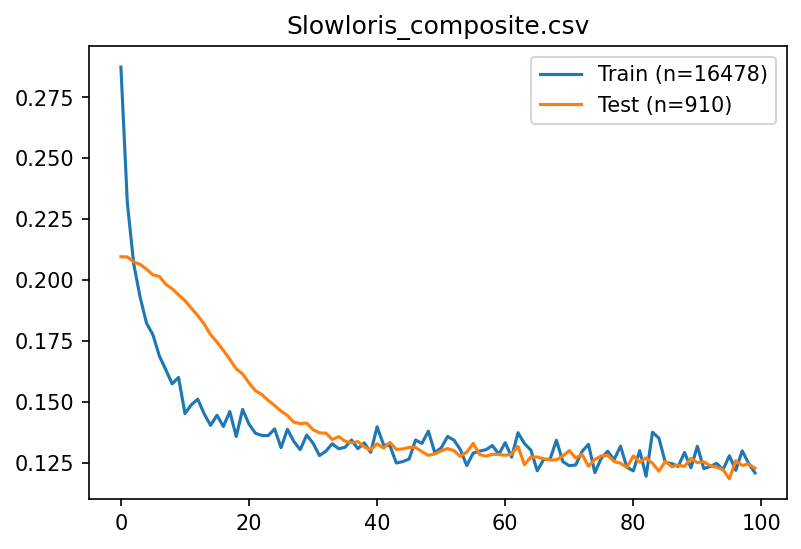

In [33]:
train_models(
    cross_models, 'DoS-Comp-class', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, train_split, 
    workspace_dir, composite_dir
)


Reading file ./composite_datasets/CIC-IDS-2017_DoS.csv
Training samples: 20887, Testing samples: 1109


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  38.58it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2017_DoS.pt
Reading file ./composite_datasets/CIC-IDS-2018_DoS.csv
Training samples: 37983, Testing samples: 2017


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:04<00:00:00  22.37it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2018_DoS.pt
Reading file ./composite_datasets/USB_IDS_DoS.csv
Training samples: 27085, Testing samples: 1427


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:03<00:00:00  31.18it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/USB_IDS_DoS.pt


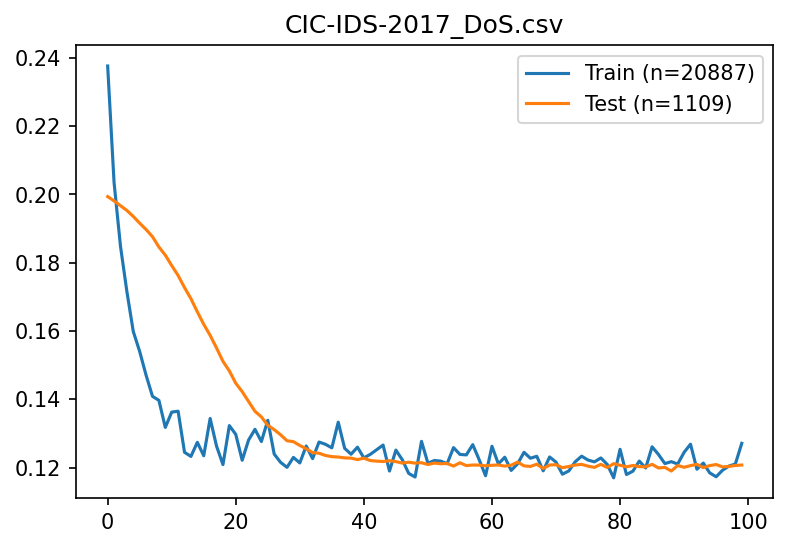

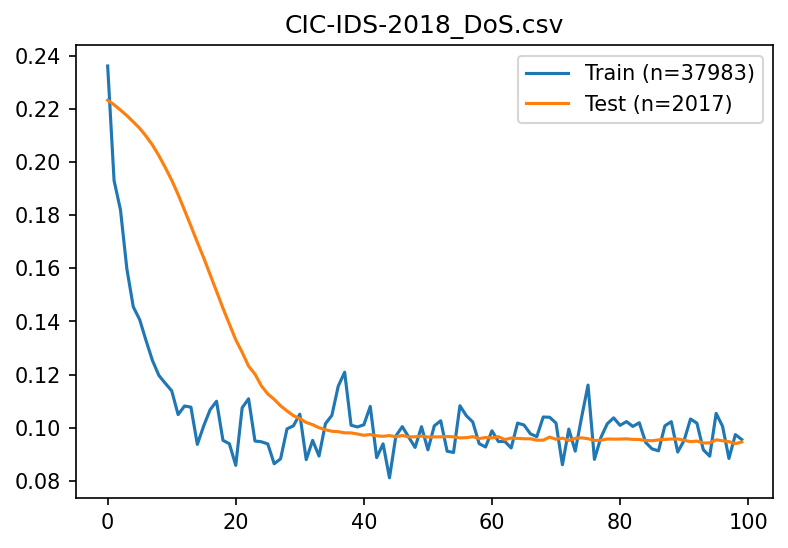

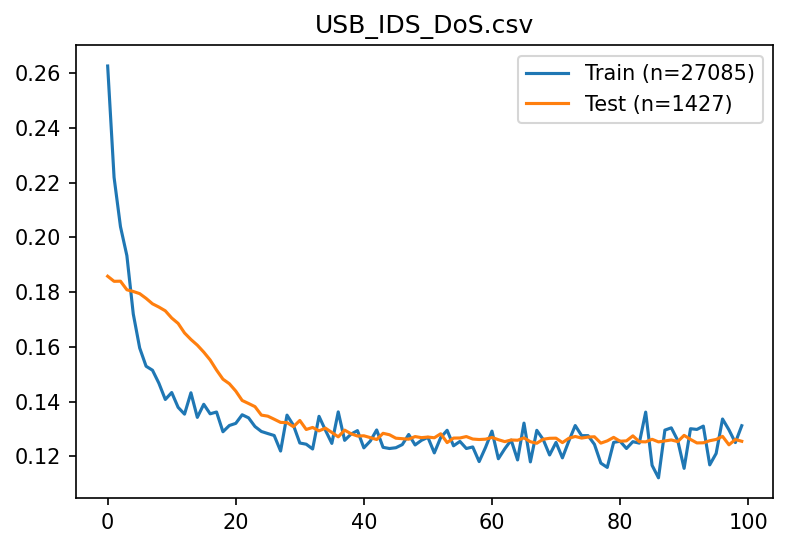

In [35]:
train_models(
    cross_models, 'DoS_comp_dataset', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, train_split, 
    workspace_dir, composite_dir
)

Reading file ./composite_datasets/Web_composite.csv
Training samples: 1232, Testing samples: 886


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  47.77it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/Web_composite.pt
Reading file ./composite_datasets/XSS_composite.csv
Training samples: 531, Testing samples: 351


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  77.04it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/XSS_composite.pt
Reading file ./composite_datasets/SQL_composite.csv
Training samples: 65, Testing samples: 43


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:00<00:00:00  112.93it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/SQL_composite.pt


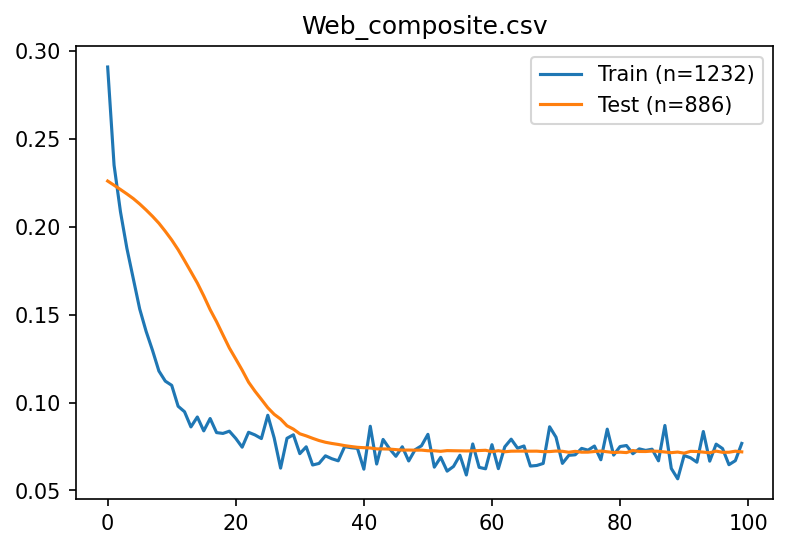

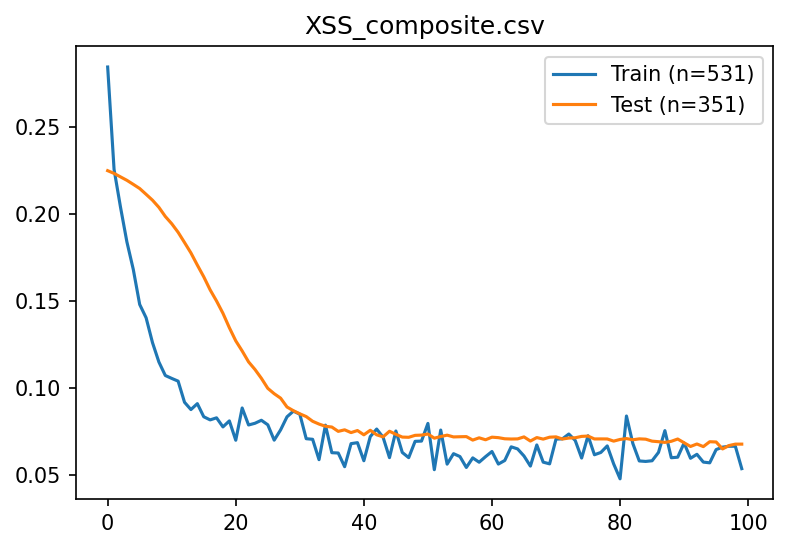

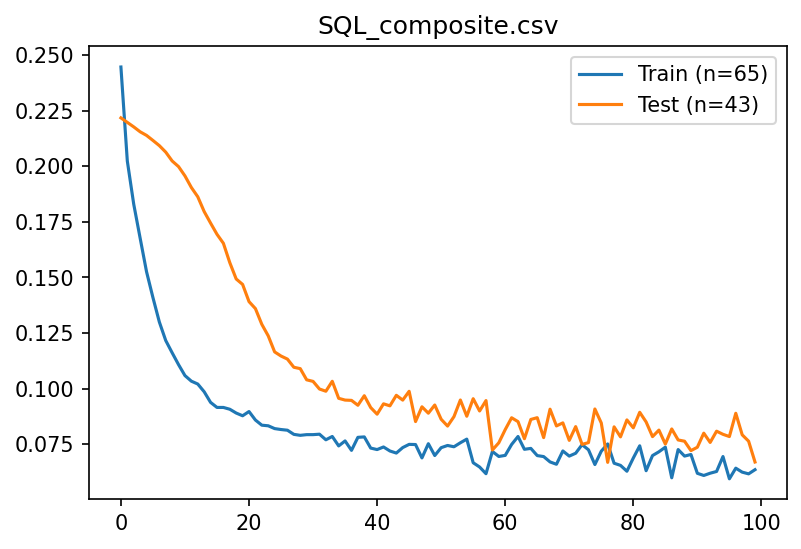

In [40]:
train_models(
    cross_models, 'Web_class', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, 0.6,#train_split, 
    workspace_dir, composite_dir
)

Reading file ./composite_datasets/CIC-IDS-2017_web.csv
Training samples: 1315, Testing samples: 865


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:02<00:00:00  48.92it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2017_web.pt
Reading file ./composite_datasets/CIC-IDS-2018_web.csv
Training samples: 551, Testing samples: 377


  Iters     Elapsed Time       Speed                                            
 100/100  00:00:01<00:00:00  77.01it/s                                          

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Model saved to ./models/CIC-IDS-2018_web.pt


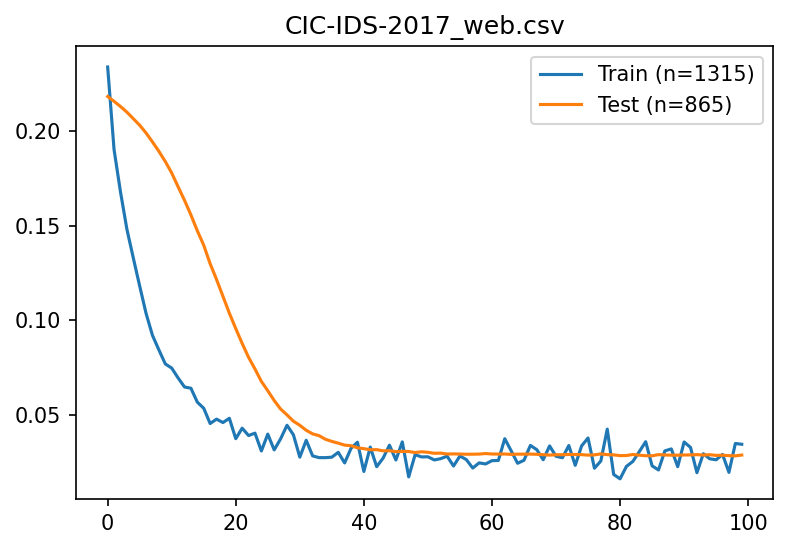

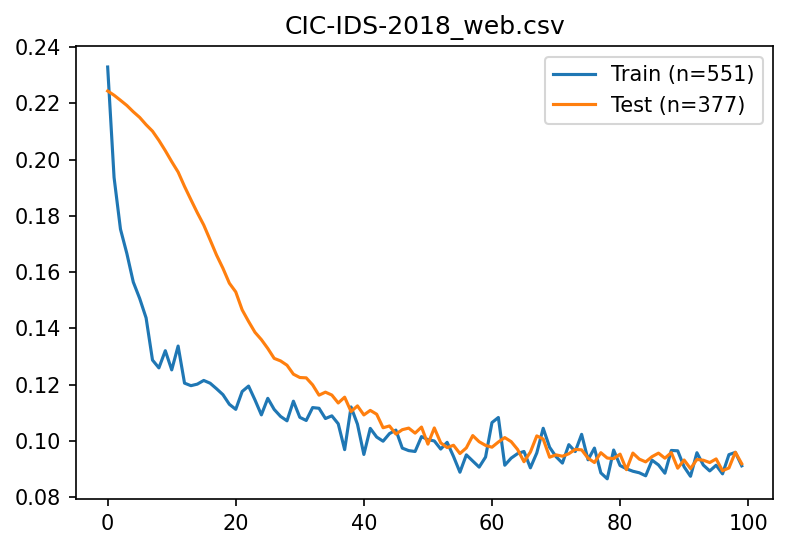

In [42]:
train_models(
    cross_models, 'Web_dataset', learning_rate, latent_dim, 
    KL_weight, epochs, batch_size, 0.6,#train_split, 
    workspace_dir, composite_dir
)

# Cross Testing

## CIC-IDS 2018 Benign

In [10]:
    # 'CIC-IDS-2017_DoS.pt',
    # 'CIC-IDS-2017_benign.pt',
    # 'CIC-IDS-2017_web.pt',
    # 'CIC-IDS-2018_DoS.pt',
    # 'CIC-IDS-2018_benign.pt',
    # 'CIC-IDS-2018_web.pt',
    # 'Hulk-Evasive-Hulk-Evasive.pt',
    # 'Hulk-NoDefense-Hulk-NoDefense.pt',
    # 'Hulk-Reqtimeout-Hulk-Reqtimeout.pt',
    # 'Hulk-Security2-Hulk-Security2.pt',
    # 'Hulk_composite.pt',
    # 'REGULAR-BENIGN.pt',
    # 'SQL_composite.pt',
    # 'SlowHTTPTest_composite.pt',
    # 'Slowhttptest-Evasive-Slowhttptest-Evasive.pt',
    # 'Slowhttptest-NoDefense-Slowhttptest-NoDefense.pt',
    # 'Slowhttptest-Reqtimeout-Slowhttptest-Reqtimeout.pt',
    # 'Slowhttptest-Security2-Slowhttptest-Security2.pt',
    # 'Slowloris-Evasive-Slowloris-Evasive.pt',
    # 'Slowloris-NoDefense-Slowloris-NoDefense.pt',
    # 'Slowloris-Reqtimeout-Slowloris-Reqtimeout.pt',
    # 'Slowloris-Security2-Slowloris-Security2.pt',
    # 'Slowloris_composite.pt',
    # 'TCPFlood-Evasive-TCPFlood-Evasive.pt',
    # 'TCPFlood-NoDefense-TCPFlood-NoDefense.pt',
    # 'TCPFlood-Reqtimeout-TCPFlood-Reqtimeout.pt',
    # 'TCPFlood-Security2-TCPFlood-Security2.pt',
    # 'USB_IDS_DoS.pt',
    # 'USB_IDS_Hulk.pt',
    # 'USB_IDS_benign.pt',
    # 'USB_IDS_slowhttptest.pt',
    # 'USB_IDS_slowloris.pt',
    # 'USB_IDS_tcpflood.pt',
    # 'Web_composite.pt',
    # 'XSS_composite.pt',
    # 'd02-14-2018-Benign.pt',
    # 'd02-15-2018-Benign.pt',
    # 'd02-15-2018-DoS attacks-GoldenEye.pt',
    # 'd02-15-2018-DoS attacks-Slowloris.pt',
    # 'd02-16-2018-Benign.pt',
    # 'd02-16-2018-DoS attacks-Hulk.pt',
    # 'd02-16-2018-DoS attacks-SlowHTTPTest.pt',
    # 'd02-21-2018-Benign.pt',
    # 'd02-22-2018-Benign.pt',
    # 'd02-22-2018-Brute Force -Web.pt',
    # 'd02-22-2018-Brute Force -XSS.pt',
    # 'd02-22-2018-SQL Injection.pt',
    # 'd02-23-2018-Benign.pt',
    # 'd02-23-2018-Brute Force -Web.pt',
    # 'd02-23-2018-Brute Force -XSS.pt',
    # 'd02-23-2018-SQL Injection.pt',
    # 'd02-28-2018-Benign.pt',
    # 'd03-01-2018-Benign.pt',
    # 'd03-02-2018-Benign.pt',
    # 'daMonday-WorkingHours-BENIGN.pt',
    # 'dbTuesday-WorkingHours-BENIGN.pt',
    # 'dcWednesday-workingHours-BENIGN.pt',
    # 'dcWednesday-workingHours-DoS GoldenEye.pt',
    # 'dcWednesday-workingHours-DoS Hulk.pt',
    # 'dcWednesday-workingHours-DoS Slowhttptest.pt',
    # 'dcWednesday-workingHours-DoS slowloris.pt',
    # 'ddThursday-WorkingHours-Morning-WebAttacks-BENIGN.pt',
    # 'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Brute Force.pt',
    # 'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � Sql Injection.pt',
    # 'ddThursday-WorkingHours-Morning-WebAttacks-Web Attack � XSS.pt',
    # 'deThursday-WorkingHours-Afternoon-Infilteration-BENIGN.pt',
    # 'dfFriday-WorkingHours-Morning-BENIGN.pt',
    # 'dgFriday-WorkingHours-Afternoon-DDos-BENIGN.pt',
    # 'dgFriday-WorkingHours-Afternoon-PortScan-BENIGN.pt',

#CIC 2018 Datasets
# 'd02-14-2018-Benign.csv'
# 'd02-14-2018-FTP-BruteForce.csv'
# 'd02-14-2018-SSH-Bruteforce.csv'
# 'd02-15-2018-Benign.csv'
# 'd02-15-2018-DoS attacks-GoldenEye.csv'
# 'd02-15-2018-DoS attacks-Slowloris.csv'
# 'd02-16-2018-Benign.csv'
# 'd02-16-2018-DoS attacks-Hulk.csv'
# 'd02-16-2018-DoS attacks-SlowHTTPTest.csv'
# 'd02-21-2018-Benign.csv'
# 'd02-21-2018-DDOS attack-HOIC.csv'
# 'd02-21-2018-DDOS attack-LOIC-UDP.csv'
# 'd02-22-2018-Benign.csv'
# 'd02-22-2018-Brute Force -Web.csv'
# 'd02-22-2018-Brute Force -XSS.csv'
# 'd02-22-2018-SQL Injection.csv'
# 'd02-23-2018-Benign.csv'
# 'd02-23-2018-Brute Force -Web.csv'
# 'd02-23-2018-Brute Force -XSS.csv'
# 'd02-23-2018-SQL Injection.csv'
# 'd02-28-2018-Benign.csv'
# 'd02-28-2018-Infilteration.csv'
# 'd03-01-2018-Benign.csv'
# 'd03-01-2018-Infilteration.csv'
# 'd03-02-2018-Benign.csv'
# 'd03-02-2018-Bot.csv'

#Composite datasets
# 'CIC-IDS-2017_DoS.csv'
# 'CIC-IDS-2017_benign.csv'
# 'CIC-IDS-2017_web.csv'
# 'CIC-IDS-2018_DoS.csv'
# 'CIC-IDS-2018_benign.csv'
# 'CIC-IDS-2018_web.csv'
# 'Hulk_composite.csv'
# 'SQL_composite.csv'
# 'SlowHTTPTest_composite.csv'
# 'Slowloris_composite.csv'
# 'USB_IDS_DoS.csv'
# 'USB_IDS_Hulk.csv'
# 'USB_IDS_benign.csv'
# 'USB_IDS_slowhttptest.csv'
# 'USB_IDS_slowloris.csv'
# 'USB_IDS_tcpflood.csv'
# 'Web_composite.csv'
# 'XSS_composite.csv'

CIC_2018_benign_dic = {
    'models' : [
        'd02-14-2018-Benign.pt',
        'd02-15-2018-Benign.pt',
        'd02-16-2018-Benign.pt',
        'd02-21-2018-Benign.pt',
        'd02-22-2018-Benign.pt',
        'd02-23-2018-Benign.pt',
        'd02-28-2018-Benign.pt',
        'd03-01-2018-Benign.pt',
        'd03-02-2018-Benign.pt'
    ],
    'datasets' : [
        'd02-14-2018-Benign.csv',
        'd02-15-2018-Benign.csv',
        'd02-16-2018-Benign.csv',
        'd02-21-2018-Benign.csv',
        'd02-22-2018-Benign.csv',
        'd02-23-2018-Benign.csv',
        'd02-28-2018-Benign.csv',
        'd03-01-2018-Benign.csv',
        'd03-02-2018-Benign.csv'
    ],
    'results' : {}
}

In [11]:
for model_filename in CIC_2018_benign_dic['models']:
    print(model_filename)
    model = torch.load(workspace_dir + 'models/' + model_filename).cuda()
    model.eval()
    CIC_2018_benign_dic['results'][model_filename] = {}
    for dataset_filename in CIC_2018_benign_dic['datasets']:
        print(dataset_filename)
        data = IDS_Dataset(workspace_dir + CIC_2018_dir + dataset_filename)
        index_sample = list(range(len(data)))
        index_sample = random.sample(index_sample, min(len(data), 100000))
        data = data[index_sample, :]
        data_loader = torch.utils.data.DataLoader(data, batch_size=1)
        losses = np.empty(len(data))
        i = 0
        for e in qqdm(data_loader):
            x = e.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses[i] = loss.item()
            i += 1
        CIC_2018_benign_dic['results'][model_filename][dataset_filename] = losses
        #CIC-IDS-2018\class_split\d02-14-2018-Benign.csv

d02-14-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:47<00:00:00  596.04it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  627.88it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:35<00:00:00  642.10it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  615.43it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:41<00:00:00  618.32it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  611.66it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  613.66it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  613.20it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:48<00:00:00  595.20it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:45<00:00:00  602.83it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:50<00:00:00  586.05it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  613.63it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  613.02it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  614.62it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  623.70it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:37<00:00:00  633.39it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  658.82it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:33<00:00:00  650.23it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:38<00:00:00  631.17it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:35<00:00:00  643.35it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  615.52it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:45<00:00:00  605.38it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  614.46it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  612.48it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  621.39it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:46<00:00:00  599.32it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  612.43it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  611.79it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  610.72it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:45<00:00:00  604.75it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:48<00:00:00  594.03it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:45<00:00:00  605.37it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  610.22it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:38<00:00:00  630.48it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  669.84it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  657.57it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  623.25it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  627.09it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  624.23it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:41<00:00:00  619.00it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  615.96it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  628.59it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:14<00:00:00  741.57it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:14<00:00:00  744.28it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:25<00:00:00  686.36it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:41<00:00:00  620.73it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  628.06it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  612.56it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:42<00:00:00  613.63it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  628.10it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  624.42it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  626.16it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:40<00:00:00  621.67it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:22<00:00:00  704.12it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:17<00:00:00  727.35it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  667.07it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  653.83it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  662.41it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  669.80it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:28<00:00:00  671.92it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:28<00:00:00  671.42it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  656.39it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  659.07it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  661.21it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:27<00:00:00  677.72it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:25<00:00:00  689.50it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:20<00:00:00  713.02it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:22<00:00:00  702.36it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:24<00:00:00  690.40it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:39<00:00:00  628.29it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:33<00:00:00  652.93it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:34<00:00:00  646.53it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.pt
d02-14-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:33<00:00:00  649.57it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:35<00:00:00  641.03it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  655.88it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-21-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:26<00:00:00  683.42it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-22-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:26<00:00:00  681.85it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-23-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:26<00:00:00  683.84it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-28-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:27<00:00:00  679.10it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-01-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:27<00:00:00  679.43it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d03-02-2018-Benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:27<00:00:00  677.93it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [12]:
CIC_2018_benign_dic['results_mean'] = {}
for model in CIC_2018_benign_dic['results']:
    print(model)
    CIC_2018_benign_dic['results_mean'][model] = {}
    for dataset in CIC_2018_benign_dic['results'][model]:
        print(f'\t{dataset}')
        CIC_2018_benign_dic['results_mean'][model][dataset] = np.mean(CIC_2018_benign_dic['results'][model][dataset])

d02-14-2018-Benign.pt
	d02-14-2018-Benign.csv
	d02-15-2018-Benign.csv
	d02-16-2018-Benign.csv
	d02-21-2018-Benign.csv
	d02-22-2018-Benign.csv
	d02-23-2018-Benign.csv
	d02-28-2018-Benign.csv
	d03-01-2018-Benign.csv
	d03-02-2018-Benign.csv
d02-15-2018-Benign.pt
	d02-14-2018-Benign.csv
	d02-15-2018-Benign.csv
	d02-16-2018-Benign.csv
	d02-21-2018-Benign.csv
	d02-22-2018-Benign.csv
	d02-23-2018-Benign.csv
	d02-28-2018-Benign.csv
	d03-01-2018-Benign.csv
	d03-02-2018-Benign.csv
d02-16-2018-Benign.pt
	d02-14-2018-Benign.csv
	d02-15-2018-Benign.csv
	d02-16-2018-Benign.csv
	d02-21-2018-Benign.csv
	d02-22-2018-Benign.csv
	d02-23-2018-Benign.csv
	d02-28-2018-Benign.csv
	d03-01-2018-Benign.csv
	d03-02-2018-Benign.csv
d02-21-2018-Benign.pt
	d02-14-2018-Benign.csv
	d02-15-2018-Benign.csv
	d02-16-2018-Benign.csv
	d02-21-2018-Benign.csv
	d02-22-2018-Benign.csv
	d02-23-2018-Benign.csv
	d02-28-2018-Benign.csv
	d03-01-2018-Benign.csv
	d03-02-2018-Benign.csv
d02-22-2018-Benign.pt
	d02-14-2018-Benign.csv
	d

In [13]:
results = []

for model_name in CIC_2018_benign_dic['models']:
    results.append([])
    for dataset_name in CIC_2018_benign_dic['datasets']:
        results[-1].append(CIC_2018_benign_dic['results_mean'][model_name][dataset_name])

[[0.08695568796408362, 0.0856836374317715, 0.2692489182130247, 0.2562084295391664, 0.09990892568300479, 0.10140257852256299, 0.09884322481956333, 0.10273558383548166, 0.12056489337841049], [0.09199675675780512, 0.08316663339187391, 0.3064743915427849, 0.26679501241087916, 0.0974625792873092, 0.09842426393522881, 0.09746066777915693, 0.10195695773009211, 0.1218554054367356], [0.3496335901091993, 0.3623747612607479, 0.02222843685502419, 0.19817792376361787, 0.35800765721186995, 0.3576932409915328, 0.3761510613917559, 0.36560365364991126, 0.344040692672506], [0.31515938862726095, 0.3135602205239609, 0.19269868145264685, 0.030531299644766842, 0.31221586066283286, 0.31274607926294207, 0.31457108573824166, 0.3058923512415588, 0.28386818658806384], [0.09457020374404267, 0.08660344853921793, 0.29444952320545914, 0.25623174571150914, 0.09340931705819443, 0.09411901451738551, 0.09792000686001033, 0.10220080735552124, 0.11565123431926594], [0.09450217626985162, 0.0868619699717313, 0.2829548209566

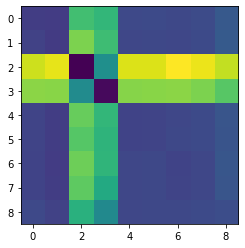

In [15]:
# results = [
#     [0.08695568796408362, 0.0856836374317715,  0.2692489182130247,  0.2562084295391664,   0.09990892568300479, 0.10140257852256299, 0.09884322481956333, 0.10273558383548166, 0.12056489337841049],
#     [0.09199675675780512, 0.08316663339187391, 0.3064743915427849,  0.26679501241087916,  0.0974625792873092,  0.09842426393522881, 0.09746066777915693, 0.10195695773009211, 0.1218554054367356],
#     [0.3496335901091993,  0.3623747612607479,  0.02222843685502419, 0.19817792376361787,  0.35800765721186995, 0.3576932409915328,  0.3761510613917559,  0.36560365364991126, 0.344040692672506],
#     [0.31515938862726095, 0.3135602205239609,  0.19269868145264685, 0.030531299644766842, 0.31221586066283286, 0.31274607926294207, 0.31457108573824166, 0.3058923512415588,  0.28386818658806384],
#     [0.09457020374404267, 0.08660344853921793, 0.29444952320545914, 0.25623174571150914,  0.09340931705819443, 0.09411901451738551, 0.09792000686001033, 0.10220080735552124, 0.11565123431926594],
#     [0.09450217626985162, 0.0868619699717313,  0.2829548209566809,  0.25270423588365315,  0.09315667473844252, 0.0942505172852613,  0.09851020945050754, 0.10236199193133041, 0.11481610559203662],
#     [0.09388429553914815, 0.08549907879449427, 0.29853433228207754, 0.2537745955149457,   0.09748114665802568, 0.09889680055921897, 0.09299431522236205, 0.09814309075908735, 0.11698120064857416],
#     [0.09366495779356919, 0.08649599676352926, 0.28827576589452103, 0.2370669750586152,   0.0971814168990776,  0.09838094733659178, 0.0943262108954601,  0.09806724618890322, 0.11525816624997183],
#     [0.10016726460784674, 0.09238761520145461, 0.2466408655418828,  0.19071905880600215,  0.09825012431165203, 0.09909076692150906, 0.09930309546178206, 0.1012991630608216,  0.10592107461711392]
# ]

# print(CIC_2018_benign_dic['results_mean'])
print(results)
x = plt.imshow(results, interpolation='none')
# plt.axes.set_xticklabels(CIC_2018_benign_dic['models'])
plt.show()

## CIC-IDS 2018 DoS

In [19]:
CIC_2018_DoS_dic = {
    'models' : [
        'd02-15-2018-DoS attacks-GoldenEye.pt',
        'd02-15-2018-DoS attacks-Slowloris.pt',
        'd02-16-2018-DoS attacks-Hulk.pt',
        'd02-16-2018-DoS attacks-SlowHTTPTest.pt'
    ],
    'datasets' : [
        'd02-15-2018-DoS attacks-GoldenEye.csv',
        'd02-15-2018-DoS attacks-Slowloris.csv',
        'd02-16-2018-DoS attacks-Hulk.csv',
        'd02-16-2018-DoS attacks-SlowHTTPTest.csv'
    ],
    'results' : {}
}

cross_test_models(CIC_2018_DoS_dic, CIC_2018_dir)

d02-15-2018-DoS attacks-GoldenEye.pt
d02-15-2018-DoS attacks-GoldenEye.csv


    Iters       Elapsed Time       Speed                                        
 41508/41508  00:01:01<00:00:00  672.34it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:16<00:00:00  671.92it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  663.03it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:28<00:00:00  671.74it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.pt
d02-15-2018-DoS attacks-GoldenEye.csv


    Iters       Elapsed Time       Speed                                        
 41508/41508  00:01:01<00:00:00  678.87it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:16<00:00:00  658.85it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  670.57it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  666.82it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.pt
d02-15-2018-DoS attacks-GoldenEye.csv


    Iters       Elapsed Time       Speed                                        
 41508/41508  00:01:02<00:00:00  659.10it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:16<00:00:00  670.08it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  666.42it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:34<00:00:00  647.01it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.pt
d02-15-2018-DoS attacks-GoldenEye.csv


    Iters       Elapsed Time       Speed                                        
 41508/41508  00:01:00<00:00:00  681.62it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:16<00:00:00  676.66it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  658.39it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:29<00:00:00  668.07it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [20]:
CIC_2018_DoS_dic['results_mean'] = {}
for model in CIC_2018_DoS_dic['results']:
    print(model)
    CIC_2018_DoS_dic['results_mean'][model] = {}
    for dataset in CIC_2018_DoS_dic['results'][model]:
        print(f'\t{dataset}')
        CIC_2018_DoS_dic['results_mean'][model][dataset] = np.mean(CIC_2018_DoS_dic['results'][model][dataset])
    
results = []

for model_name in CIC_2018_DoS_dic['models']:
    results.append([])
    for dataset_name in CIC_2018_DoS_dic['datasets']:
        results[-1].append(CIC_2018_DoS_dic['results_mean'][model_name][dataset_name])

d02-15-2018-DoS attacks-GoldenEye.pt
	d02-15-2018-DoS attacks-GoldenEye.csv
	d02-15-2018-DoS attacks-Slowloris.csv
	d02-16-2018-DoS attacks-Hulk.csv
	d02-16-2018-DoS attacks-SlowHTTPTest.csv
d02-15-2018-DoS attacks-Slowloris.pt
	d02-15-2018-DoS attacks-GoldenEye.csv
	d02-15-2018-DoS attacks-Slowloris.csv
	d02-16-2018-DoS attacks-Hulk.csv
	d02-16-2018-DoS attacks-SlowHTTPTest.csv
d02-16-2018-DoS attacks-Hulk.pt
	d02-15-2018-DoS attacks-GoldenEye.csv
	d02-15-2018-DoS attacks-Slowloris.csv
	d02-16-2018-DoS attacks-Hulk.csv
	d02-16-2018-DoS attacks-SlowHTTPTest.csv
d02-16-2018-DoS attacks-SlowHTTPTest.pt
	d02-15-2018-DoS attacks-GoldenEye.csv
	d02-15-2018-DoS attacks-Slowloris.csv
	d02-16-2018-DoS attacks-Hulk.csv
	d02-16-2018-DoS attacks-SlowHTTPTest.csv


[[0.0575366208013971, 0.21946160319965466, 0.09611605852443725, 0.1036315245532617], [0.14772686197972515, 0.09376976712589051, 0.13209007436789572, 0.12334595643490553], [0.14145088552668658, 0.30052163024467704, 0.02568042629891832, 0.12833078268311918], [0.1571020394966826, 0.3794132545431084, 0.14032048599250616, 0.005571909863850451]]


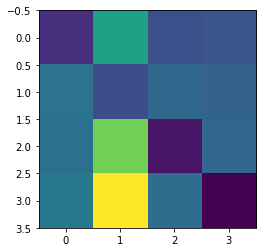

In [21]:
# results = [
#     [0.0575366208013971,  0.21946160319965466, 0.09611605852443725, 0.1036315245532617],
#     [0.14772686197972515, 0.09376976712589051, 0.13209007436789572, 0.12334595643490553],
#     [0.14145088552668658, 0.30052163024467704, 0.02568042629891832, 0.12833078268311918],
#     [0.1571020394966826,  0.3794132545431084,  0.14032048599250616, 0.005571909863850451]
# ]
print(results)
plt.imshow(results, interpolation='none')
# plt.axes.set_xticklabels(CIC_2018_benign_dic['models'])
plt.show()

## USB-IDS DoS

In [22]:
USB_IDS_DoS_dic = {
    'models' : [
        'USB_IDS_Hulk.pt',
        'USB_IDS_slowhttptest.pt',
        'USB_IDS_slowloris.pt',
        'USB_IDS_tcpflood.pt'
    ],
    'datasets' : [
        'USB_IDS_Hulk.csv',
        'USB_IDS_slowhttptest.csv',
        'USB_IDS_slowloris.csv',
        'USB_IDS_tcpflood.csv'
    ],
    'results' : {}
}

cross_test_models(USB_IDS_DoS_dic, 'composite_datasets/')

USB_IDS_Hulk.pt
USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:58<00:00:00  682.10it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:34<00:00:00  673.71it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:10<00:00:00  670.05it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_tcpflood.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:59<00:00:00  668.73it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.pt
USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:56<00:00:00  705.80it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:30<00:00:00  743.71it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:09<00:00:00  740.99it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_tcpflood.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:53<00:00:00  744.83it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.pt
USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:53<00:00:00  747.21it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:30<00:00:00  748.74it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:09<00:00:00  744.98it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_tcpflood.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:54<00:00:00  735.79it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_tcpflood.pt
USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:53<00:00:00  745.42it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:30<00:00:00  746.95it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:09<00:00:00  745.61it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_tcpflood.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:53<00:00:00  746.24it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [23]:
USB_IDS_DoS_dic['results_mean'] = {}
for model in USB_IDS_DoS_dic['results']:
    print(model)
    USB_IDS_DoS_dic['results_mean'][model] = {}
    for dataset in USB_IDS_DoS_dic['results'][model]:
        print(f'\t{dataset}')
        USB_IDS_DoS_dic['results_mean'][model][dataset] = np.mean(USB_IDS_DoS_dic['results'][model][dataset])
    
results = []

for model_name in USB_IDS_DoS_dic['models']:
    results.append([])
    for dataset_name in USB_IDS_DoS_dic['datasets']:
        results[-1].append(USB_IDS_DoS_dic['results_mean'][model_name][dataset_name])

USB_IDS_Hulk.pt
	USB_IDS_Hulk.csv
	USB_IDS_slowhttptest.csv
	USB_IDS_slowloris.csv
	USB_IDS_tcpflood.csv
USB_IDS_slowhttptest.pt
	USB_IDS_Hulk.csv
	USB_IDS_slowhttptest.csv
	USB_IDS_slowloris.csv
	USB_IDS_tcpflood.csv
USB_IDS_slowloris.pt
	USB_IDS_Hulk.csv
	USB_IDS_slowhttptest.csv
	USB_IDS_slowloris.csv
	USB_IDS_tcpflood.csv
USB_IDS_tcpflood.pt
	USB_IDS_Hulk.csv
	USB_IDS_slowhttptest.csv
	USB_IDS_slowloris.csv
	USB_IDS_tcpflood.csv


[[0.05840763354268856, 0.2396752991157703, 0.20737481596393617, 0.13128627998149023], [0.17860779735185206, 0.09496526651603893, 0.2217993009291949, 0.17424813663363456], [0.15104411196317524, 0.21663774781764122, 0.10845641180241583, 0.1453910734849982], [0.12359981078365817, 0.2814670069047697, 0.1974918493158555, 0.052794398448301944]]


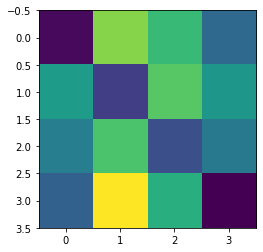

In [24]:
# results = [
#     [0.05840763354268856, 0.2396752991157703,  0.20737481596393617, 0.13128627998149023],
#     [0.17860779735185206, 0.09496526651603893, 0.2217993009291949,  0.17424813663363456],
#     [0.15104411196317524, 0.21663774781764122, 0.10845641180241583, 0.1453910734849982],
#     [0.12359981078365817, 0.2814670069047697,  0.1974918493158555,  0.052794398448301944]
# ]
print(results)
plt.imshow(results, interpolation='none')
# plt.axes.set_xticklabels(CIC_2018_benign_dic['models'])
plt.show()

## Cross-DoS

In [27]:
cross_DoS_dic = {
    'models' : [
        'CIC-IDS-2017_DoS.pt',
        'CIC-IDS-2018_DoS.pt',
        'USB_IDS_DoS.pt'
    ],
    'datasets' : [
        'CIC-IDS-2017_DoS.csv',
        'CIC-IDS-2018_DoS.csv',
        'USB_IDS_DoS.csv'
    ],
    'results' : {}
}

cross_test_models(cross_DoS_dic, 'composite_datasets/')

CIC-IDS-2017_DoS.pt
CIC-IDS-2017_DoS.csv


    Iters       Elapsed Time       Speed                                        
 21996/21996  00:00:35<00:00:00  617.55it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_DoS.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:13<00:00:00  547.53it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_DoS.csv


    Iters       Elapsed Time       Speed                                        
 28512/28512  00:00:45<00:00:00  626.80it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_DoS.pt
CIC-IDS-2017_DoS.csv


    Iters       Elapsed Time       Speed                                        
 21996/21996  00:00:42<00:00:00  523.13it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_DoS.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:17<00:00:00  517.92it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_DoS.csv


    Iters       Elapsed Time       Speed                                        
 28512/28512  00:00:55<00:00:00  517.41it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_DoS.pt
CIC-IDS-2017_DoS.csv


    Iters       Elapsed Time       Speed                                        
 21996/21996  00:00:43<00:00:00  502.82it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_DoS.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:12<00:00:00  554.31it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_DoS.csv


    Iters       Elapsed Time       Speed                                        
 28512/28512  00:00:50<00:00:00  565.36it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [28]:
cross_DoS_dic['results_mean'] = {}
for model in cross_DoS_dic['results']:
    print(model)
    cross_DoS_dic['results_mean'][model] = {}
    for dataset in cross_DoS_dic['results'][model]:
        print(f'\t{dataset}')
        cross_DoS_dic['results_mean'][model][dataset] = np.mean(cross_DoS_dic['results'][model][dataset])
    
results = []

for model_name in cross_DoS_dic['models']:
    results.append([])
    for dataset_name in cross_DoS_dic['datasets']:
        results[-1].append(cross_DoS_dic['results_mean'][model_name][dataset_name])

CIC-IDS-2017_DoS.pt
	CIC-IDS-2017_DoS.csv
	CIC-IDS-2018_DoS.csv
	USB_IDS_DoS.csv
CIC-IDS-2018_DoS.pt
	CIC-IDS-2017_DoS.csv
	CIC-IDS-2018_DoS.csv
	USB_IDS_DoS.csv
USB_IDS_DoS.pt
	CIC-IDS-2017_DoS.csv
	CIC-IDS-2018_DoS.csv
	USB_IDS_DoS.csv


In [14]:
cross_DoS_hulk_dic = {
    'models' : [
        'dcWednesday-workingHours-DoS Hulk.pt',
        'd02-16-2018-DoS attacks-Hulk.pt',
        'USB_IDS_Hulk.pt'
    ],
    'datasets' : [
        'CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv',
        'CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv',
        'composite_datasets/USB_IDS_Hulk.csv'
    ],
    'results' : {}
}

cross_test_models(cross_DoS_hulk_dic, '')

dcWednesday-workingHours-DoS Hulk.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:03:23<00:00:00  492.09it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:03:00<00:00:00  554.51it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:03<00:00:00  634.20it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:43<00:00:00  612.30it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:58<00:00:00  559.33it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:12<00:00:00  551.76it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_Hulk.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:47<00:00:00  597.33it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:53<00:00:00  575.96it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:05<00:00:00  610.09it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

In [22]:
cross_DoS_hulk_dic['results_mean'] = {}
for model in cross_DoS_hulk_dic['results']:
    print(model)
    cross_DoS_hulk_dic['results_mean'][model] = {}
    for dataset in cross_DoS_hulk_dic['results'][model]:
        print(f'\t{dataset}')
        cross_DoS_hulk_dic['results_mean'][model][dataset] = np.mean(cross_DoS_hulk_dic['results'][model][dataset])
    
results = []

for model_name in cross_DoS_hulk_dic['models']:
    results.append([])
    for dataset_name in cross_DoS_hulk_dic['datasets']:
        results[-1].append(cross_DoS_hulk_dic['results_mean'][model_name][dataset_name])

dcWednesday-workingHours-DoS Hulk.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
	composite_datasets/USB_IDS_Hulk.csv
d02-16-2018-DoS attacks-Hulk.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
	composite_datasets/USB_IDS_Hulk.csv
USB_IDS_Hulk.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
	composite_datasets/USB_IDS_Hulk.csv


In [32]:
cross_DoS_HTTP_dic = {
    'models' : [
        'dcWednesday-workingHours-DoS Slowhttptest.pt',
        'd02-16-2018-DoS attacks-SlowHTTPTest.pt',
        'USB_IDS_slowhttptest.pt'
    ],
    'datasets' : [
        'CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv',
        'CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv',
        'composite_datasets/USB_IDS_slowhttptest.csv'
    ],
    'results' : {}
}

cross_test_models(cross_DoS_HTTP_dic, '')

dcWednesday-workingHours-DoS Slowhttptest.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv


   Iters      Elapsed Time       Speed                                          
 5499/5499  00:00:07<00:00:00  689.10it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  656.93it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:40<00:00:00  573.95it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-SlowHTTPTest.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv


   Iters      Elapsed Time       Speed                                          
 5499/5499  00:00:11<00:00:00  493.91it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:03:18<00:00:00  503.18it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:34<00:00:00  659.30it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowhttptest.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv


   Iters      Elapsed Time       Speed                                          
 5499/5499  00:00:08<00:00:00  653.52it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:36<00:00:00  640.67it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowhttptest.csv


    Iters       Elapsed Time       Speed                                        
 23020/23020  00:00:34<00:00:00  661.62it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

dcWednesday-workingHours-DoS Slowhttptest.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv
	composite_datasets/USB_IDS_slowhttptest.csv
d02-16-2018-DoS attacks-SlowHTTPTest.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv
	composite_datasets/USB_IDS_slowhttptest.csv
USB_IDS_slowhttptest.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Slowhttptest.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-SlowHTTPTest.csv
	composite_datasets/USB_IDS_slowhttptest.csv


In [40]:
cross_DoS_slowloris_dic = {
    'models' : [
        'dcWednesday-workingHours-DoS slowloris.pt',
        'd02-15-2018-DoS attacks-Slowloris.pt',
        'USB_IDS_slowloris.pt'
    ],
    'datasets' : [
        'CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv',
        'CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv',
        'composite_datasets/USB_IDS_slowloris.csv'
    ],
    'results' : {}
}

cross_test_models(cross_DoS_slowloris_dic, '')

dcWednesday-workingHours-DoS slowloris.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv


   Iters      Elapsed Time       Speed                                          
 5796/5796  00:00:08<00:00:00  674.11it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:16<00:00:00  649.62it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:11<00:00:00  646.59it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-15-2018-DoS attacks-Slowloris.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv


   Iters      Elapsed Time       Speed                                          
 5796/5796  00:00:09<00:00:00  641.43it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:17<00:00:00  638.43it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:11<00:00:00  639.80it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_slowloris.pt
CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv


   Iters      Elapsed Time       Speed                                          
 5796/5796  00:00:09<00:00:00  634.73it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv


    Iters       Elapsed Time       Speed                                        
 10990/10990  00:00:17<00:00:00  625.25it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_slowloris.csv


   Iters      Elapsed Time       Speed                                          
 7128/7128  00:00:11<00:00:00  629.82it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

dcWednesday-workingHours-DoS slowloris.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv
	CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv
	composite_datasets/USB_IDS_slowloris.csv
d02-15-2018-DoS attacks-Slowloris.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv
	CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv
	composite_datasets/USB_IDS_slowloris.csv
USB_IDS_slowloris.pt
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS slowloris.csv
	CIC-IDS-2018/class_split/d02-15-2018-DoS attacks-Slowloris.csv
	composite_datasets/USB_IDS_slowloris.csv


## Buffet Testing

In [13]:
buffet_dic = {
    'models' : [
        'CIC-IDS-2017_benign.pt',
        'CIC-IDS-2018_benign.pt',
        'USB_IDS_benign.pt',
        'dcWednesday-workingHours-DoS Hulk.pt',
        'd02-16-2018-DoS attacks-Hulk.pt',
        'USB_IDS_Hulk.pt',
        'CIC-IDS-2017_web.pt',
        'CIC-IDS-2018_web.pt'
    ],
    'datasets' : [
        'composite_datasets/CIC-IDS-2017_benign.csv',
        'composite_datasets/CIC-IDS-2018_benign.csv',
        'composite_datasets/USB_IDS_benign.csv',
        'CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv',
        'CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv',
        'composite_datasets/USB_IDS_Hulk.csv',
        'composite_datasets/CIC-IDS-2017_web.csv',
        'composite_datasets/CIC-IDS-2018_web.csv'
    ],
    'results' : {}
}

cross_test_models(buffet_dic, '')

CIC-IDS-2017_benign.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:08<00:00:00  620.23it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:19<00:00:00  646.10it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:35<00:00:00  645.14it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:33<00:00:00  652.28it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  656.64it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:00<00:00:00  661.28it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  651.23it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  632.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_benign.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:03<00:00:00  648.29it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:17<00:00:00  654.44it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  655.70it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  662.69it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:18<00:00:00  724.13it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:54<00:00:00  739.08it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:02<00:00:00  736.73it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  731.57it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_benign.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:11<00:00:00  609.80it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:18<00:00:00  648.24it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:34<00:00:00  649.08it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:35<00:00:00  644.67it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:34<00:00:00  646.44it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:01<00:00:00  646.06it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  645.45it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  632.37it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

dcWednesday-workingHours-DoS Hulk.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:13<00:00:00  599.06it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:37<00:00:00  571.00it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:54<00:00:00  571.52it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:45<00:00:00  604.58it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:19<00:00:00  714.61it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:57<00:00:00  699.12it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  690.20it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  734.76it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

d02-16-2018-DoS attacks-Hulk.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:01:56<00:00:00  685.13it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:09<00:00:00  693.64it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:15<00:00:00  739.80it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:16<00:00:00  731.84it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  661.97it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:01<00:00:00  648.30it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  650.26it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  641.33it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

USB_IDS_Hulk.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:02<00:00:00  653.25it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:16<00:00:00  661.18it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  657.49it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  662.26it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:30<00:00:00  663.42it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:00:59<00:00:00  667.99it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  667.18it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  630.22it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017_web.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:02<00:00:00  651.94it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:15<00:00:00  662.81it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:27<00:00:00  678.15it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:26<00:00:00  683.91it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:31<00:00:00  659.56it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:02<00:00:00  636.63it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  649.87it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  640.66it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018_web.pt
composite_datasets/CIC-IDS-2017_benign.csv


    Iters       Elapsed Time       Speed                                        
 80000/80000  00:02:02<00:00:00  654.12it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_benign.csv


    Iters       Elapsed Time       Speed                                        
 90000/90000  00:02:18<00:00:00  649.78it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_benign.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  656.94it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:32<00:00:00  657.55it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv


     Iters        Elapsed Time       Speed                                      
 100000/100000  00:02:34<00:00:00  648.56it/s                                   

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/USB_IDS_Hulk.csv


    Iters       Elapsed Time       Speed                                        
 40000/40000  00:01:01<00:00:00  647.47it/s                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2017_web.csv


   Iters      Elapsed Time       Speed                                          
 2180/2180  00:00:03<00:00:00  641.74it/s                                       

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

composite_datasets/CIC-IDS-2018_web.csv


  Iters     Elapsed Time       Speed                                            
 928/928  00:00:01<00:00:00  638.46it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

CIC-IDS-2017_benign.pt
	composite_datasets/CIC-IDS-2017_benign.csv
	composite_datasets/CIC-IDS-2018_benign.csv
	composite_datasets/USB_IDS_benign.csv
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
	composite_datasets/USB_IDS_Hulk.csv
	composite_datasets/CIC-IDS-2017_web.csv
	composite_datasets/CIC-IDS-2018_web.csv
CIC-IDS-2018_benign.pt
	composite_datasets/CIC-IDS-2017_benign.csv
	composite_datasets/CIC-IDS-2018_benign.csv
	composite_datasets/USB_IDS_benign.csv
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-IDS-2018/class_split/d02-16-2018-DoS attacks-Hulk.csv
	composite_datasets/USB_IDS_Hulk.csv
	composite_datasets/CIC-IDS-2017_web.csv
	composite_datasets/CIC-IDS-2018_web.csv
USB_IDS_benign.pt
	composite_datasets/CIC-IDS-2017_benign.csv
	composite_datasets/CIC-IDS-2018_benign.csv
	composite_datasets/USB_IDS_benign.csv
	CIC-IDS-2017/class_split/dcWednesday-workingHours-DoS Hulk.csv
	CIC-ID

[[0.12151397828218988, 0.11779729132484644, 0.15667523578484568], [0.14547492070571516, 0.09521137322532013, 0.1664436768689982], [0.15203725483934433, 0.1340951770601794, 0.12440341411265059]]


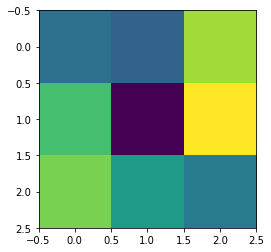

In [29]:
# results = [
#     [0.12151397828218988, 0.11779729132484644, 0.15667523578484568],
#     [0.14547492070571516, 0.09521137322532013, 0.1664436768689982],
#     [0.15203725483934433, 0.1340951770601794,  0.12440341411265059]
# ]
print(results)
plt.imshow(results, interpolation='none')
# plt.axes.set_xticklabels(CIC_2018_benign_dic['models'])
plt.show()

## Cross Web Dataset

In [14]:
cross_web_dataset_dic = {
    'models' : [
        'CIC-IDS-2017_web.pt',
        'CIC-IDS-2018_web.pt'
    ],
    'datasets' : [
        'CIC-IDS-2017_web.csv',
        'CIC-IDS-2018_web.csv'
    ],
    'results' : {}
}

cross_test_models(cross_web_dataset_dic, 'composite_datasets/')

In [32]:
cross_web_dataset_dic['results_mean'] = {}
for model in cross_web_dataset_dic['results']:
    print(model)
    cross_web_dataset_dic['results_mean'][model] = {}
    for dataset in cross_web_dataset_dic['results'][model]:
        print(f'\t{dataset}')
        cross_web_dataset_dic['results_mean'][model][dataset] = np.mean(cross_web_dataset_dic['results'][model][dataset])
    
results = []

for model_name in cross_web_dataset_dic['models']:
    results.append([])
    for dataset_name in cross_web_dataset_dic['datasets']:
        results[-1].append(cross_web_dataset_dic['results_mean'][model_name][dataset_name])

CIC-IDS-2017_web.pt
	CIC-IDS-2017_web.csv
	CIC-IDS-2018_web.csv
CIC-IDS-2018_web.pt
	CIC-IDS-2017_web.csv
	CIC-IDS-2018_web.csv


[[0.027862056800102338, 0.20693486333214517], [0.11991797495257417, 0.09143310522355524]]


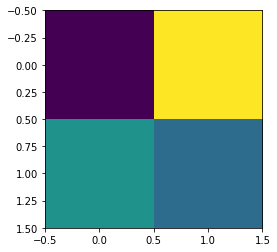

In [13]:
# results = [
#     [0.027862056800102338, 0.20693486333214517],
#     [0.11991797495257417,  0.09143310522355524]
# ]
print(results)
plt.imshow(results, interpolation='none')
# plt.axes.set_xticklabels(CIC_2018_benign_dic['models'])
plt.show()

In [35]:
results = [
    [0.027862056800102338, 0.20693486333214517],
    [0.11991797495257417,  0.09143310522355524]
]

In [32]:
for row in range(2):
    x = results[row][row]
    for col in range(2):
        results[row][col] = results[row][col]/x

In [33]:
for row in results:
    print(row)

[1.0, 7.42712086249803]
[1.3115378140048182, 1.0]


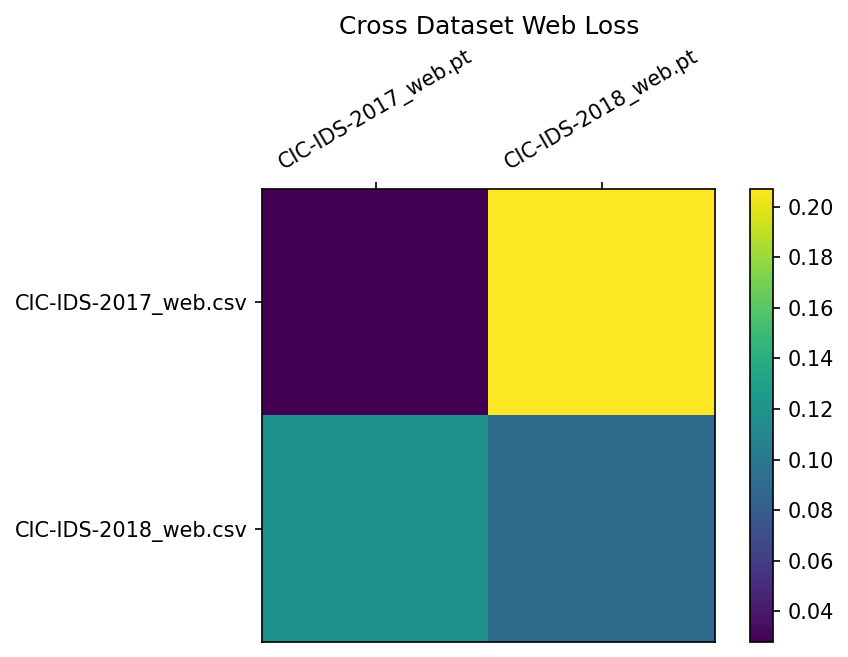

In [66]:
plot_cross_test(results, 'Cross Dataset Web Loss', cross_web_dataset_dic['models'], cross_web_dataset_dic['datasets'])

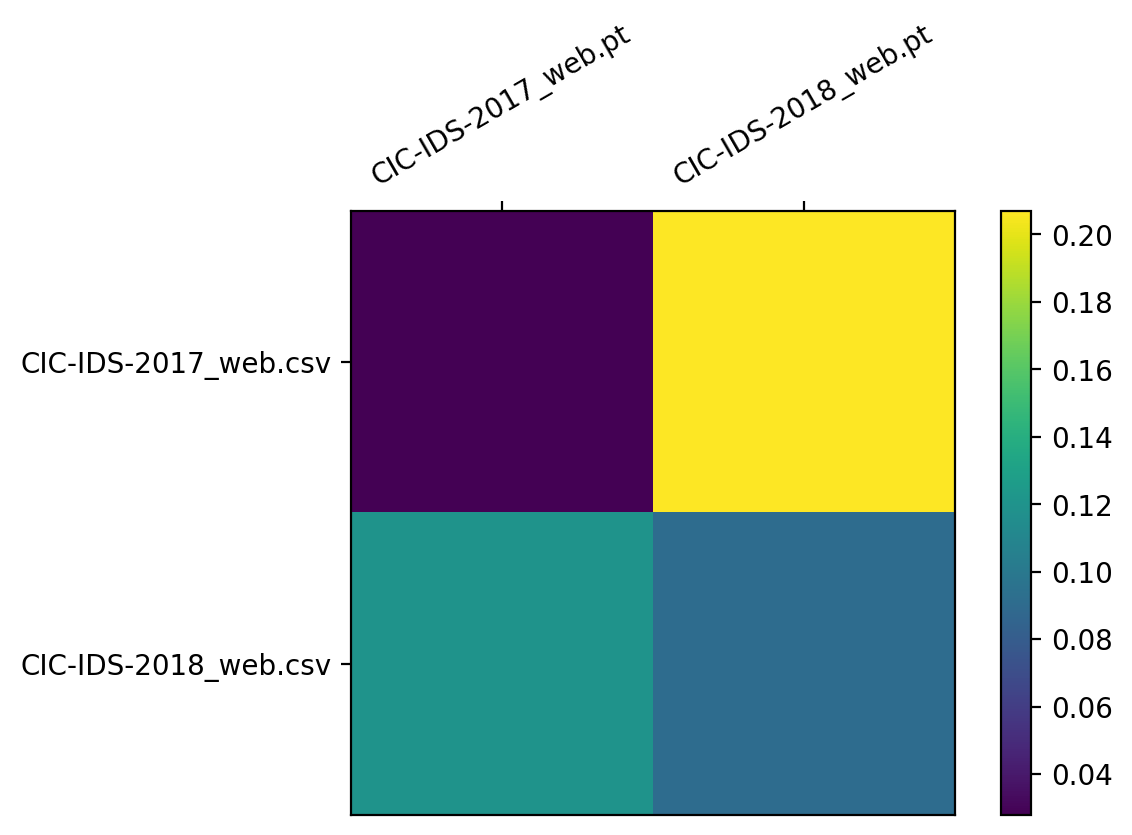

In [36]:
# plt.figure(dpi=200)
fig, ax = plt.subplots(1,1)
fig.dpi = 200
img = ax.imshow(results,interpolation='none')
x_label_list = cross_web_dataset_dic['models']
ax.xaxis.tick_top()
ax.set_xticks([0, 1])
ax.set_xticklabels(x_label_list,rotation=30)
ax.set_yticks([0,1])
ax.set_yticklabels(cross_web_dataset_dic['datasets'])
fig.colorbar(img)

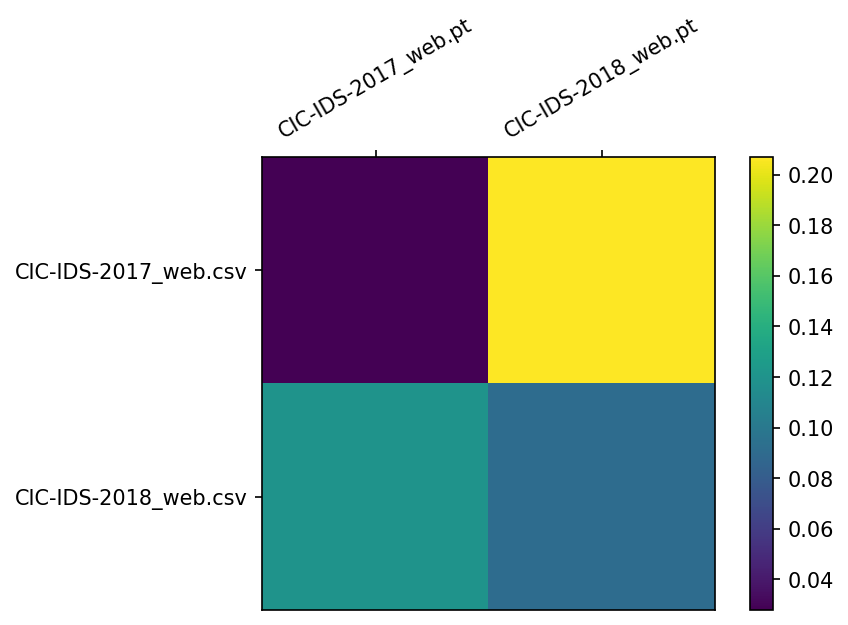

In [43]:
plot_cross_test(results, cross_web_dataset_dic['models'], cross_web_dataset_dic['datasets'])

## Save files

In [14]:
# CIC_2018_benign_dic
# CIC_2018_DoS_dic
# USB_IDS_DoS_dic
# cross_DoS_dic
# cross_web_dataset_dic
# with open(workspace_dir + 'cross_test_results/CIC_2018_benign.data','wb') as f:
# 	pickle.dump(CIC_2018_benign_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/CIC_2018_DoS.data','wb') as f:
# 	pickle.dump(CIC_2018_DoS_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/USB_IDS_DoS.data','wb') as f:
# 	pickle.dump(USB_IDS_DoS_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/cross_DoS_dataset.data','wb') as f:
# 	pickle.dump(cross_DoS_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/cross_web_dataset.data','wb') as f:
# 	pickle.dump(cross_web_dataset_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/cross_DoS_hulk.data', 'wb') as f:
# 	pickle.dump(cross_DoS_hulk_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/cross_DoS_HTTP.data', 'wb') as f:
# 	pickle.dump(cross_DoS_HTTP_dic, f, pickle.HIGHEST_PROTOCOL)

# with open(workspace_dir + 'cross_test_results/cross_DoS_slowloris.data', 'wb') as f:
# 	pickle.dump(cross_DoS_slowloris_dic, f, pickle.HIGHEST_PROTOCOL)

with open(workspace_dir + 'cross_test_results/buffet.data', 'wb') as f:
	pickle.dump(buffet_dic, f, pickle.HIGHEST_PROTOCOL)

## Load Files

In [11]:
save_files = [
    workspace_dir + 'cross_test_results/CIC_2017_benign.data',
    workspace_dir + 'cross_test_results/CIC_2018_benign.data',
    workspace_dir + 'cross_test_results/CIC_2017_DoS.data',
    workspace_dir + 'cross_test_results/CIC_2018_DoS.data',
    workspace_dir + 'cross_test_results/USB_IDS_DoS.data',
    workspace_dir + 'cross_test_results/cross_benign_dataset.data',
    workspace_dir + 'cross_test_results/cross_DoS_dataset.data',
    workspace_dir + 'cross_test_results/cross_DoS_class.data',
    workspace_dir + 'cross_test_results/cross_web_dataset.data',
    workspace_dir + 'cross_test_results/cross_web_class.data',
    workspace_dir + 'cross_test_results/cross_DoS_hulk.data',
    workspace_dir + 'cross_test_results/cross_DoS_HTTP.data',
    workspace_dir + 'cross_test_results/cross_DoS_slowloris.data',
    workspace_dir + 'cross_test_results/buffet.data'
]

In [12]:
results_dic = {}
for file in save_files:
    df_file = open(file, 'rb')
    res = pickle.load(df_file)
    results_dic[file.strip().split('/')[-1][:-5]] = res
    df_file.close()


In [21]:
for key in results_dic:
    print(key)
    for key2 in results_dic[key]:
        print('\t', key2)

CIC_2017_benign
	 models
	 datasets
	 results
	 results_mean
CIC_2018_benign
	 models
	 datasets
	 results
	 results_mean
CIC_2017_DoS
	 models
	 datasets
	 results
	 results_mean
CIC_2018_DoS
	 models
	 datasets
	 results
	 results_mean
USB_IDS_DoS
	 models
	 datasets
	 results
	 results_mean
cross_benign_dataset
	 models
	 datasets
	 results
	 results_mean
cross_DoS_dataset
	 models
	 datasets
	 results
	 results_mean
cross_DoS_class
	 models
	 datasets
	 results
	 results_mean
cross_web_dataset
	 models
	 datasets
	 results
	 results_mean
cross_web_class
	 models
	 datasets
	 results
	 results_mean
cross_DoS_hulk
	 models
	 datasets
	 results
	 results_mean
cross_DoS_HTTP
	 models
	 datasets
	 results
	 results_mean
cross_DoS_slowloris
	 models
	 datasets
	 results
	 results_mean
buffet
	 models
	 datasets
	 results
	 results_mean


In [34]:
results = [
    [0.05840763354268856, 0.17860779735185206, 0.15104411196317524, 0.12359981078365817],
    [0.2396752991157703, 0.09496526651603893, 0.21663774781764122, 0.2814670069047697],
    [0.20737481596393617, 0.2217993009291949, 0.10845641180241583, 0.1974918493158555],
    [0.13128627998149023, 0.17424813663363456, 0.1453910734849982, 0.052794398448301944]
]

for row_i in range(len(results)):
    x = results[row_i][row_i]
    for col_i in range(len(results)):
        results[row_i][col_i] = (results[row_i][col_i] - x)/x

for e in results:
    print(e)

[0.0, 2.0579529852260228, 1.5860337562346398, 1.1161585102283318]
[1.5238206336765339, 0.0, 1.2812313992827338, 1.9638942450314931]
[0.9120567656408209, 1.0450547574196474, 0.0, 0.8209329078269989]
[1.4867463943177643, 2.3005042533871127, 1.753910978403704, 0.0]


In [14]:
def plot_results_w_custom_axis_labels(dic, label, xlabels, ylabels):
    res_arr = []
    n=len(dic['models'])
    for row_i in range(n):
        res_arr.append([None] * n)
        dataset_name = dic['datasets'][row_i]
        for col_i in range(n):
            model_name = dic['models'][col_i]
            res_arr[row_i][col_i] = dic['results_mean'][model_name][dataset_name]

    plot_cross_test(res_arr, label, xlabels, ylabels)

plot saved to ./plots/CIC-IDS 2017 Benign.png


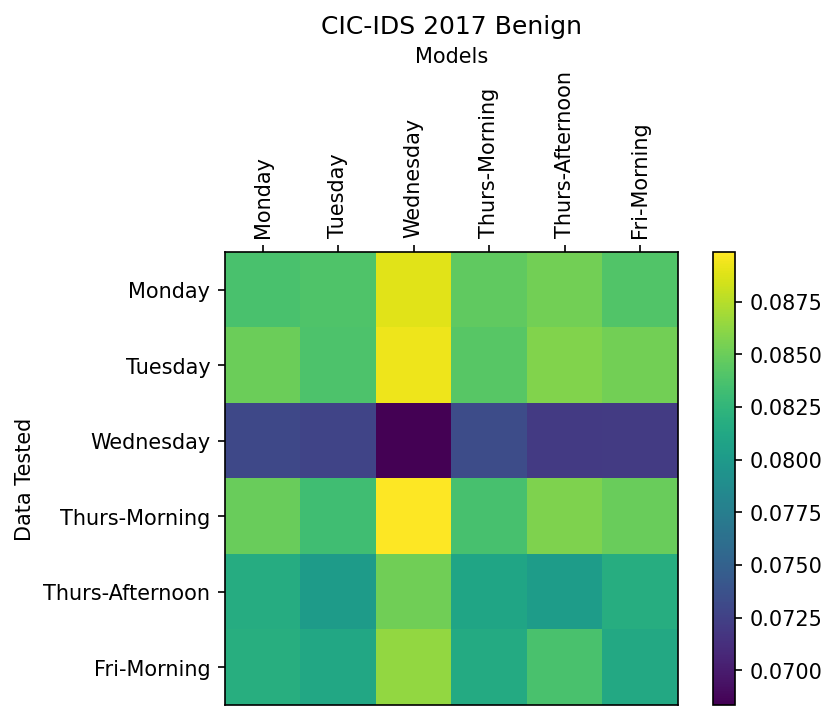

In [30]:
plot_results_w_custom_axis_labels(results_dic['CIC_2017_benign'], 'CIC-IDS 2017 Benign', 
    ['Monday', 'Tuesday', 'Wednesday', 'Thurs-Morning', 'Thurs-Afternoon', 'Fri-Morning'], 
    ['Monday', 'Tuesday', 'Wednesday', 'Thurs-Morning', 'Thurs-Afternoon', 'Fri-Morning']
)

plot saved to ./plots/CIC-IDS 2018 Benign.png


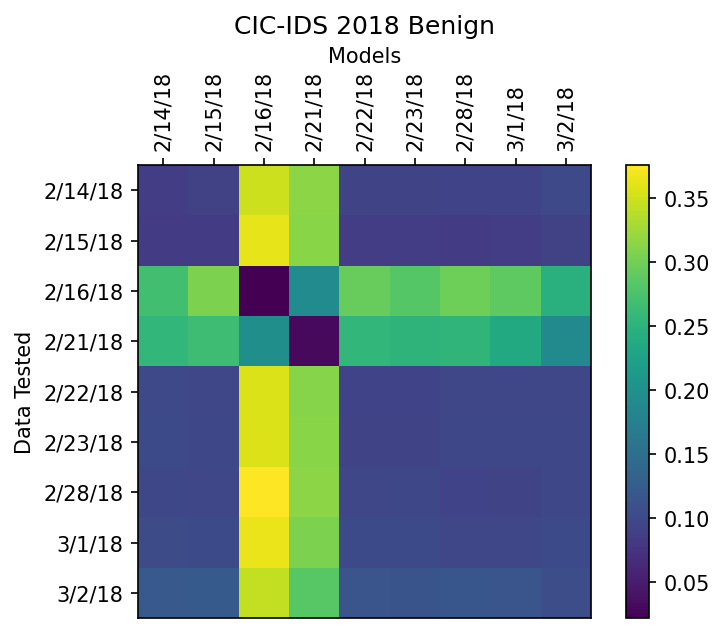

In [31]:
# plot_results_w_custom_axis_labels(results_dic['CIC_2018_benign'], 'CIC_2018_benign', 
#     ['2-14-benign.pt', '2-15-benign.pt', '2-16-benign.pt', '2-21-benign.pt', '2-22-benign.pt', '2-23-benign.pt', '2-28-benign.pt', '3-1-benign.pt', '3-2-benign.pt'], 
#     ['2-14-benign.csv', '2-15-benign.csv', '2-16-benign.csv', '2-21-benign.csv', '2-22-benign.csv', '2-23-benign.csv', '2-28-benign.csv', '3-1-benign.csv', '3-2-benign.csv']
# )

plot_results_w_custom_axis_labels(results_dic['CIC_2018_benign'], 'CIC-IDS 2018 Benign', 
    ['2/14/18', '2/15/18', '2/16/18', '2/21/18', '2/22/18', '2/23/18', '2/28/18', '3/1/18', '3/2/18'], 
    ['2/14/18', '2/15/18', '2/16/18', '2/21/18', '2/22/18', '2/23/18', '2/28/18', '3/1/18', '3/2/18']
)

plot saved to ./plots/Benign by Dataset.png


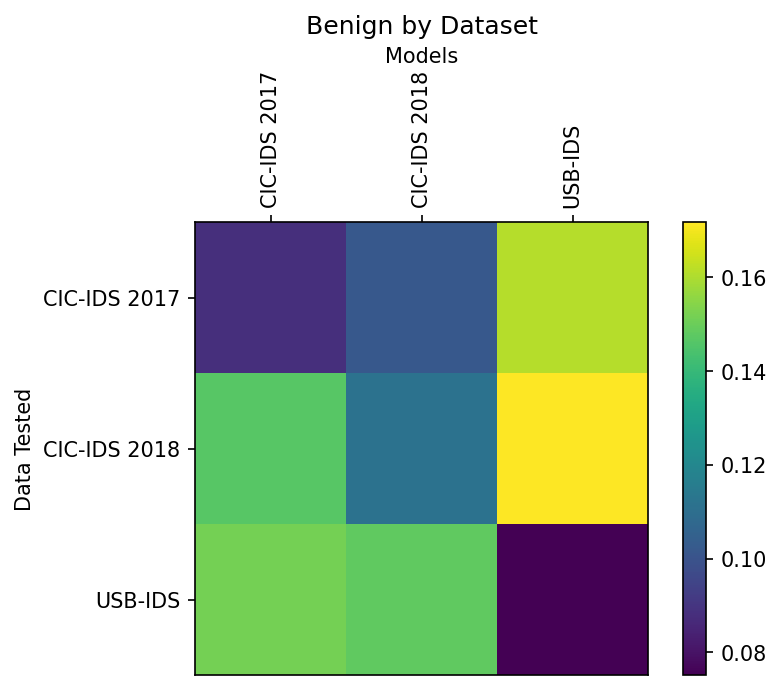

In [32]:
# plot_results_w_custom_axis_labels(results_dic['cross_benign_dataset'], 'cross_benign_dataset', 
#     ['CIC-IDS-2017-benign.pt', 'CIC-IDS-2018-benign.pt', 'USB-IDS-benign.pt'], 
#     ['CIC-IDS-2017-benign.csv', 'CIC-IDS-2018-benign.csv', 'USB-IDS-benign.csv']
# )

plot_results_w_custom_axis_labels(results_dic['cross_benign_dataset'], 'Benign by Dataset', 
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS'], 
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS']
)

plot saved to ./plots/CIC-IDS 2017 DoS.png


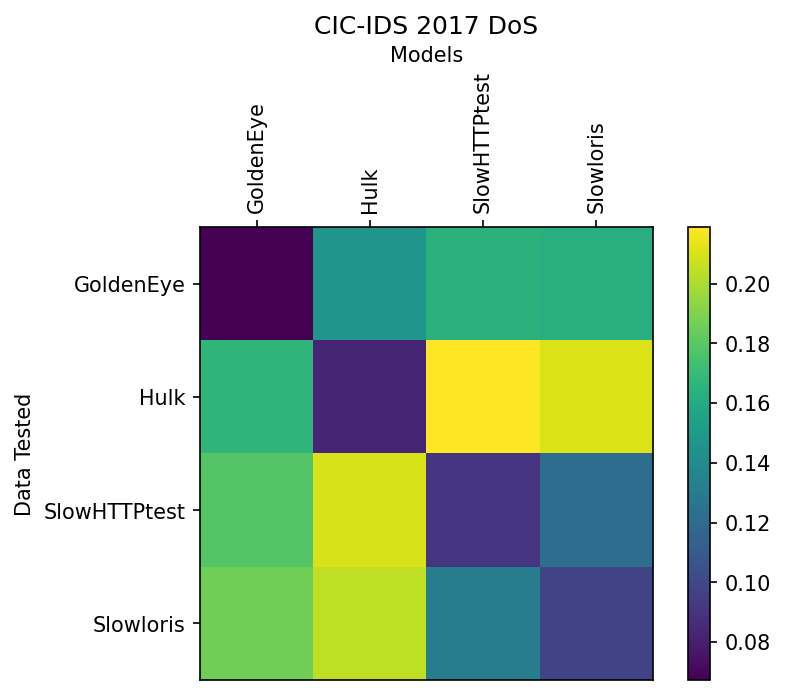

In [33]:
# plot_results_w_custom_axis_labels(results_dic['CIC_2017_DoS'], 'CIC_2017_DoS', 
#     ['GoldenEye.pt', 'Hulk.pt', 'SlowHTTPtest.pt', 'Slowloris.pt'], 
#     ['GoldenEye.csv', 'Hulk.csv', 'SlowHTTPtest.csv', 'Slowloris.csv']
# )

plot_results_w_custom_axis_labels(results_dic['CIC_2017_DoS'], 'CIC-IDS 2017 DoS', 
    ['GoldenEye', 'Hulk', 'SlowHTTPtest', 'Slowloris'], 
    ['GoldenEye', 'Hulk', 'SlowHTTPtest', 'Slowloris']
)

plot saved to ./plots/CIC-IDS 2018 DoS.png


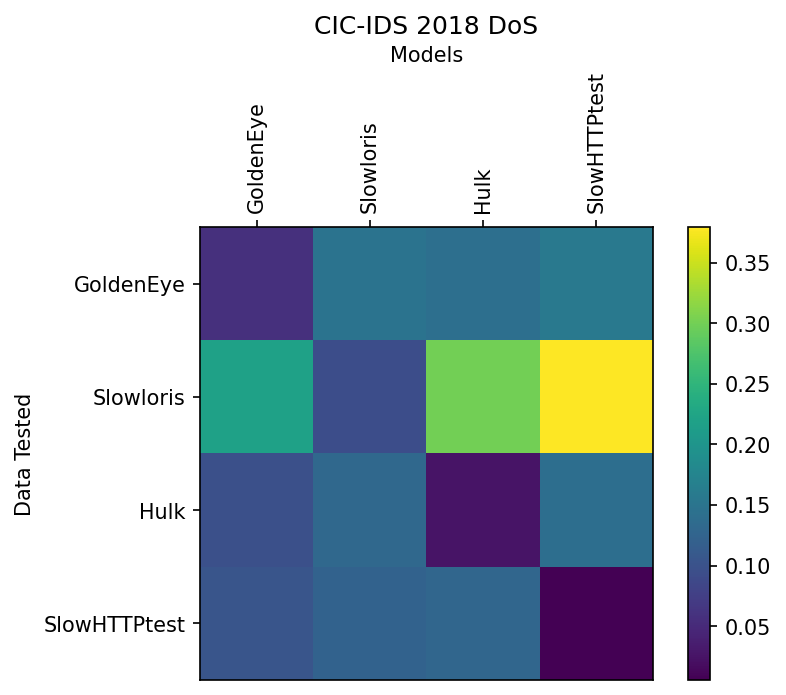

In [34]:
plot_results_w_custom_axis_labels(results_dic['CIC_2018_DoS'], 'CIC-IDS 2018 DoS', 
    ['GoldenEye', 'Slowloris', 'Hulk', 'SlowHTTPtest'], 
    ['GoldenEye', 'Slowloris', 'Hulk', 'SlowHTTPtest']
)

plot saved to ./plots/USB-IDS DoS.png


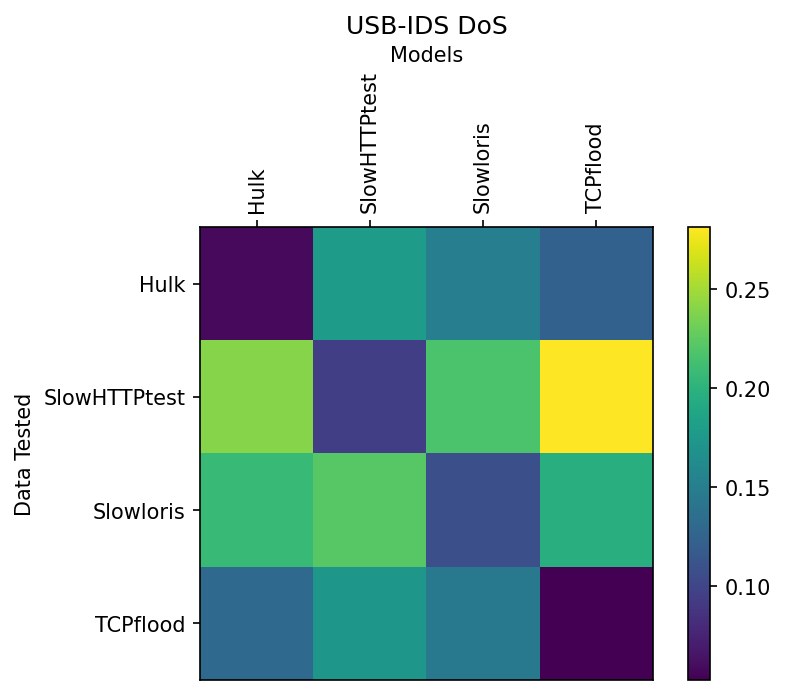

In [35]:
plot_results_w_custom_axis_labels(results_dic['USB_IDS_DoS'], 'USB-IDS DoS', 
    ['Hulk', 'SlowHTTPtest', 'Slowloris', 'TCPflood'], 
    ['Hulk', 'SlowHTTPtest', 'Slowloris', 'TCPflood']
)

In [23]:
# plot_results_w_custom_axis_labels(results_dic['CIC_2017_DoS'], 'CIC_2017_DoS', 
#     ['Wednesday-GoldenEye.pt', 'Wednesday-Hulk.pt', 'Wednesday-SlowHTTPtest.pt', 'Wednesday-Slowloris.pt'],
#     ['Wednesday-GoldenEye.csv', 'Wednesday-Hulk.csv', 'Wednesday-SlowHTTPtest.csv', 'Wednesday-Slowloris.csv']
# )

plot saved to ./plots/Hulk DoS by Dataset.png


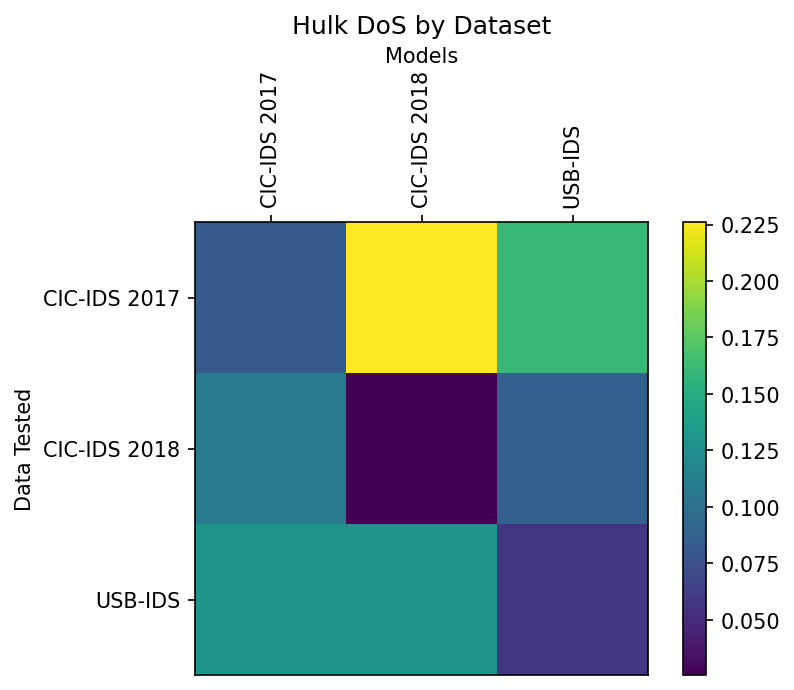

In [36]:
# plot_results_w_custom_axis_labels(results_dic['cross_DoS_hulk'], 'cross_DoS_hulk', 
#     ['CIC 2017 Hulk.pt', 'CIC 2018 Hulk.pt', 'USB IDS Hulk.pt'],
#     ['CIC 2017 Hulk.csv', 'CIC 2018 Hulk.csv', 'USB IDS Hulk.csv']
# )

plot_results_w_custom_axis_labels(results_dic['cross_DoS_hulk'], 'Hulk DoS by Dataset', 
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS'],
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS'],
)

plot saved to ./plots/SlowHTTPtest DoS by Dataset.png


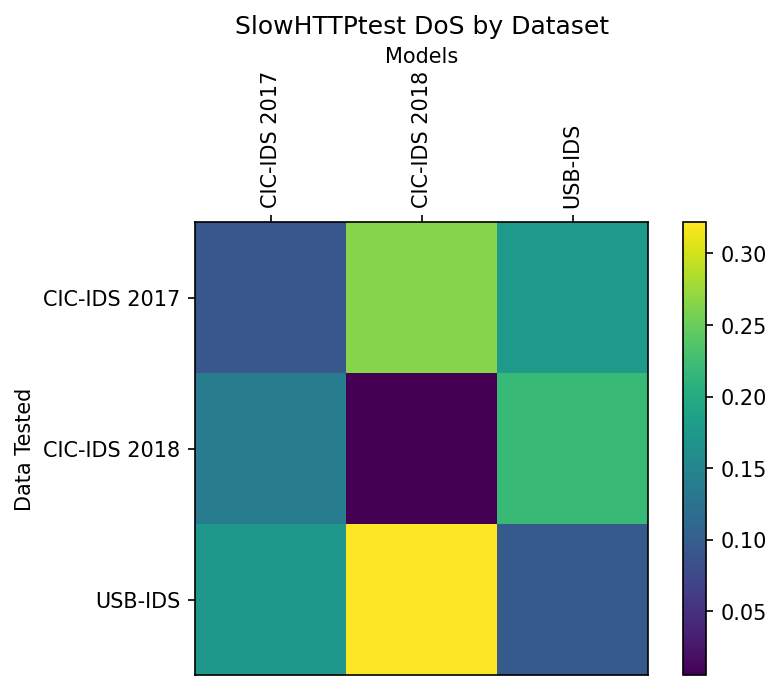

In [37]:
# plot_results_w_custom_axis_labels(results_dic['cross_DoS_HTTP'], 'cross_DoS_HTTP',
#     ['CIC 2017 SlowHTTPtest.pt', 'CIC 2018 SlowHTTPtest.pt', 'USB IDS SlowHTTPtest.pt'],
#     ['CIC 2017 SlowHTTPtest.csv', 'CIC 2018 SlowHTTPtest.csv', 'USB IDS SlowHTTPtest.csv']
# )

plot_results_w_custom_axis_labels(results_dic['cross_DoS_HTTP'], 'SlowHTTPtest DoS by Dataset',
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS'],
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS']
)

plot saved to ./plots/Slowloris DoS by Dataset.png


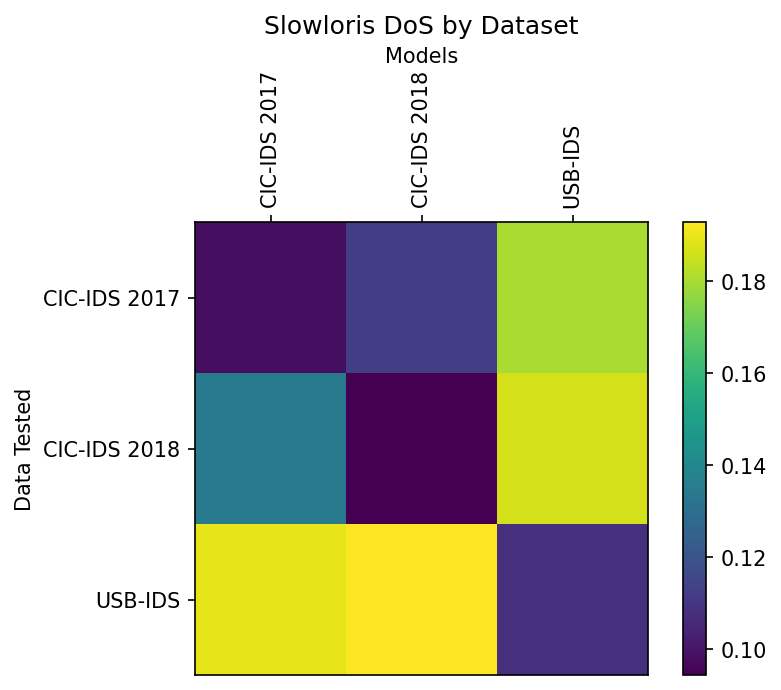

In [38]:
# plot_results_w_custom_axis_labels(results_dic['cross_DoS_slowloris'], 'cross_DoS_slowloris',
#     ['CIC 2017 Slowloris.pt', 'CIC 2018 Slowloris.pt', 'USB IDS Slowloris.pt'],
#     ['CIC 2017 Slowloris.csv', 'CIC 2018 Slowloris.csv', 'USB IDS Slowloris.csv']
# )

plot_results_w_custom_axis_labels(results_dic['cross_DoS_slowloris'], 'Slowloris DoS by Dataset',
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS'],
    ['CIC-IDS 2017', 'CIC-IDS 2018', 'USB-IDS']
)

plot saved to ./plots/Cross Testing Across Benign, Hulk DoS, and Web, by Dataset.png


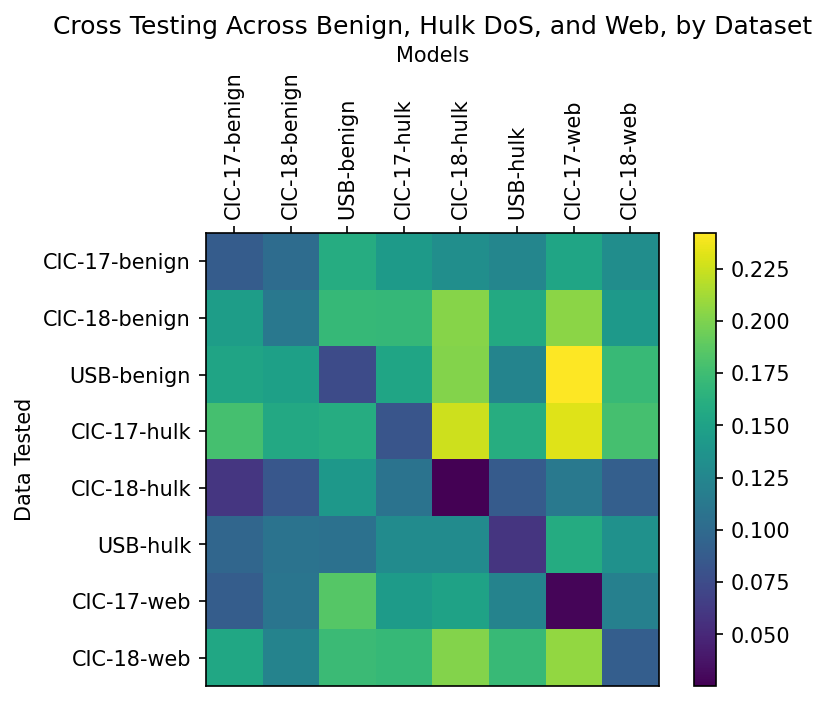

In [39]:
# plot_results_w_custom_axis_labels(results_dic['buffet'], 'buffet', 
#     ['CIC-17-benign.pt', 'CIC-18-benign.pt', 'USB-benign.pt', 'CIC-17-hulk.pt', 'CIC-18-hulk.pt', 'USB-hulk.pt', 'CIC-17-web.pt', 'CIC-18-web.pt'],
#     ['CIC-17-benign.csv', 'CIC-18-benign.csv', 'USB-benign.csv', 'CIC-17-hulk.csv', 'CIC-18-hulk.csv', 'USB-hulk.csv', 'CIC-17-web.csv', 'CIC-18-web.csv']
# )

plot_results_w_custom_axis_labels(results_dic['buffet'], 'Cross Testing Across Benign, Hulk DoS, and Web, by Dataset', 
    ['CIC-17-benign', 'CIC-18-benign', 'USB-benign', 'CIC-17-hulk', 'CIC-18-hulk', 'USB-hulk', 'CIC-17-web', 'CIC-18-web'],
    ['CIC-17-benign', 'CIC-18-benign', 'USB-benign', 'CIC-17-hulk', 'CIC-18-hulk', 'USB-hulk', 'CIC-17-web', 'CIC-18-web']
)

plot saved to ./plots/Web Based by Dataset.png


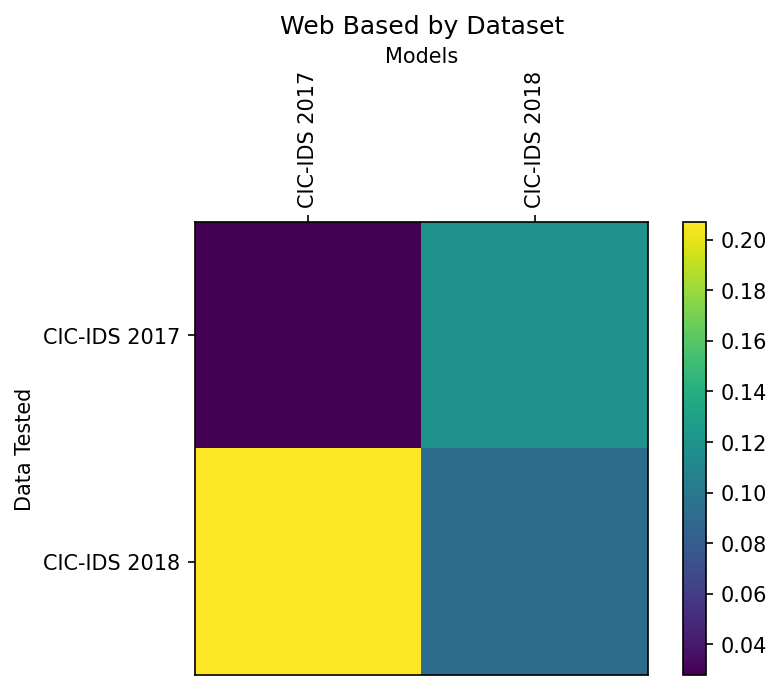

In [40]:
plot_results_w_custom_axis_labels(results_dic['cross_web_dataset'], 'Web Based by Dataset', 
    ['CIC-IDS 2017', 'CIC-IDS 2018'],
    ['CIC-IDS 2017', 'CIC-IDS 2018']
)

plot saved to ./plots/Web Based by Attack Class.png


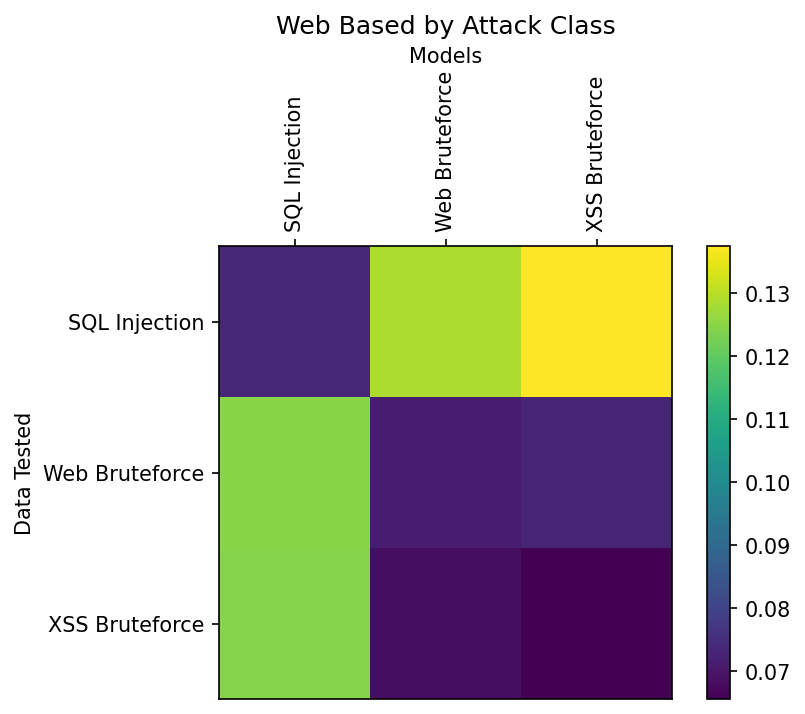

In [41]:
plot_results_w_custom_axis_labels(results_dic['cross_web_class'], 'Web Based by Attack Class', 
    ['SQL Injection', 'Web Bruteforce', 'XSS Bruteforce'],
    ['SQL Injection', 'Web Bruteforce', 'XSS Bruteforce']
)

### Generate Plots

CIC_2017_benign
	 normal results
	  0.0837   0.0839   0.0889   0.0846   0.0853   0.0840 
	  0.0850   0.0839   0.0893   0.0843   0.0858   0.0853 
	  0.0730   0.0727   0.0684   0.0734   0.0720   0.0721 
	  0.0849   0.0833   0.0899   0.0836   0.0857   0.0849 
	  0.0817   0.0802   0.0852   0.0810   0.0803   0.0817 
	  0.0819   0.0812   0.0864   0.0815   0.0837   0.0813 
	max: 0.08985471756224521, min: 0.06835627564419992
	 Scaled to min results:
	  0.2241   0.2274   0.2999   0.2372   0.2473   0.2293 
	  0.2437   0.2269   0.3066   0.2329   0.2550   0.2478 
	  0.0683   0.0642   0.0000   0.0736   0.0533   0.0550 
	  0.2427   0.2181   0.3145   0.2233   0.2539   0.2426 
	  0.1948   0.1729   0.2464   0.1849   0.1743   0.1956 
	  0.1978   0.1884   0.2639   0.1920   0.2243   0.1895 
	 max err: 0.3145057526238916
	 Dataset scaled:
	  0.0000   0.0027   0.0620   0.0107   0.0189   0.0042 
	  0.0137   0.0000   0.0650   0.0048   0.0229   0.0170 
	  0.0683   0.0642   0.0000   0.0736   0.0533   0.0550 
	 

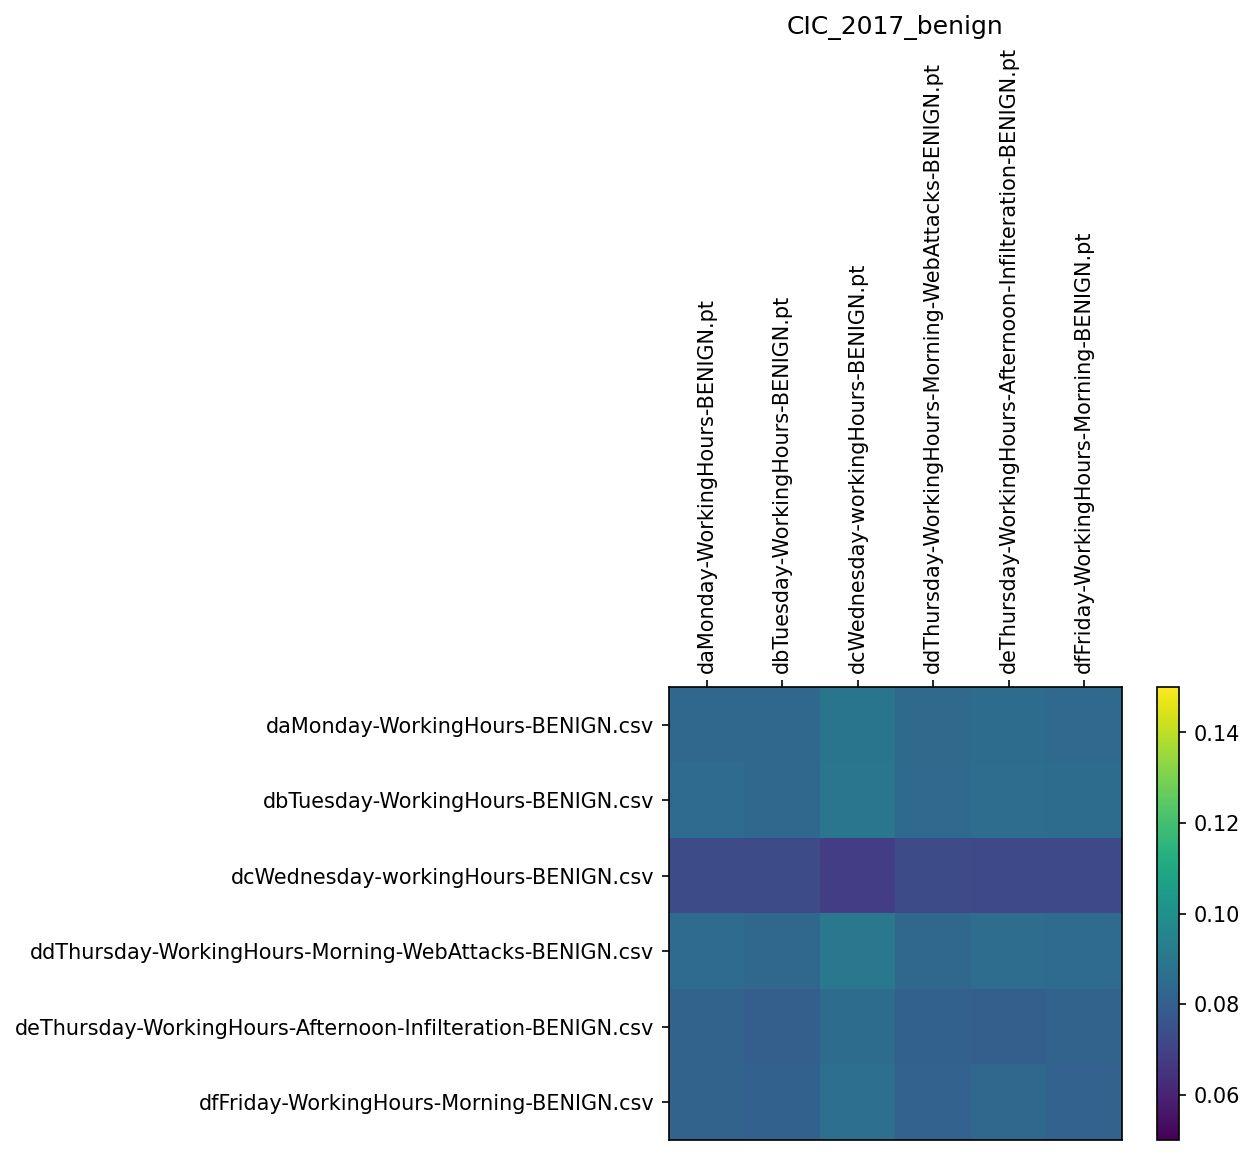

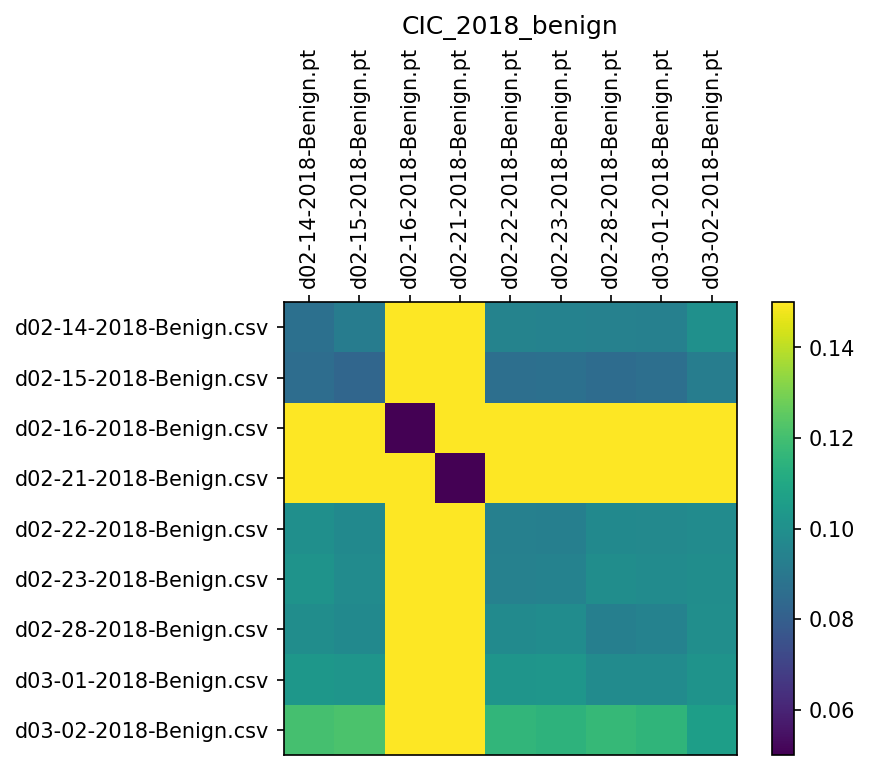

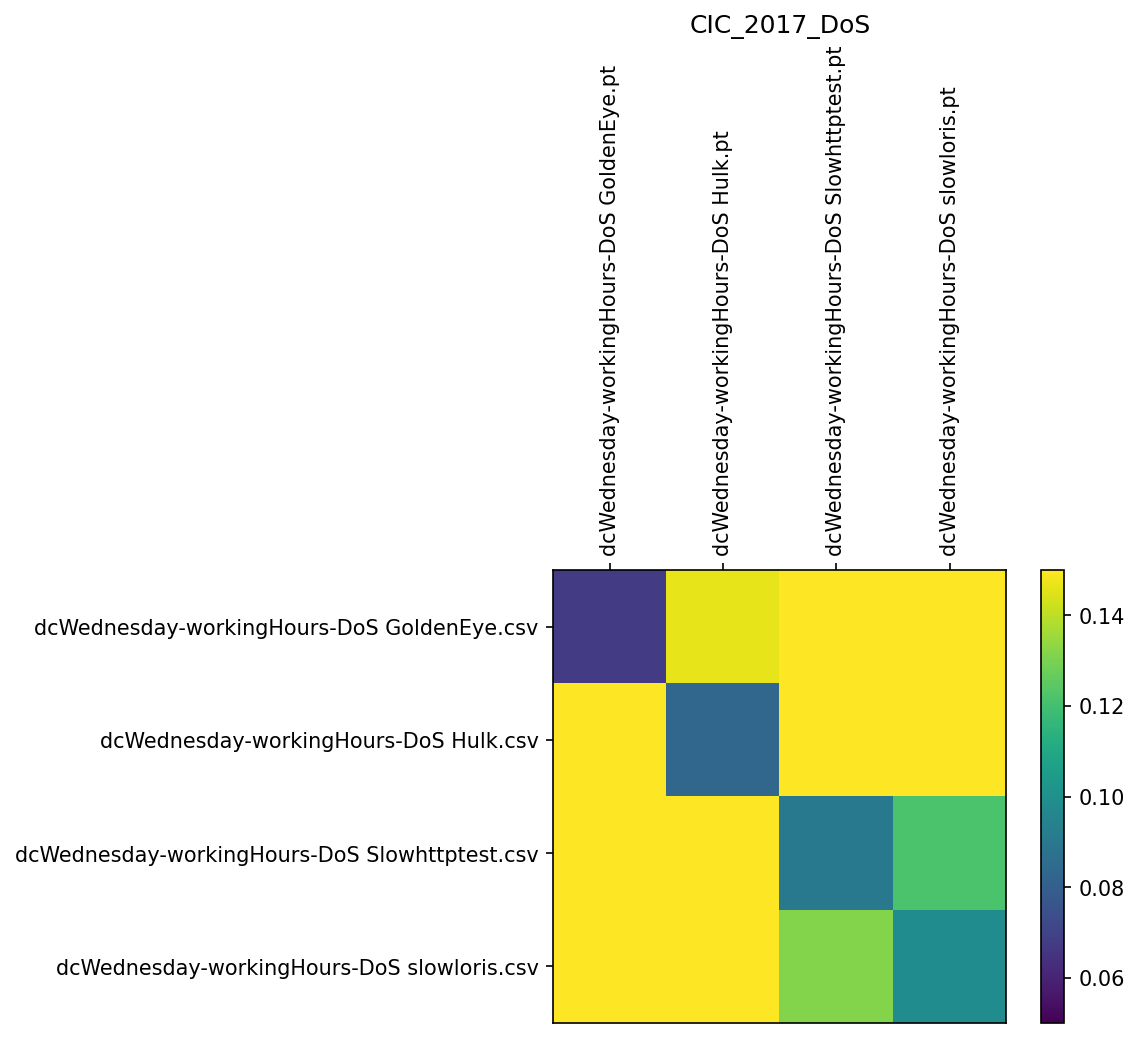

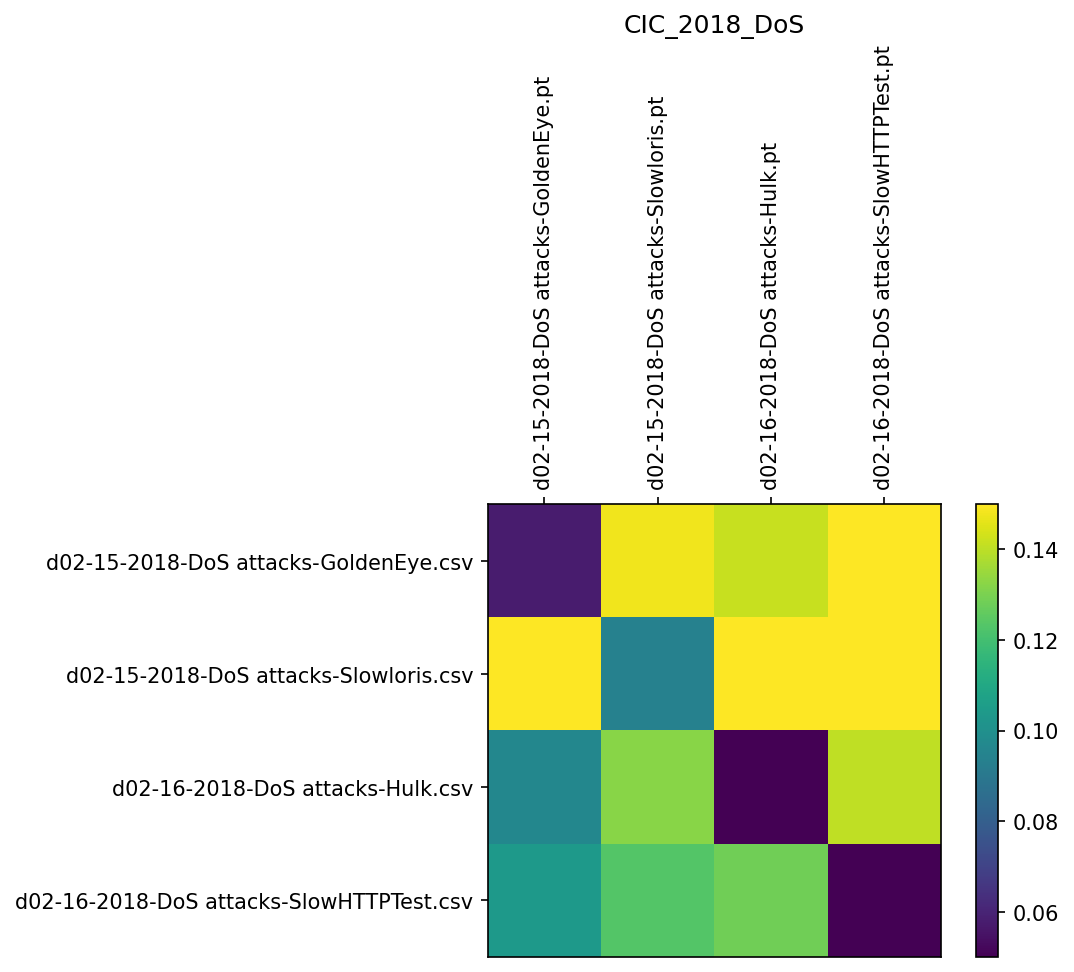

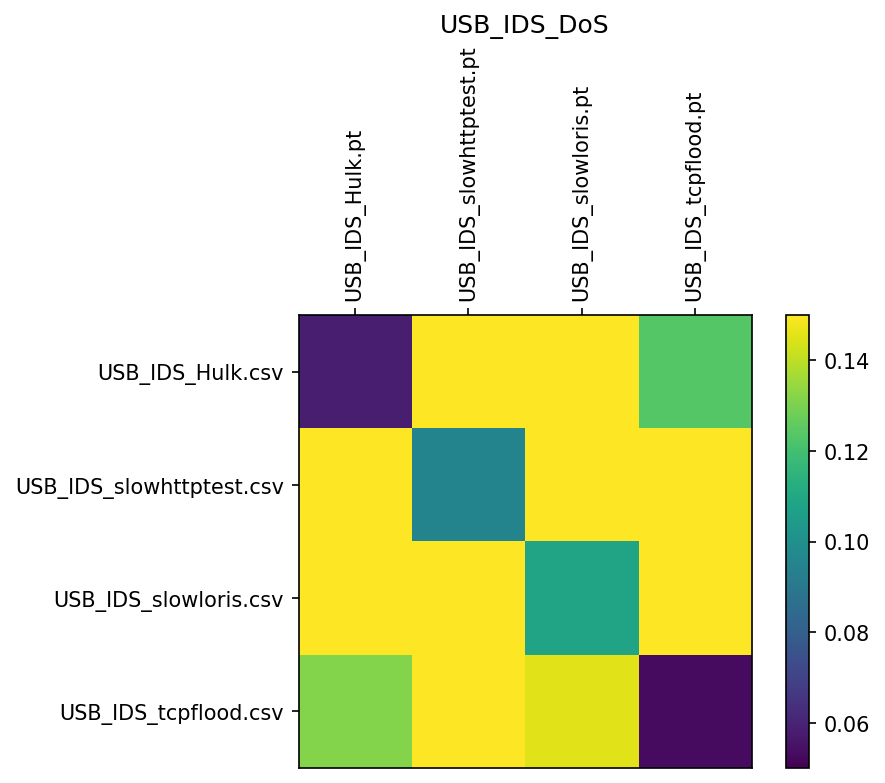

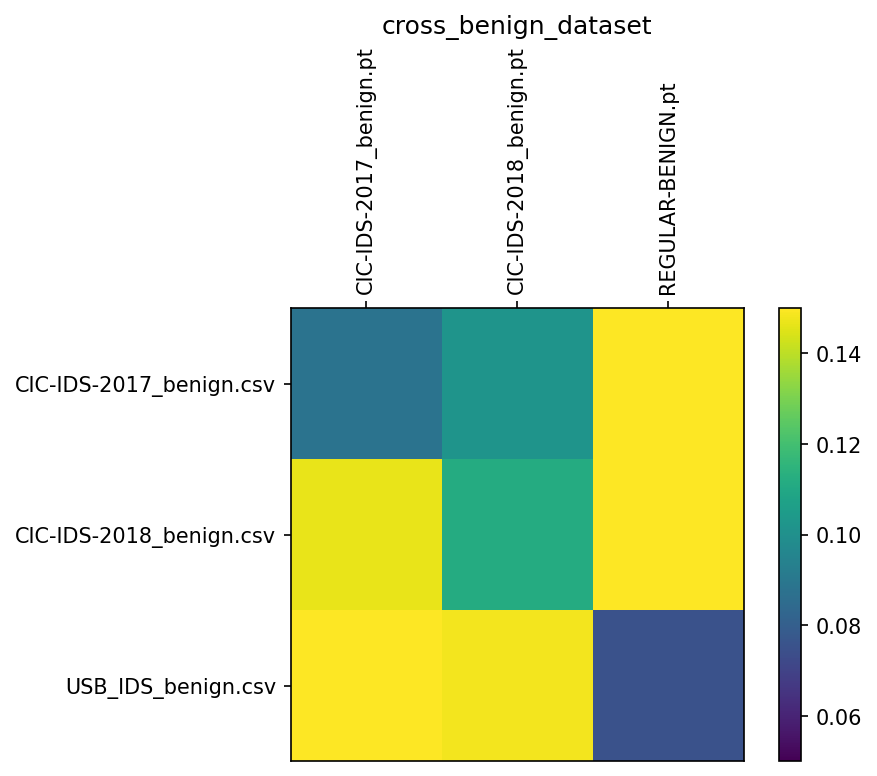

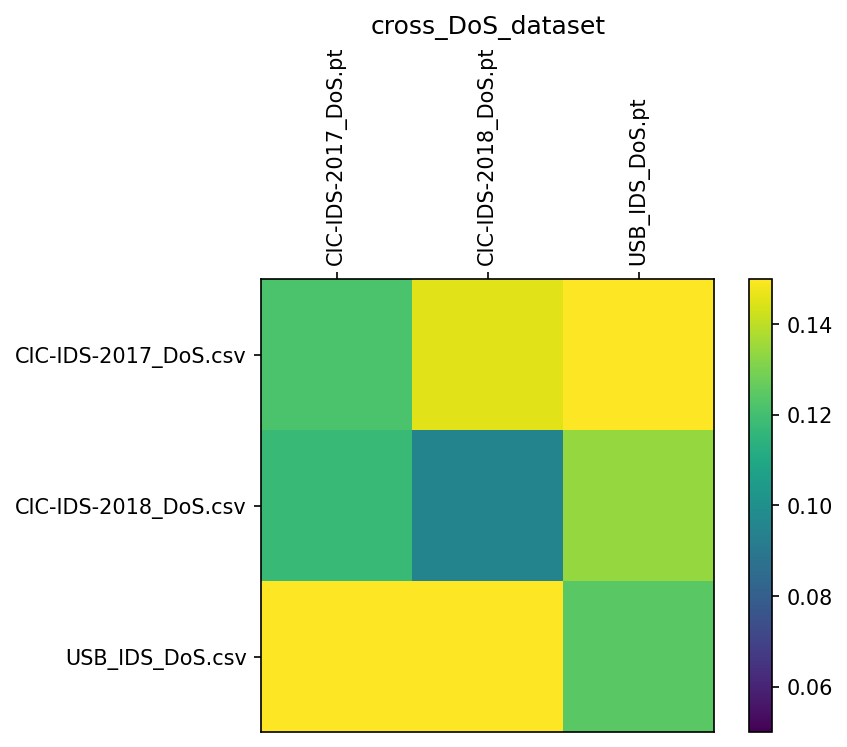

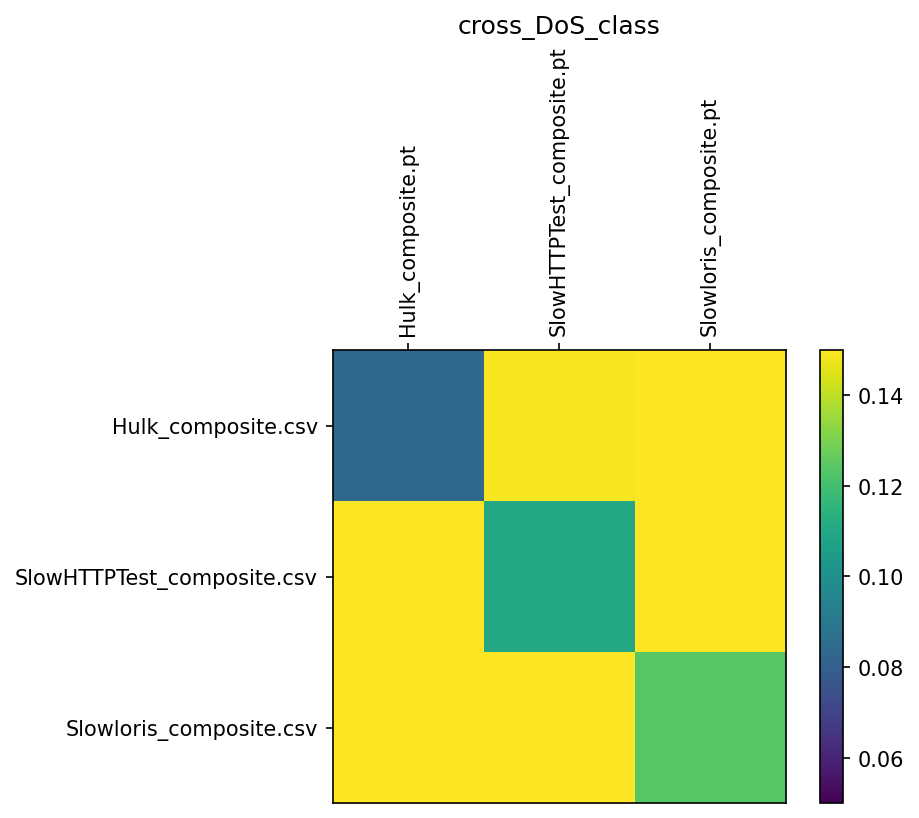

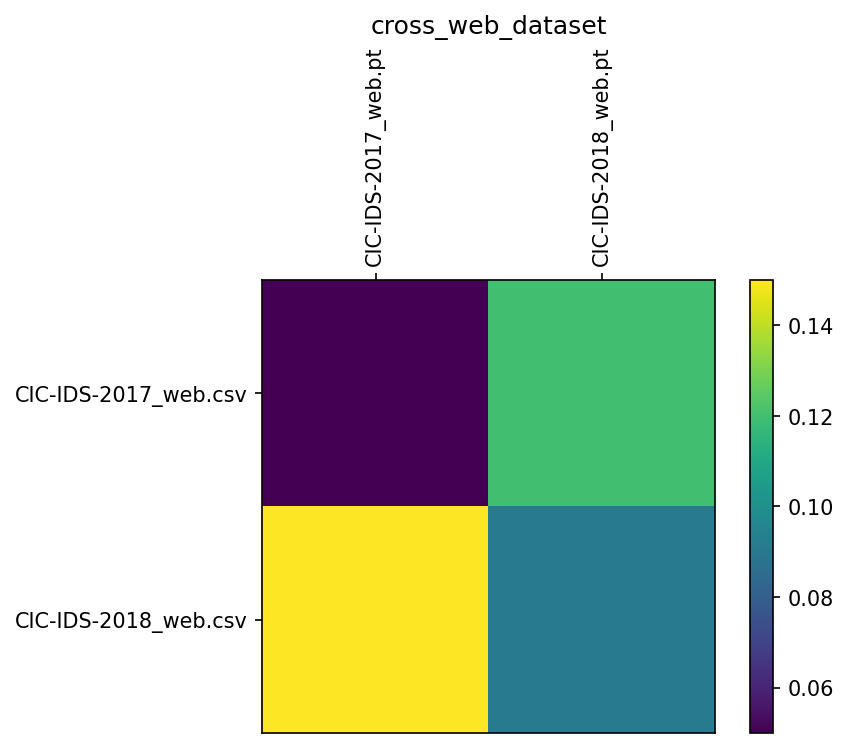

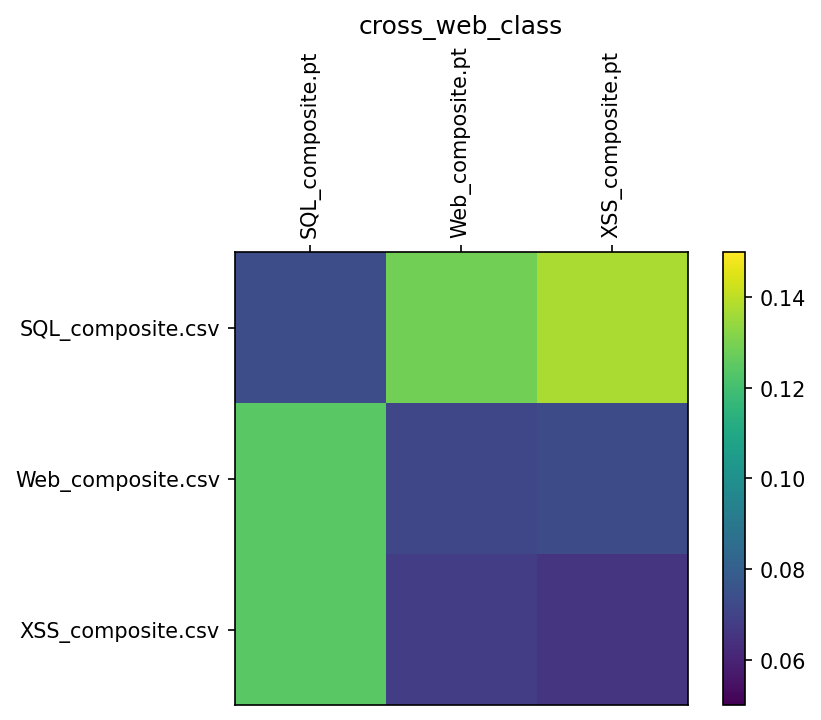

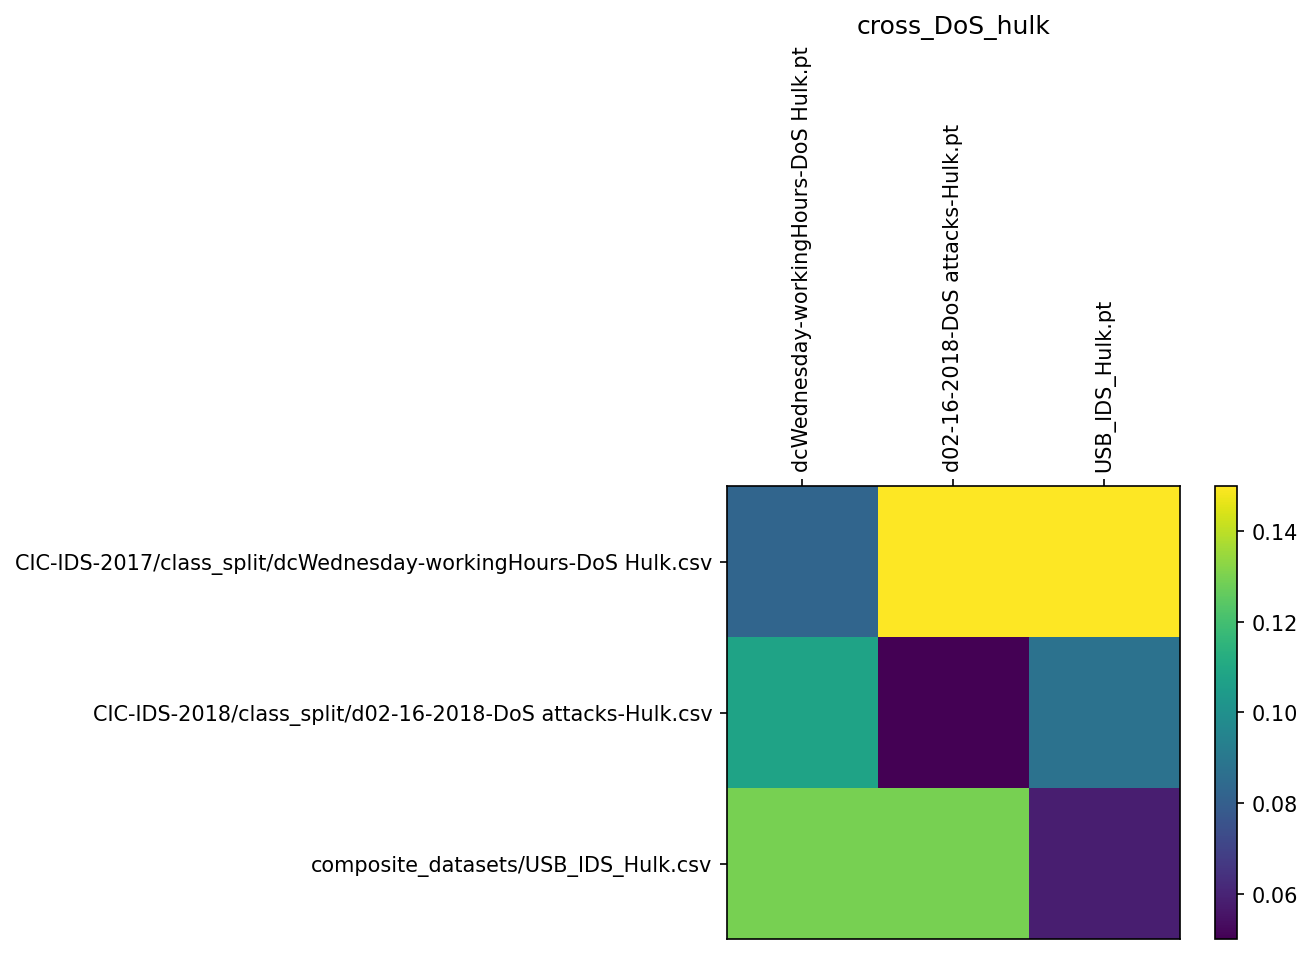

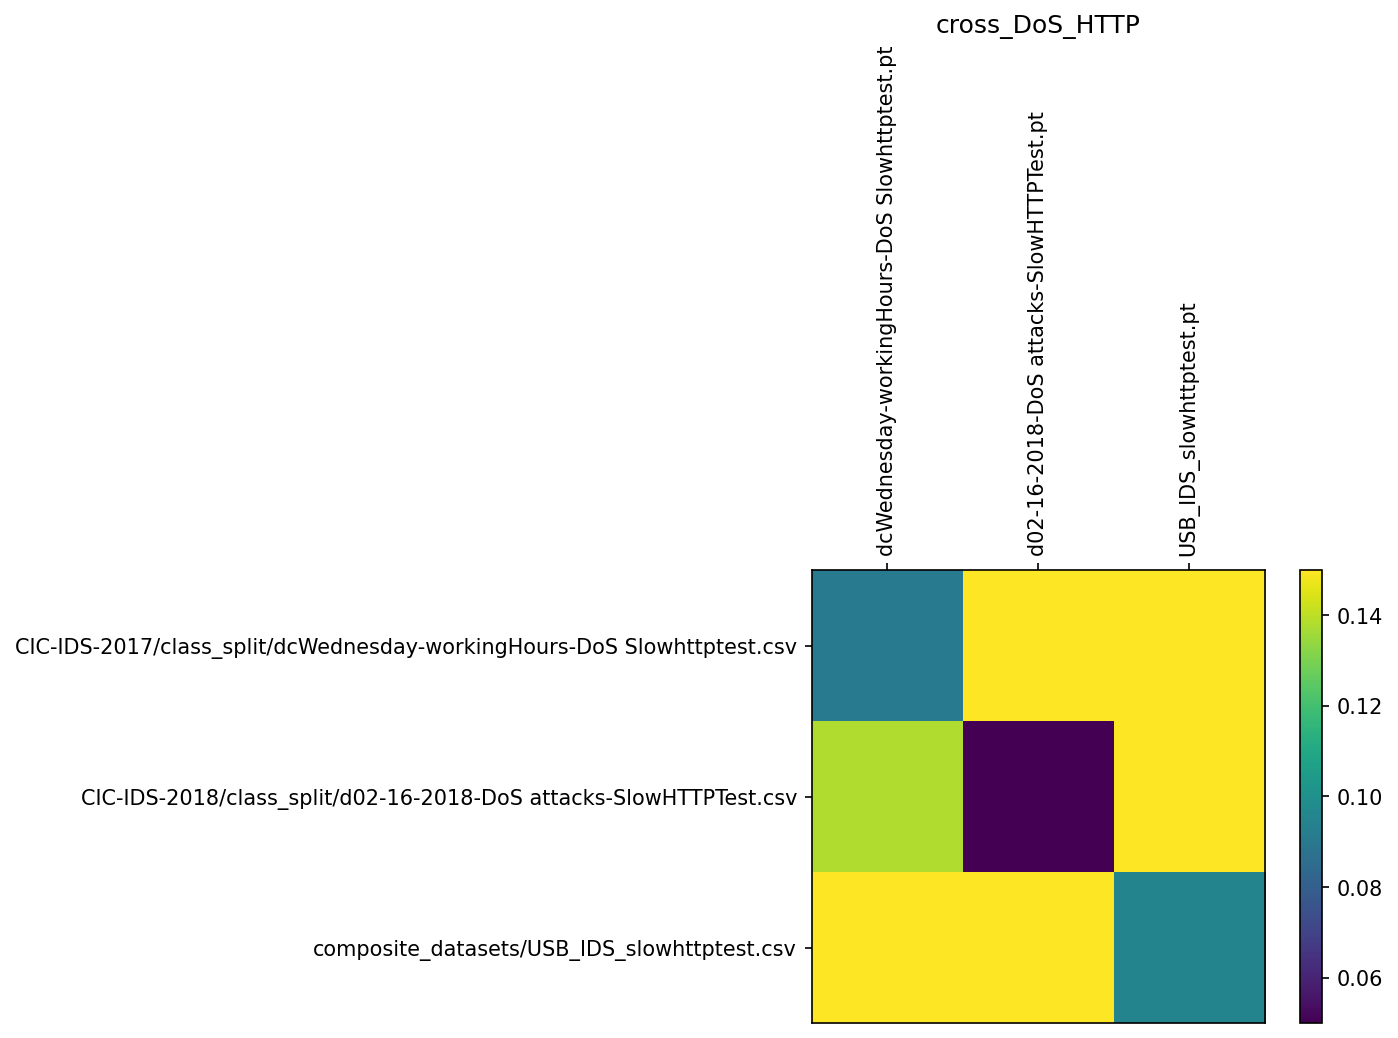

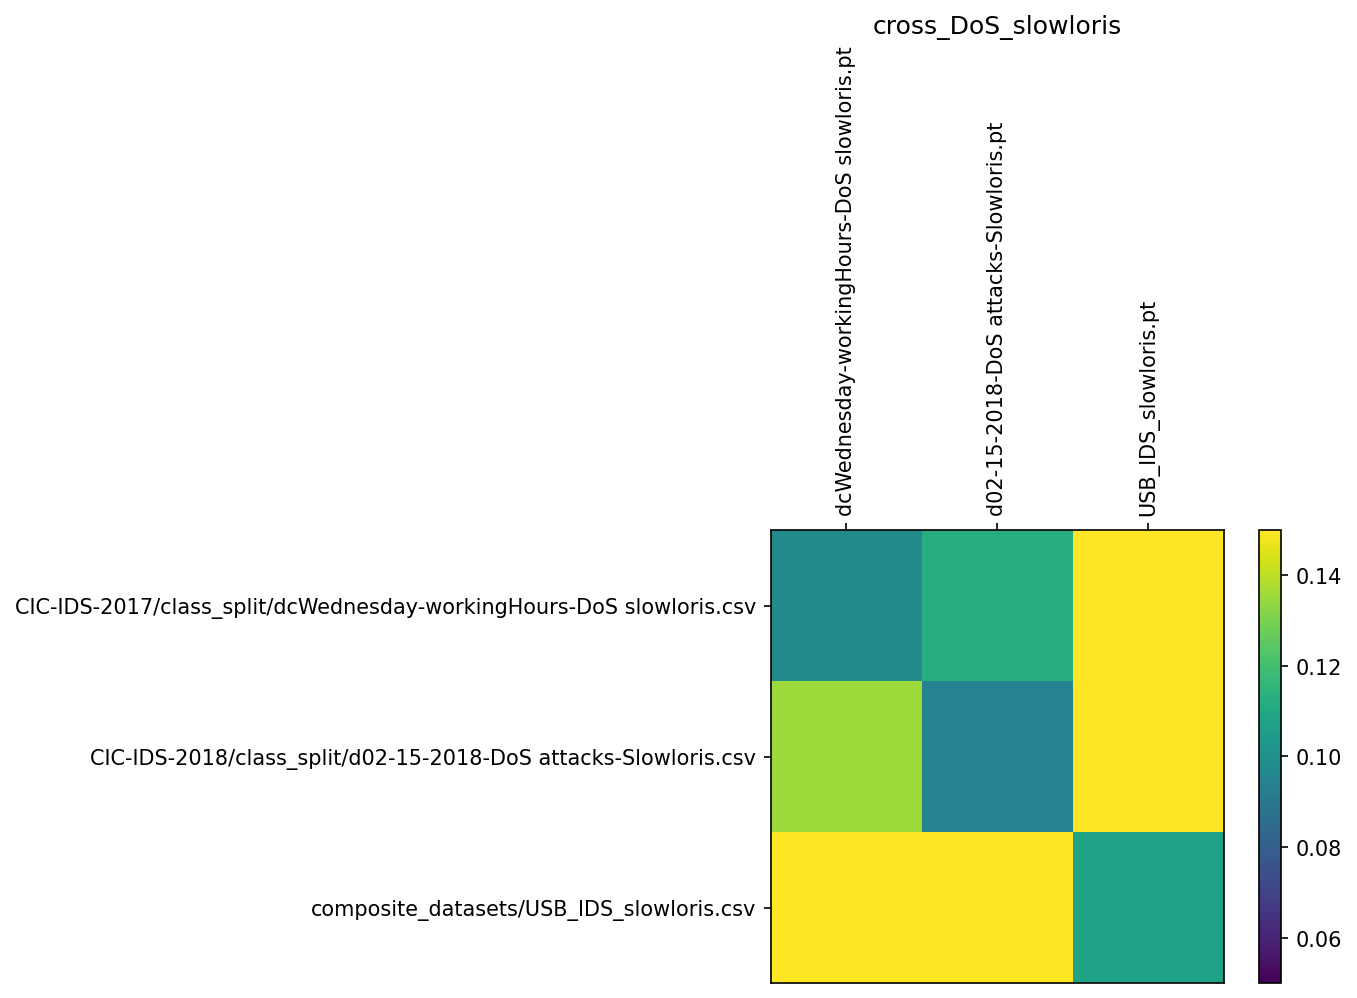

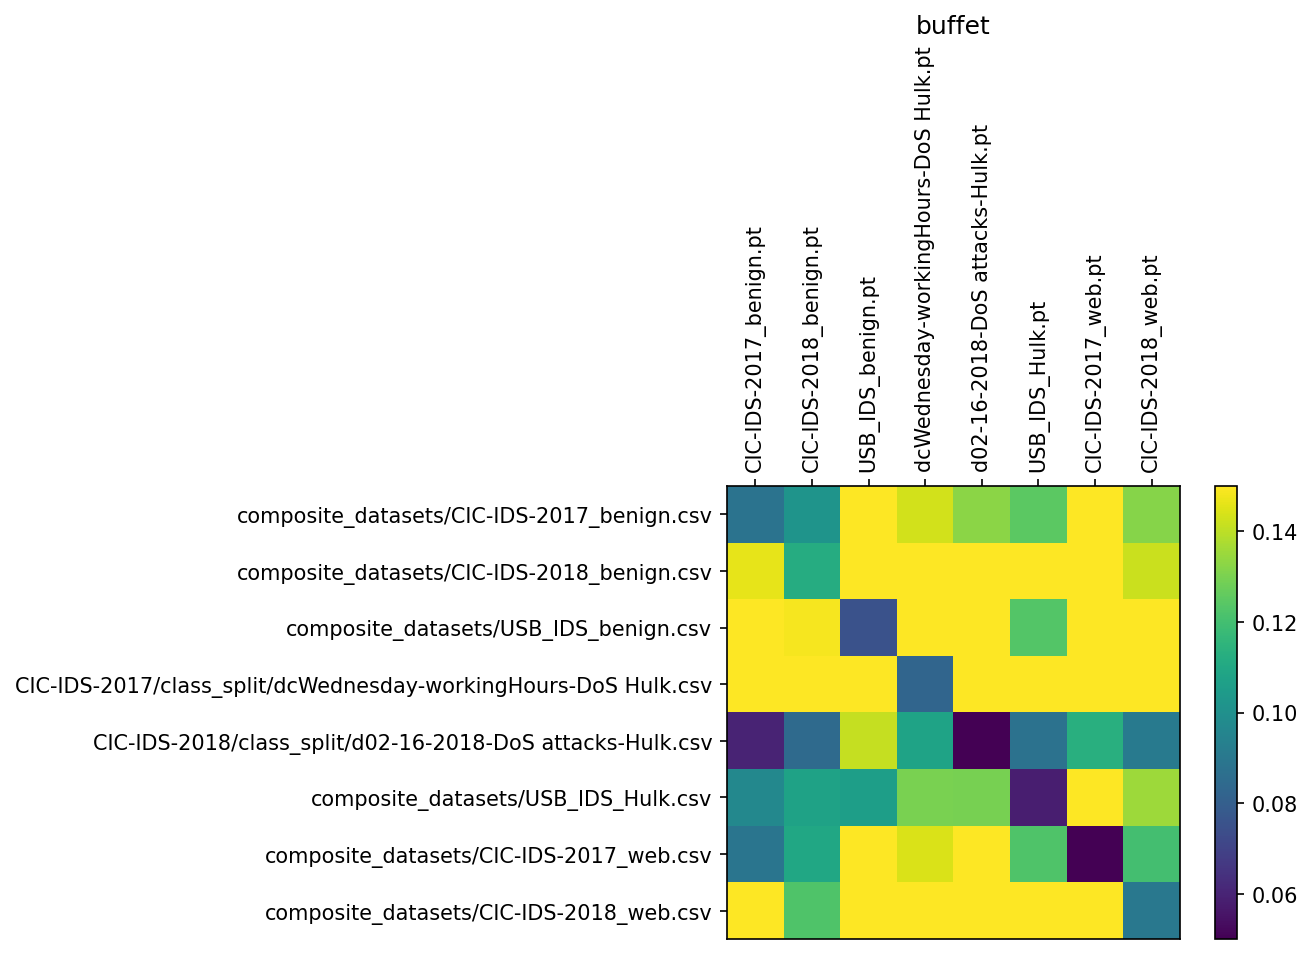

In [26]:
for model_key in results_dic:
    # print(results_dic[model_key]['results_mean'])
    result_arr = []
    n = len(results_dic[model_key]['models'])
    for row_i in range(n):
        result_arr.append([None] * n)
        dataset_name = results_dic[model_key]['datasets'][row_i]
        for col_i in range(n):
            model_name = results_dic[model_key]['models'][col_i]
            result_arr[row_i][col_i] = results_dic[model_key]['results_mean'][model_name][dataset_name]
            # print(f'\t{model_name}+{dataset_name}',end='')
        # print('')
    # print(result_arr)
    # print('>', results_dic[model_key]['models'])
    normalized_arr = []
    for row_i in range(n):
        normalized_arr.append([None] * n)
        min_val = np.min(result_arr)
        for col_i in range(n):
            normalized_arr[row_i][col_i] = (result_arr[row_i][col_i]-min_val)/min_val

    line_norm_arr = []
    for row_i in range(n):
        line_norm_arr.append([None] * n)
        scale_val = np.min(result_arr[row_i][row_i])
        for col_i in range(n):
            line_norm_arr[row_i][col_i] = (result_arr[row_i][col_i]-scale_val)/scale_val


    print(model_key)
    print('\t normal results')
    for e in result_arr:
        print('\t', end='')
        for i in e:
            print("{:8.4f}".format(i),end=' ')
        print('')
    print(f'\tmax: {np.max(result_arr)}, min: {np.min(result_arr)}')
    print('\t Scaled to min results:')
    for e in normalized_arr:
        print('\t', end='')
        for i in e:
            print("{:8.4f}".format(i),end=' ')
        print('')
    print('\t max err:',np.max(normalized_arr))
    print('\t Dataset scaled:')
    for e in line_norm_arr:
        print('\t', end='')
        for i in e:
            print("{:8.4f}".format(i),end=' ')
        print('')
    print('\t max err:',np.max(line_norm_arr))
    plot_cross_test(result_arr, model_key, results_dic[model_key]['models'], results_dic[model_key]['datasets'])
    # plot_cross_test(result_arr, model_key, results_dic[model_key]['models'], results_dic[model_key]['datasets'], scale=(0.05,0.15))
    # plot_cross_test(normalized_arr, model_key + '_normalized', results_dic[model_key]['models'], results_dic[model_key]['datasets'])
    # plot_cross_test(line_norm_arr, model_key + '_dataset_normalized', results_dic[model_key]['models'], results_dic[model_key]['datasets'])

# Old Stuff

## Old Training Loops

### CIC-IDS 2018

In [ ]:
for class_file in CIC_2018_groups['benign']:
    # print(workspace_dir + CIC_2018_dir + class_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + CIC_2018_dir + class_file)
    # print(len(data))
    # break
    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(class_file)

    # print(workspace_dir + CIC_2018_dir + class_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + class_file[:-4] + '.pt')

In [ ]:
for DoS_file in CIC_2018_groups['DoS']:
    # print(workspace_dir + CIC_2018_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + CIC_2018_dir + DoS_file)
    print(workspace_dir + CIC_2018_dir + DoS_file)

    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(DoS_file)

    # print(workspace_dir + CIC_2018_dir + benign_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + DoS_file[:-4] + '.pt')

In [ ]:
for web_file in CIC_2018_groups['web']:
    # print(workspace_dir + CIC_2018_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + CIC_2018_dir + web_file)
    print(workspace_dir + CIC_2018_dir + web_file)

    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(web_file)

    # print(workspace_dir + CIC_2018_dir + benign_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + web_file[:-4] + '.pt')

In [ ]:
for benign_file in CIC_2017_groups['benign']:
    # print(workspace_dir + CIC_2018_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + dataset_dir + benign_file)
    # print(len(data))
    # break
    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(benign_file)

    # print(workspace_dir + dataset_dir + benign_file[:-4] + '.pt')
    # break
    torch.save(model, workspace_dir + 'models/' + benign_file[:-4] + '.pt')

In [ ]:
dataset_dir = CIC_2017_dir
for DoS_file in CIC_2017_groups['DoS']:
    # print(workspace_dir + dataset_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + dataset_dir + DoS_file)
    print(workspace_dir + dataset_dir + DoS_file)

    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(DoS_file)

    # print(workspace_dir + dataset_dir + benign_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + DoS_file[:-4] + '.pt')

In [ ]:
for web_file in CIC_2017_groups['web']:
    # print(workspace_dir + CIC_2017_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + CIC_2017_dir + web_file)
    print(workspace_dir + CIC_2017_dir + web_file)

    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]
    print(f'Training samples: {len(train_data)}, Testing samples: {len(test_data)}')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(web_file)

    # print(workspace_dir + CIC_2017_dir + benign_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + web_file[:-4] + '.pt')

In [ ]:
for benign_file in USB_IDS_groups['benign']:
    # print(workspace_dir + USB_dir + benign_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + USB_dir + benign_file)
    # print(len(data))
    # break
    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]
    print(f'Training samples: {len(train_data)}, Testing samples: {len(test_data)}')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(benign_file)

    # print(workspace_dir + USB_dir + benign_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + benign_file[:-4] + '.pt')

In [ ]:
for class_file in USB_IDS_groups['hulk']:
    # print(workspace_dir + dataset_dir + class_file)
    model = IDS_VAE(latent_dim, KL_weight).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses_train = []
    losses_test = []

    data = IDS_Dataset(workspace_dir + dataset_dir + class_file)
    # print(len(data))
    # break
    train_mask = np.random.rand(len(data)) < train_split
    train_data = data[train_mask]
    test_data = data[~train_mask]
    print(f'Training samples: {len(train_data)}, Testing samples: {len(test_data)}')

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        # Train
        # model.train()
        # for data in train_loader:
        for i in qqdm(range(100)):
            model.train()
            data = next(iter(train_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_train.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #Eval
            model.eval()
            data = next(iter(test_loader))
            x = data.view(-1, 1, 8, 8).cuda()
            encoded_out, reparam_out, mu, var, decoded_out = model.forward(x)
            loss, mse_loss, KL_loss = model.loss(decoded_out, x, mu, var)
            losses_test.append(loss.item())
        
    plt.figure(dpi=200)
    plt.plot(list(range(len(losses_train))), losses_train, list(range(len(losses_train))), losses_test)
    plt.legend(['Train', 'Test'])
    plt.title(class_file)

    # print(workspace_dir + dataset_dir + class_file[:-4] + '.pt')
    torch.save(model, workspace_dir + 'models/' + class_file[:-4] + '.pt')